In [1]:
from ipynb.fs.defs.Preprocessing_Module import read_data, add_topological, add_landcover, merge_new_data, fill_data, select_columns, reshape_dataset, fillna_dataset, remove_nan_features, statistics, plot_correlations, temp_rainfall_plot
from ipynb.fs.defs.Feature_Expansion_Module import feature_expansion
from ipynb.fs.defs.Initializer_Module import initializer
from ipynb.fs.defs.XGboost_Model_Module import Xgboost_model
from ipynb.fs.defs.Neural_Network_Module import FeedforwardNeuralNetModel
from ipynb.fs.defs.Model_Validation_Module import give_predictions_nn, evaluate_nn, give_predictions_xgboost, evaluate_xgboost, validate_results2, merge_predictions
import numpy as np
import pandas as pd

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

In [3]:
data = read_data('../Datasets/Italy/Veneto/Anopheles/IT_veneto_anopheles_2010_2023.csv')
data = merge_new_data('../Datasets/Italy/Veneto/Anopheles/2023/IT_veneto_env_05_2023_2km_processed.csv', data)
data = merge_new_data('../Datasets/Italy/Veneto/Anopheles/2023/IT_veneto_env_06_2023_2km_processed.csv', data)
data = merge_new_data('../Datasets/Italy/Veneto/Anopheles/2023/IT_veneto_env_07_2023_2km_processed.csv', data)
data = merge_new_data('../Datasets/Italy/Veneto/Anopheles/2023/IT_veneto_env_08_2023_2km_processed.csv', data)
data = merge_new_data('../Datasets/Italy/Veneto/Anopheles/2023/IT_veneto_env_09_2023_2km_processed.csv', data)
data = merge_new_data('../Datasets/Italy/Veneto/Anopheles/2023/IT_veneto_env_10_2023_2km_processed.csv', data)
columns = ['dt_placement', 'x', 'y', 'anopheles_total', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
           'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
           'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
           'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
           'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
           'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
names = ['dt_placement', 'x', 'y', 'mosq_now', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
         'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
         'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
         'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
         'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
         'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
data = select_columns(data,columns,names)
data = add_topological(data,'../Datasets/Topological Datasets/2x2grid/Italy_veneto_2km_geo.csv')
data = add_landcover(data,'../Datasets/Landcover Datasets/2x2grid/Italy_veneto_2km_lulc.csv')
data = reshape_dataset(data,['x','y','dt_placement'])
data = fillna_dataset(data,{'acc_rainfall_1week':0, 'acc_rainfall_2week':0, 'acc_rainfall_jan':0})

Index(['station_id', 'x', 'y', 'dt_placement', 'week', 'month', 'year',
       'country_code', 'nuts0_code', 'nuts0_name', 'nuts1_code', 'nuts1_name',
       'nuts2_code', 'nuts2_name', 'nuts3_code', 'nuts3_name',
       'lau1_municipality', 'lau2_settlement', 'trap_type',
       'anopheles zacharovi', 'anopheles maculipenis', 'anopheles_total',
       'region', 'dt_placement_original', 'indices_image_date', 'indices_lat',
       'indices_lon', 'ndvi', 'ndmi', 'ndwi', 'ndbi', 'ndvi_mean', 'ndmi_mean',
       'ndwi_mean', 'ndbi_mean', 'ndvi_std', 'ndmi_std', 'ndwi_std',
       'ndbi_std', 'lst_image_date', 'lst_lat', 'lst_lon', 'lst_day',
       'lst_night', 'monthly_lst_lat', 'monthly_lst_lon', 'lst_jan_day_mean',
       'lst_jan_night_mean', 'lst_feb_day_mean', 'lst_feb_night_mean',
       'lst_mar_day_mean', 'lst_mar_night_mean', 'lst_apr_day_mean',
       'lst_apr_night_mean', 'indices_image_date.1', 'indices_lat.1',
       'indices_lon.1', 'acc_rainfall_jan', 'dt_placement_minus_7'

In [4]:
# set the filename for export
case = 'Anopheles_Italy_Veneto_'

# set the filename to export
path = './predictions/Italy/Veneto/Anopheles/'

# set the name of the date column
date_col = 'dt_placement'

# set the model type. Could be 'class_regression' or 'mosquito_regression' or 'classification'
model_type = 'class_regression'

In [5]:
data = feature_expansion(data)

In [6]:
import sys
sys.modules.pop('ipynb.fs.defs.Preprocessing_Module')
from ipynb.fs.defs.Preprocessing_Module import read_data, add_topological, add_landcover, merge_new_data, fill_data, select_columns, reshape_dataset, fillna_dataset, remove_nan_features, statistics, plot_correlations, temp_rainfall_plot

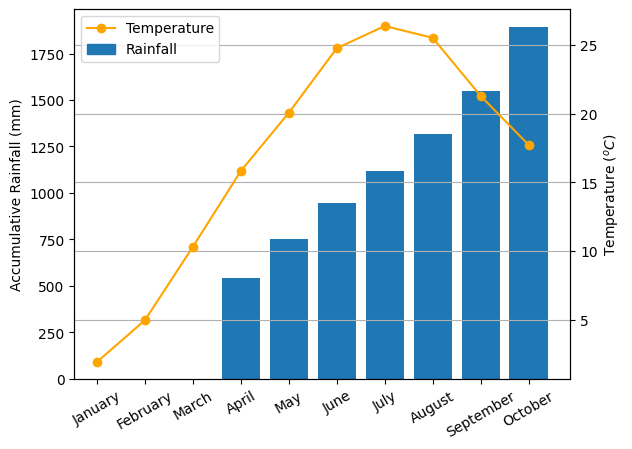

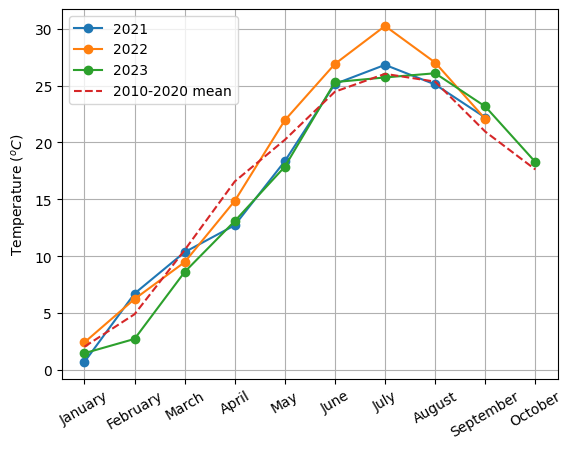

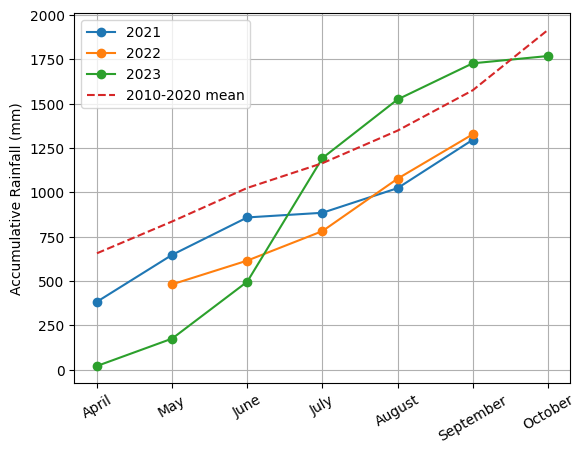

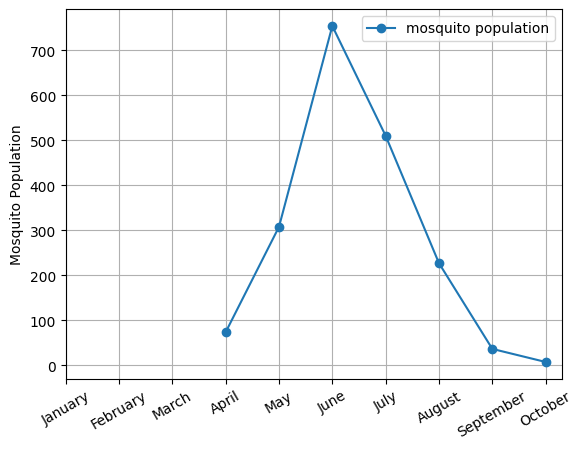

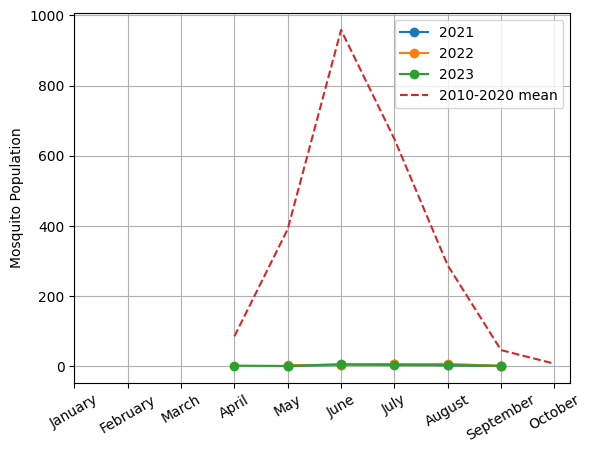

In [6]:
temp_rainfall_plot(data, rainfall_column='acc_rainfall_jan')

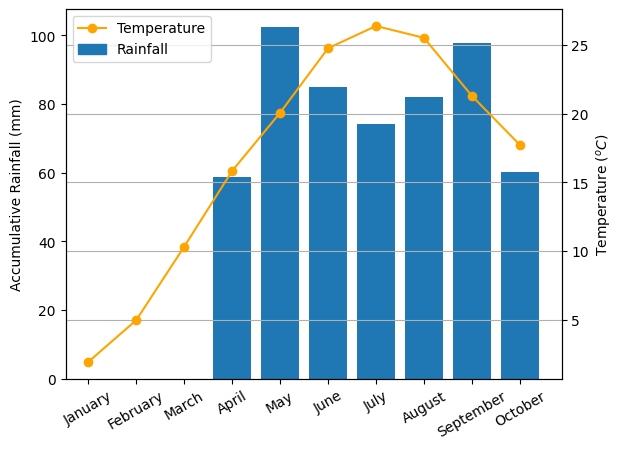

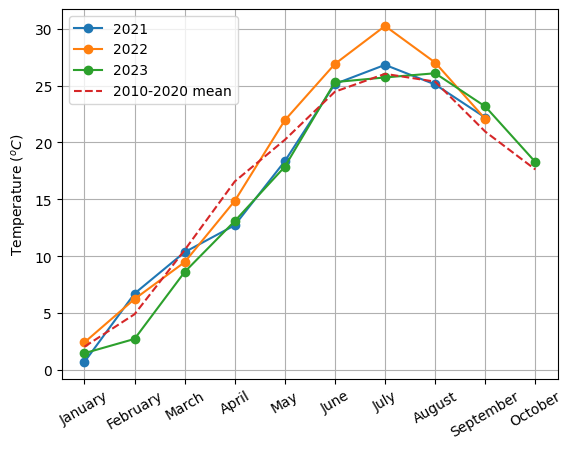

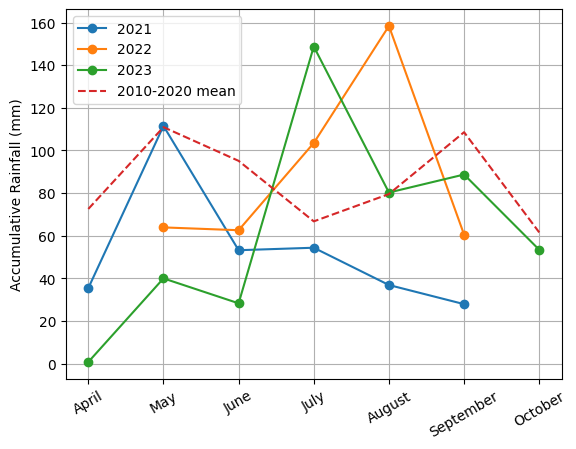

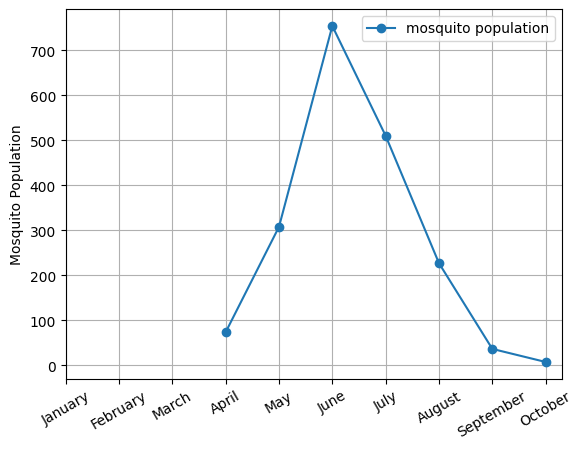

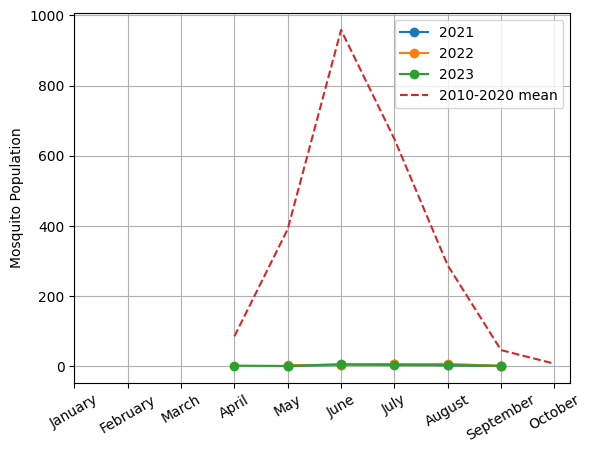

In [6]:
temp_rainfall_plot(data, rainfall_column='acc_rainfall_2week')

In [9]:
date_column='dt_placement'
mosq = data[[date_column,'mosq_now']]
mosq = mosq.groupby(date_column).mean().reset_index()
mosq = mosq.groupby(mosq[date_column].dt.to_period('M')).mean().drop(columns=[date_column]).reset_index()
mosq[date_column] = mosq[date_column].dt.to_timestamp()
mosq = mosq.groupby(mosq.dt_placement.dt.month)['mosq_now'].mean()
mosq

dt_placement
4      73.655952
5     307.717010
6     753.999157
7     509.976167
8     226.961256
9      36.535268
10      7.500000
Name: mosq_now, dtype: float64

In [10]:
date_column='dt_placement'
mosq = data[[date_column,'mosq_now']]
mosq = mosq.groupby(date_column).mean().reset_index()
mosq = mosq.groupby(mosq[date_column].dt.to_period('M')).mean().drop(columns=[date_column]).reset_index()
mosq[date_column] = mosq[date_column].dt.to_timestamp()
mosq[mosq['dt_placement'].dt.month==4]

dt_placement    mosq_now
0    2010-04-01   86.083333
6    2011-04-01   60.458333
13   2012-04-01   76.750000
19   2013-04-01  248.300000
26   2014-04-01   24.000000
56   2019-04-01   18.000000
67   2021-04-01         NaN
78   2023-04-01    2.000000

In [11]:
mosq[mosq['dt_placement'].dt.month==5]

dt_placement    mosq_now
1    2010-05-01  515.750000
7    2011-05-01  232.361111
14   2012-05-01  471.930556
20   2013-05-01  515.855556
27   2014-05-01  265.380952
33   2015-05-01  226.523810
39   2016-05-01  471.583333
45   2017-05-01  354.922222
51   2018-05-01  464.811458
57   2019-05-01  557.523810
62   2020-05-01  225.527778
68   2021-05-01    1.218750
73   2022-05-01    3.523810
79   2023-05-01    1.125000

In [12]:
mosq[mosq['dt_placement'].dt.month==6]

dt_placement     mosq_now
2    2010-06-01  1211.725000
8    2011-06-01  1172.285417
15   2012-06-01  1633.666667
21   2013-06-01  1423.813492
28   2014-06-01   603.388889
34   2015-06-01   846.745370
40   2016-06-01   789.789827
46   2017-06-01   701.463605
52   2018-06-01   701.359184
58   2019-06-01   814.716667
63   2020-06-01   642.905556
69   2021-06-01     3.890741
74   2022-06-01     4.127778
80   2023-06-01     6.110000

In [13]:
mosq[mosq['dt_placement'].dt.month==7]

dt_placement     mosq_now
3    2010-07-01   855.506944
9    2011-07-01   239.868197
16   2012-07-01  1192.634694
22   2013-07-01  1056.246420
29   2014-07-01   838.583333
35   2015-07-01   485.451852
41   2016-07-01   681.243056
47   2017-07-01   476.583333
53   2018-07-01   418.227083
59   2019-07-01   566.380952
64   2020-07-01   313.333333
70   2021-07-01     6.541667
75   2022-07-01     5.375000
81   2023-07-01     3.690476

In [14]:
mosq[mosq['dt_placement'].dt.month==8]

dt_placement    mosq_now
4    2010-08-01  394.716667
10   2011-08-01  275.833333
17   2012-08-01  576.741667
23   2013-08-01  300.222222
30   2014-08-01  345.650000
36   2015-08-01  224.833333
42   2016-08-01  254.610000
48   2017-08-01  209.414815
54   2018-08-01  155.786508
60   2019-08-01  210.257143
65   2020-08-01  215.968750
71   2021-08-01    2.631481
76   2022-08-01    7.250000
82   2023-08-01    3.541667

In [15]:
mosq[mosq['dt_placement'].dt.month==9]

dt_placement    mosq_now
5    2010-09-01   13.937500
11   2011-09-01   45.958333
18   2012-09-01   44.250000
24   2013-09-01   42.531250
31   2014-09-01   33.000000
37   2015-09-01   16.750000
43   2016-09-01   24.500000
49   2017-09-01   33.900000
55   2018-09-01  144.250000
61   2019-09-01   42.416667
66   2020-09-01   66.333333
72   2021-09-01    1.000000
77   2022-09-01    1.000000
83   2023-09-01    1.666667

In [30]:
data2 = read_data('../datasets/Italy/Veneto/Anopheles/IT_veneto_anopheles_2010_2023.csv', date_col = 'dt_placement_original')
data2 = merge_new_data('../datasets/Italy/Veneto/Anopheles/2023/IT_veneto_env_05_2023_2km_processed.csv', data2)
data2 = merge_new_data('../datasets/Italy/Veneto/Anopheles/2023/IT_veneto_env_06_2023_2km_processed.csv', data2)
data2 = merge_new_data('../datasets/Italy/Veneto/Anopheles/2023/IT_veneto_env_07_2023_2km_processed.csv', data2)
data2 = merge_new_data('../datasets/Italy/Veneto/Anopheles/2023/IT_veneto_env_08_2023_2km_processed.csv', data2)
data2 = merge_new_data('../datasets/Italy/Veneto/Anopheles/2023/IT_veneto_env_09_2023_2km_processed.csv', data2)
data2 = merge_new_data('../datasets/Italy/Veneto/Anopheles/2023/IT_veneto_env_10_2023_2km_processed.csv', data2)
columns = ['dt_placement_original', 'x', 'y', 'anopheles_total', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
           'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
           'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
           'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
           'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
           'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
names = ['dt_placement', 'x', 'y', 'mosq_now', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
         'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
         'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
         'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
         'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
         'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
data2 = select_columns(data2,columns,names)
data2 = add_topological(data2,'../datasets/Topological datasets/2x2grid/Italy_veneto_2km_geo.csv')
data2 = add_landcover(data2,'../datasets/Landcover datasets/2x2grid/Italy_veneto_2km_lulc.csv')
data2 = reshape_dataset(data2,['x','y','dt_placement'])
data2 = fillna_dataset(data2,{'acc_rainfall_1week':0, 'acc_rainfall_2week':0, 'acc_rainfall_jan':0})

Index(['station_id', 'x', 'y', 'dt_placement', 'week', 'month', 'year',
       'country_code', 'nuts0_code', 'nuts0_name', 'nuts1_code', 'nuts1_name',
       'nuts2_code', 'nuts2_name', 'nuts3_code', 'nuts3_name',
       'lau1_municipality', 'lau2_settlement', 'trap_type',
       'anopheles zacharovi', 'anopheles maculipenis', 'anopheles_total',
       'region', 'dt_placement_original', 'indices_image_date', 'indices_lat',
       'indices_lon', 'ndvi', 'ndmi', 'ndwi', 'ndbi', 'ndvi_mean', 'ndmi_mean',
       'ndwi_mean', 'ndbi_mean', 'ndvi_std', 'ndmi_std', 'ndwi_std',
       'ndbi_std', 'lst_image_date', 'lst_lat', 'lst_lon', 'lst_day',
       'lst_night', 'monthly_lst_lat', 'monthly_lst_lon', 'lst_jan_day_mean',
       'lst_jan_night_mean', 'lst_feb_day_mean', 'lst_feb_night_mean',
       'lst_mar_day_mean', 'lst_mar_night_mean', 'lst_apr_day_mean',
       'lst_apr_night_mean', 'indices_image_date.1', 'indices_lat.1',
       'indices_lon.1', 'acc_rainfall_jan', 'dt_placement_minus_7'

In [31]:
# data2 = read_data('../Datasets/Italy/Veneto/Anopheles/IT_veneto_anopheles_2010_2023.csv')
date_column='dt_placement'
# data2[date_column] = pd.to_datetime(data2[date_column], format="%Y-%m-%d")
mosq = data2[[date_column,'mosq_now']].dropna()
# mosq = mosq.groupby(date_column).mean().reset_index()
# mosq = mosq.groupby(mosq[date_column].dt.to_period('M')).sum().drop(columns=[date_column]).reset_index()
# mosq[date_column] = mosq[date_column].dt.to_timestamp()
mosq[mosq[date_column].dt.month==6]

dt_placement  mosq_now
12     2010-06-21      40.0
28     2017-06-21     362.0
44     2010-06-07    2142.0
45     2010-06-21    1142.0
55     2011-06-16    3324.0
...           ...       ...
2406   2017-06-19     108.0
2411   2018-06-18     154.0
2414   2020-06-24     677.0
2418   2021-06-09       1.0
2441   2020-06-29      62.0

[411 rows x 2 columns]

In [59]:
df = data2.groupby([pd.to_datetime(data2[date_column]).dt.year,
                       pd.to_datetime(data2[date_column]).dt.month]).agg({'mosq_now': 'mean'})

In [60]:
df.xs(5, level=1)

mosq_now
dt_placement            
2010          127.687500
2011          131.296296
2012          259.400000
2013          357.904762
2014           87.750000
2015           79.400000
2016          260.125000
2017          217.375000
2018          477.777778
2019           67.666667
2020          125.500000
2021            1.000000
2022            1.857143
2023            1.285714

In [63]:
df.xs(6, level=1)

mosq_now
dt_placement             
2010           773.904762
2011          1188.120000
2012          1130.904762
2013           750.047619
2014           598.115385
2015           674.444444
2016           826.342105
2017           649.058824
2018           592.948718
2019           720.850000
2020           558.821429
2021             3.472222
2022             6.125000
2023             1.400000

In [64]:
df.xs(7, level=1)

mosq_now
dt_placement             
2010          1242.484848
2011           618.133333
2012          1753.366667
2013          2131.017241
2014           673.600000
2015           791.410256
2016           933.850000
2017           589.564103
2018           609.565217
2019           846.933333
2020           512.818182
2021             6.210526
2022             4.619048
2023            11.153846

In [66]:
df.xs(8, level=1)

mosq_now
dt_placement            
2010          690.210526
2011          299.903226
2012          620.240000
2013          429.205882
2014          764.833333
2015          318.766667
2016          394.804878
2017          257.666667
2018          189.900000
2019          479.684211
2020          226.148148
2021            7.290323
2022            6.687500
2023            5.846154

In [62]:
df

mosq_now
dt_placement dt_placement             
2010         5              127.687500
             6              773.904762
             7             1242.484848
             8              690.210526
             9              115.300000
...                                ...
2023         5                1.285714
             6                1.400000
             7               11.153846
             8                5.846154
             9                1.692308

[80 rows x 1 columns]

In [67]:
df = data2.groupby([pd.to_datetime(data2[date_column]).dt.year,
                       pd.to_datetime(data2[date_column]).dt.month]).agg({'mosq_now': sum})

In [76]:
df.xs(6, level=1)

anopheles_total
dt_placement_original                 
2010                           16252.0
2011                           29703.0
2012                           23749.0
2013                           31502.0
2014                           15551.0
2015                           12140.0
2016                           31401.0
2017                           22068.0
2018                           23125.0
2019                           14417.0
2020                           16043.0
2021                             125.0
2022                             294.0
2023                              21.0

In [46]:
df.loc[[2023]]

mosq_now
dt_placement dt_placement          
2023         5                  9.0
             6                 21.0
             7                145.0
             8                 76.0
             9                 22.0

In [26]:
data2

station_id          x          y dt_placement  week  month  year  \
0            184  11.585081  45.519406   2010-04-18  18.0      4  2010   
1            186  11.535037  45.737123   2010-04-18  18.0      4  2010   
2            187  11.418664  45.631146   2010-04-18  18.0      4  2010   
3            188  11.373315  45.555083   2010-04-18  18.0      4  2010   
4              9  12.049586  44.986146   2010-04-25  19.0      4  2010   
...          ...        ...        ...          ...   ...    ...   ...   
2453         320  11.247569  45.337162   2023-09-05  38.0      9  2023   
2454         390  11.832971  45.340596   2023-09-10  39.0      9  2023   
2455         365  13.117108  46.019710   2023-09-12  39.0      9  2023   
2456         408  13.289388  46.001651   2023-09-12  39.0      9  2023   
2457         406  13.416025  45.898473   2023-09-12  39.0      9  2023   

     country_code  nuts0_code nuts0_name  ... dt_placement_minus_14  \
0              IT         0.0     Italia  ...            2010-04-04   
1              IT         0.0     Italia  ...            2010-04-04   
2              IT         0.0     Italia  ...            2010-04-04   
3              IT         0.0     Italia  ...            2010-04-04   
4              IT         0.0     Italia  ...            2010-04-11   
...           ...         ...        ...  ...                   ...   
2453           IT         0.0      ITALY  ...            2023-08-22   
2454           IT         0.0      ITALY  ...            2023-08-27   
2455           IT         0.0      ITALY  ...            2023-08-29   
2456           IT         0.0      ITALY  ...            2023-08-29   
2457           IT         0.0      ITALY  ...            2023-08-29   

     dt_placement_minus_7_avail dt_placement_minus_14_avail  \
0                    2010-04-11                  2010-04-04   
1                    2010-04-11                  2010-04-04   
2                    2010-04-11                  2010-04-04   
3                    2010-04-11                  2010-04-04   
4                    2010-04-18                  2010-04-11   
...                         ...                         ...   
2453                 2023-08-29                  2023-08-22   
2454                 2023-09-03                  2023-08-27   
2455                 2023-09-05                  2023-08-29   
2456                 2023-09-05                  2023-08-29   
2457                 2023-09-05                  2023-08-29   

     acc_rainfall_1week acc_rainfall_2week anopheles maculipennis s.l.  \
0             16.886482          47.999912                         NaN   
1             16.199128          22.216368                         NaN   
2             34.880679          56.465990                         NaN   
3             59.480387          80.950922                         NaN   
4             33.105538          73.599769                         NaN   
...                 ...                ...                         ...   
2453           2.317331         136.576938                         3.0   
2454           0.000000          61.172930                         1.0   
2455           0.000000          12.578226                         NaN   
2456           0.000000          15.215512                         NaN   
2457           0.000000          31.876045                         NaN   

     anopheles claviger s.l. anopheles plumbeus anopheles hyrcanus s.l.  \
0                        NaN                NaN                     NaN   
1                        NaN                NaN                     NaN   
2                        NaN                NaN                     NaN   
3                        NaN                NaN                     NaN   
4                        NaN                NaN                     NaN   
...                      ...                ...                     ...   
2453                     NaN                NaN                     NaN   
2454              

In [92]:
data2 = read_data('../Datasets/Italy/Veneto/Anopheles/IT_veneto_anopheles_2010_2023.csv')
date_column='dt_placement_original'
data2[date_column] = pd.to_datetime(data2[date_column], format="%Y-%m-%d")
mosq = data2[[date_column,'anopheles_total']].dropna()
df = mosq.groupby([pd.to_datetime(mosq[date_column]).dt.year,
                       pd.to_datetime(mosq[date_column]).dt.month]).agg({'anopheles_total': 'mean'})

Index(['station_id', 'x', 'y', 'dt_placement', 'week', 'month', 'year',
       'country_code', 'nuts0_code', 'nuts0_name', 'nuts1_code', 'nuts1_name',
       'nuts2_code', 'nuts2_name', 'nuts3_code', 'nuts3_name',
       'lau1_municipality', 'lau2_settlement', 'trap_type',
       'anopheles zacharovi', 'anopheles maculipenis', 'anopheles_total',
       'region', 'dt_placement_original', 'indices_image_date', 'indices_lat',
       'indices_lon', 'ndvi', 'ndmi', 'ndwi', 'ndbi', 'ndvi_mean', 'ndmi_mean',
       'ndwi_mean', 'ndbi_mean', 'ndvi_std', 'ndmi_std', 'ndwi_std',
       'ndbi_std', 'lst_image_date', 'lst_lat', 'lst_lon', 'lst_day',
       'lst_night', 'monthly_lst_lat', 'monthly_lst_lon', 'lst_jan_day_mean',
       'lst_jan_night_mean', 'lst_feb_day_mean', 'lst_feb_night_mean',
       'lst_mar_day_mean', 'lst_mar_night_mean', 'lst_apr_day_mean',
       'lst_apr_night_mean', 'indices_image_date.1', 'indices_lat.1',
       'indices_lon.1', 'acc_rainfall_jan', 'dt_placement_minus_7'

In [93]:
df.xs(7, level=1)

anopheles_total
dt_placement_original                 
2010                       1242.484848
2011                        618.133333
2012                       1753.366667
2013                       2131.017241
2014                        673.600000
2015                        791.410256
2016                        933.850000
2017                        589.564103
2018                        609.565217
2019                        846.933333
2020                        521.511111
2021                          6.210526
2022                          4.619048
2023                         11.153846

In [95]:
df.xs(6, level=1)

anopheles_total
dt_placement_original                 
2010                        773.904762
2011                       1188.120000
2012                       1130.904762
2013                        750.047619
2014                        598.115385
2015                        674.444444
2016                        826.342105
2017                        649.058824
2018                        592.948718
2019                        720.850000
2020                        553.206897
2021                          3.472222
2022                          6.125000
2023                          1.400000

In [83]:
df.xs(9, level=1)

anopheles_total
dt_placement_original                 
2010                        115.300000
2011                        134.125000
2013                        131.250000
2014                        129.076923
2015                        145.000000
2016                        106.714286
2017                         93.000000
2018                        114.923077
2019                        117.928571
2020                        187.266667
2021                          1.466667
2022                          5.000000
2023                          1.692308

In [82]:
df.xs(10, level=1)

anopheles_total
dt_placement_original                 
2010                         13.000000
2011                         24.857143
2012                         43.000000
2013                         17.111111
2014                          9.166667
2015                          4.250000
2016                          9.250000
2017                         16.833333
2019                         54.750000
2020                         36.000000

In [84]:
cc = mosq[mosq[date_column].dt.month==6]
cc = cc[cc[date_column].dt.year==2013]
cc

dt_placement_original  anopheles_total
341            2013-06-04            542.0
342            2013-06-04            177.0
343            2013-06-04            158.0
344            2013-06-05            667.0
345            2013-06-05           2802.0
346            2013-06-05            405.0
347            2013-06-05            398.0
348            2013-06-11           1633.0
349            2013-06-11            166.0
350            2013-06-11            346.0
351            2013-06-11            853.0
352            2013-06-11            684.0
353            2013-06-11            413.0
354            2013-06-11            580.0
355            2013-06-11            430.0
356            2013-06-11            233.0
357            2013-06-12            567.0
358            2013-06-17            315.0
359            2013-06-17            103.0
360            2013-06-17            242.0
361            2013-06-18            764.0
362            2013-06-18            544.0
363            2013-06-18           1450.0
364            2013-06-18            864.0
365            2013-06-18             22.0
366            2013-06-18            444.0
367            2013-06-19           1314.0
368            2013-06-19           1272.0
369            2013-06-19           4154.0
370            2013-06-19            184.0
371            2013-06-19            666.0
372            2013-06-19           2296.0
373            2013-06-25           1169.0
374            2013-06-25            605.0
375            2013-06-25            172.0
376            2013-06-25            324.0
377            2013-06-25            965.0
378            2013-06-25            113.0
379            2013-06-25            654.0
380            2013-06-25            276.0
381            2013-06-26           1154.0
382            2013-06-26            382.0

In [72]:
df.loc[[2010]]

anopheles_total
dt_placement_original dt_placement_original                 
2010                  5                               2043.0
                      6                              16252.0
                      7                              41002.0
                      8                              13114.0
                      9                               1153.0
                      10                                26.0

In [86]:
data2['anopheles_total'].argmax()

395

In [91]:
data2.loc[395,'dt_placement_original']

Timestamp('2013-07-09 00:00:00')

In [89]:
data2[data2['anopheles_total'] == 13398]

station_id          x          y dt_placement  week  month  year  \
395         229  12.202418  45.001155   2013-06-24  28.0      6  2013   

    country_code  nuts0_code nuts0_name  ... dt_placement_minus_14  \
395           IT         0.0     Italia  ...            2013-06-10   

    dt_placement_minus_7_avail dt_placement_minus_14_avail acc_rainfall_1week  \
395                 2013-06-17                  2013-06-10          14.769779   

    acc_rainfall_2week anopheles maculipennis s.l. anopheles claviger s.l.  \
395          14.920545                         NaN                     NaN   

    anopheles plumbeus anopheles hyrcanus s.l.  \
395                NaN                     NaN   

     dt_placement_original(+15_days)  
395                              NaN  

[1 rows x 69 columns]

In [88]:
data2['anopheles_total'].max()

13398.0

Total observatons: 1626
Number of unique traps: 142
Start date: 2010-04-18 00:00:00
End date: 2023-09-12 00:00:00


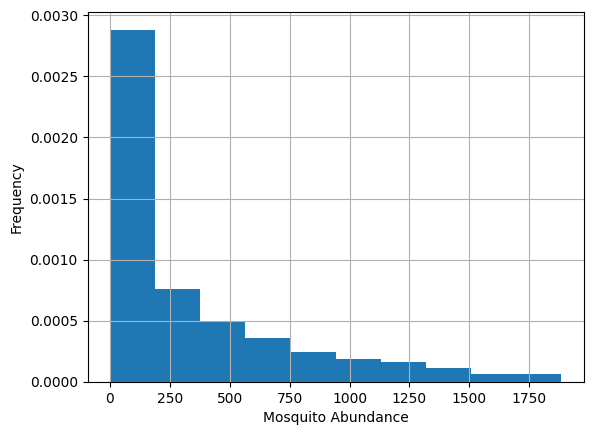

Mean: 502.6660516605166
Std: 987.0704208892562
Skewness: 5.722818344632069
kurtosis: 48.75707569713703
2021 number of observations: 126
2022 number of observations: 120
2023 number of observations: 61
All operational years observations: 307
Number of fixed traps: 49
Number of temporal traps: 93


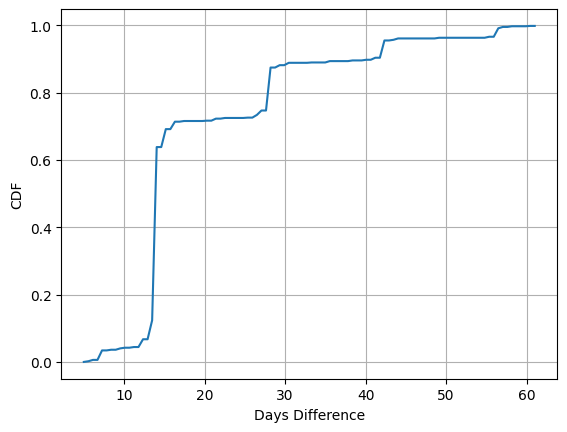

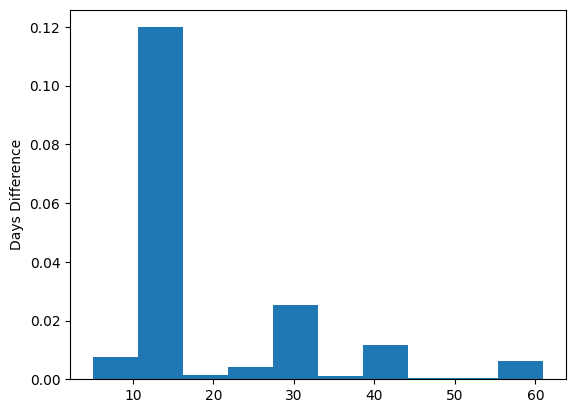

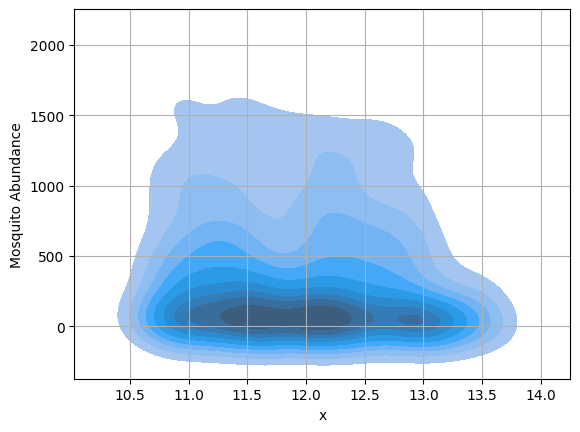

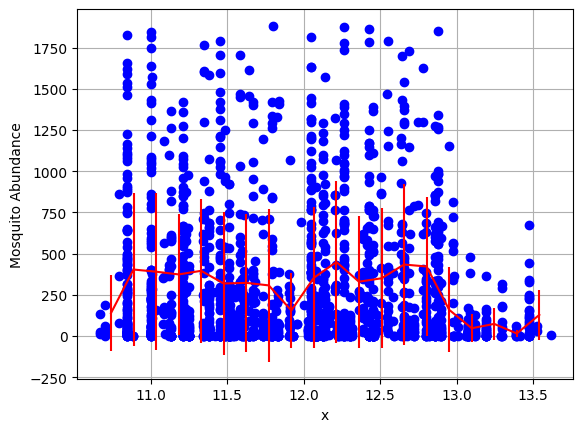

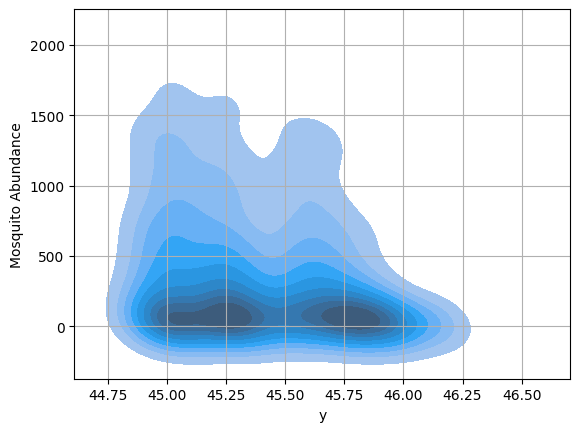

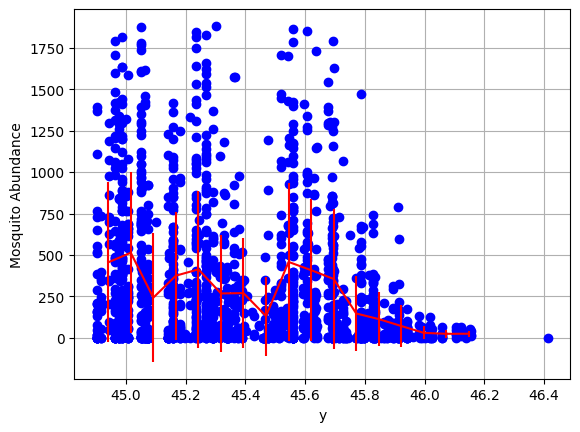

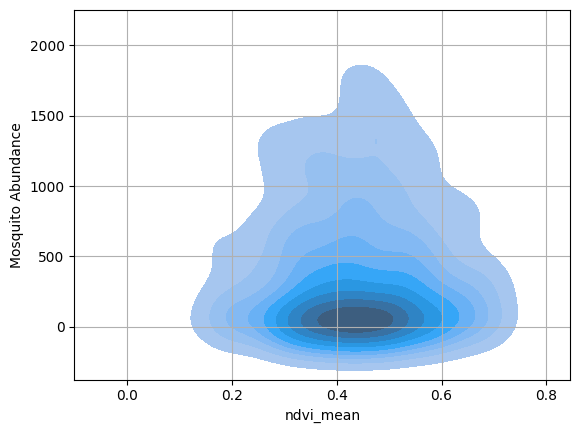

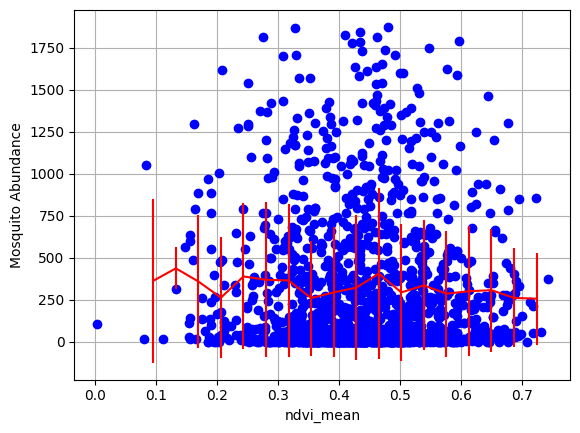

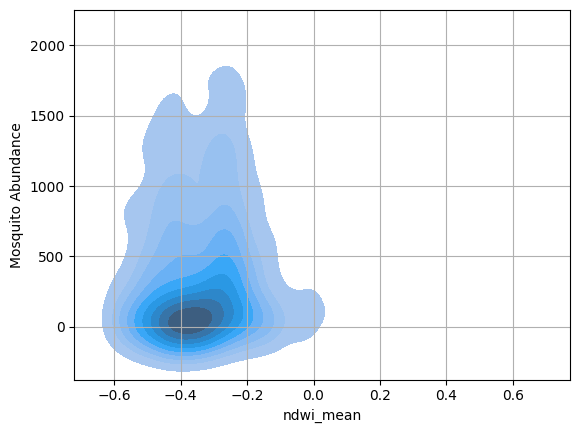

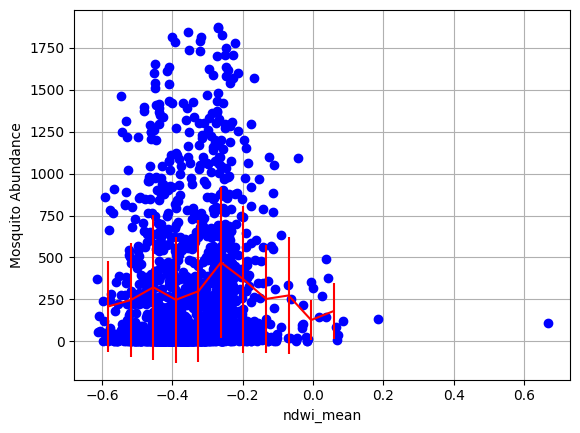

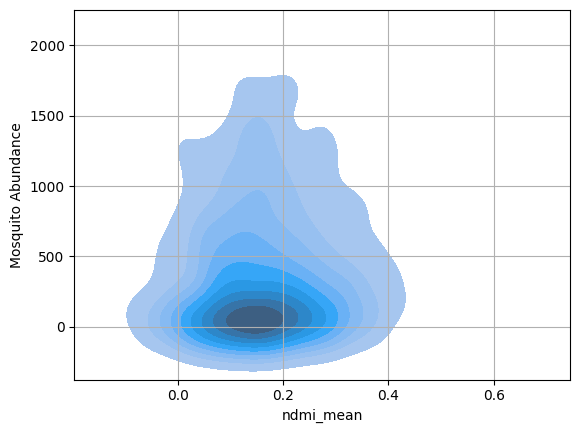

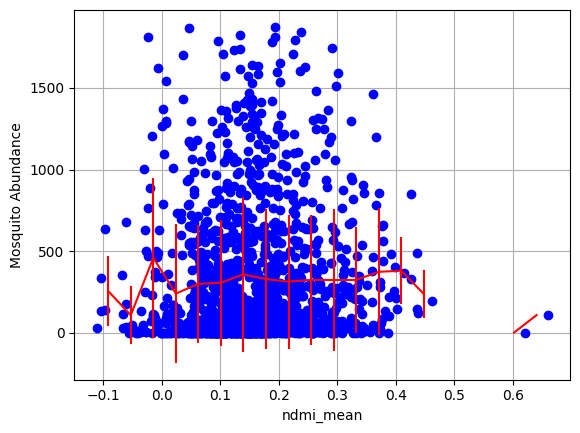

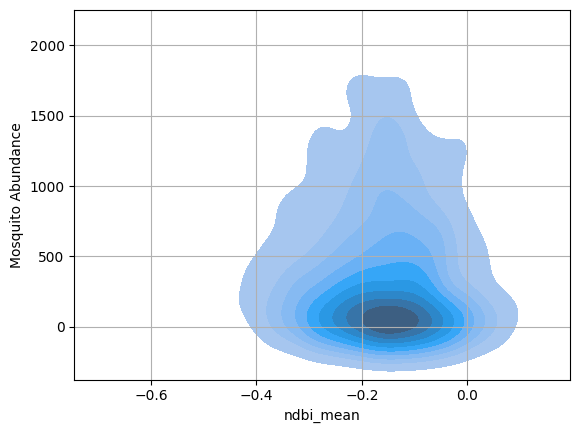

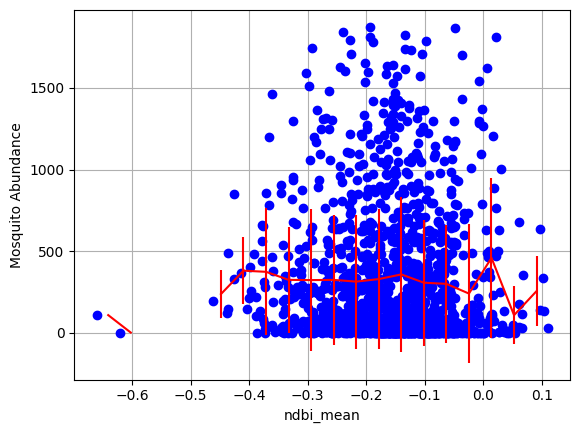

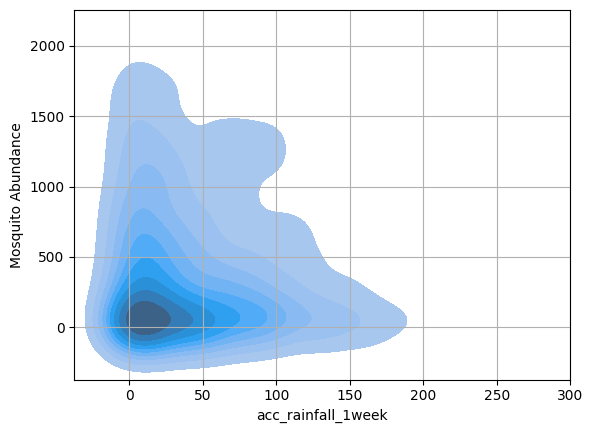

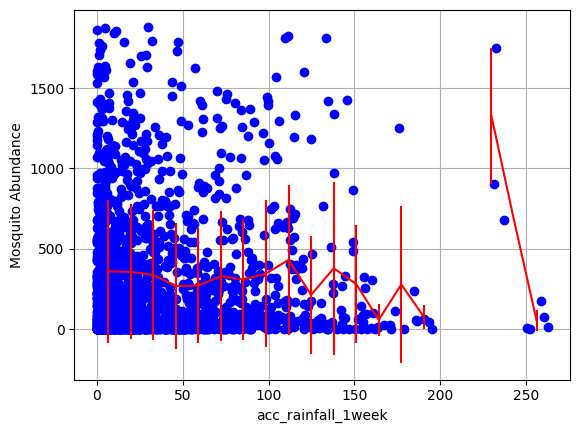

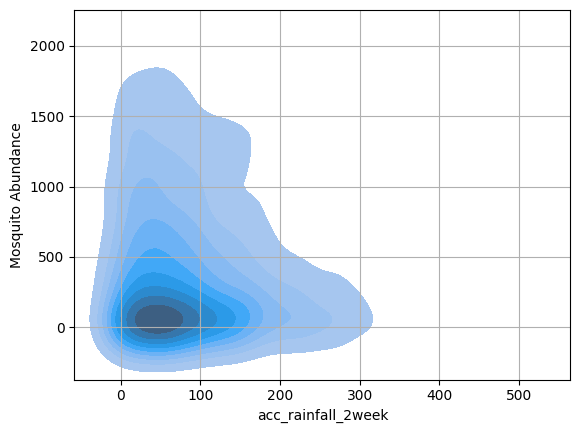

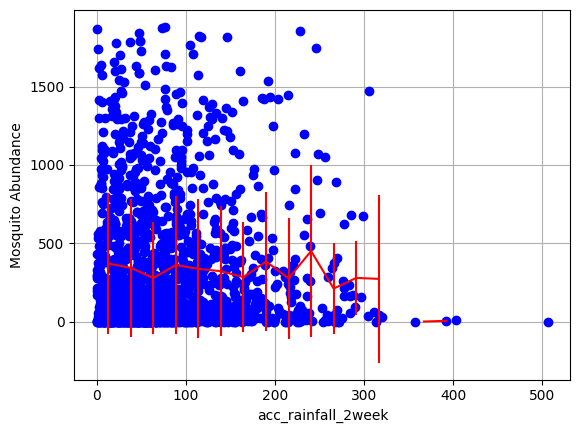

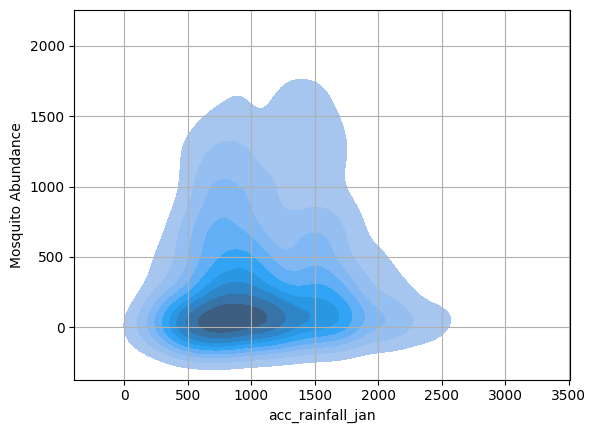

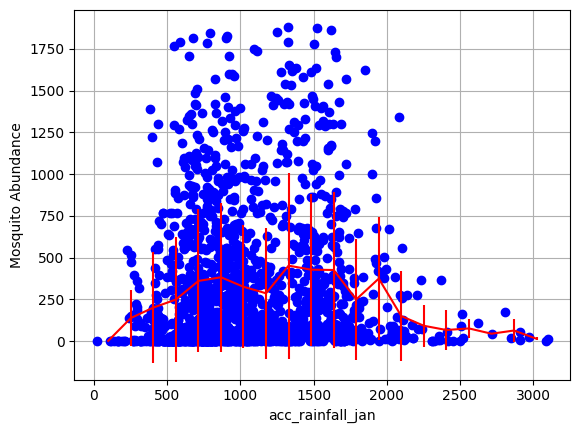

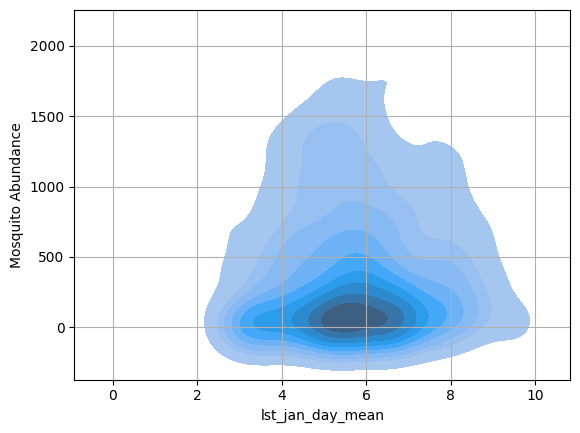

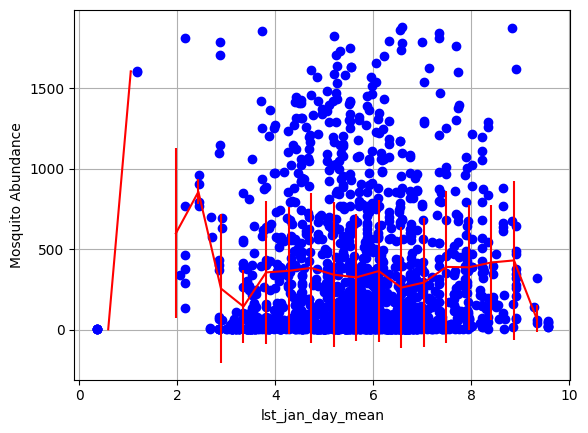

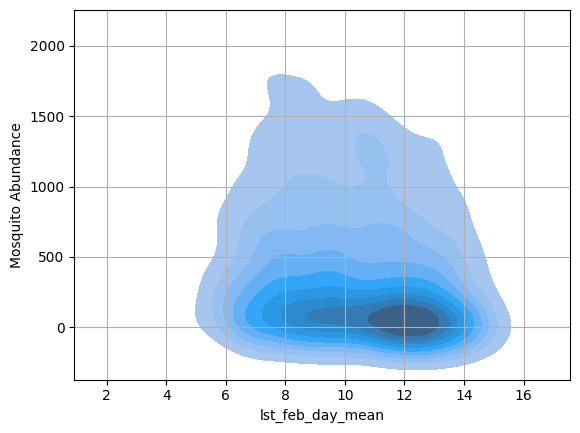

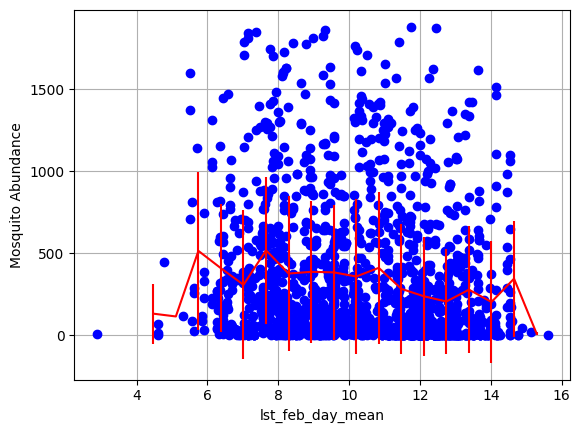

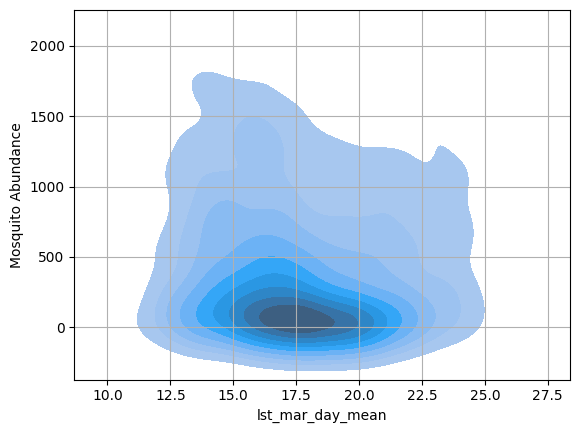

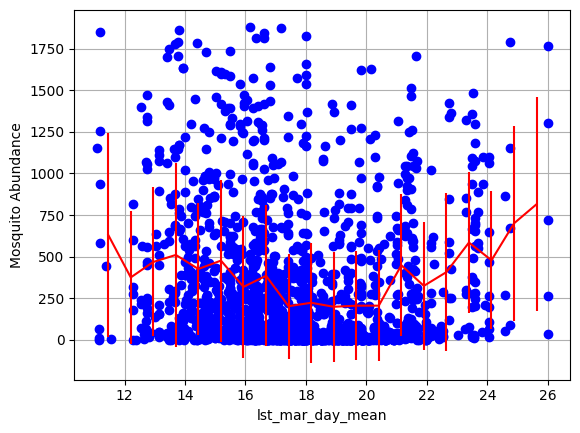

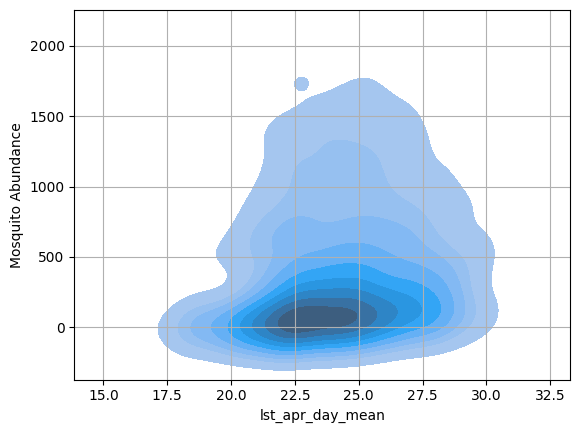

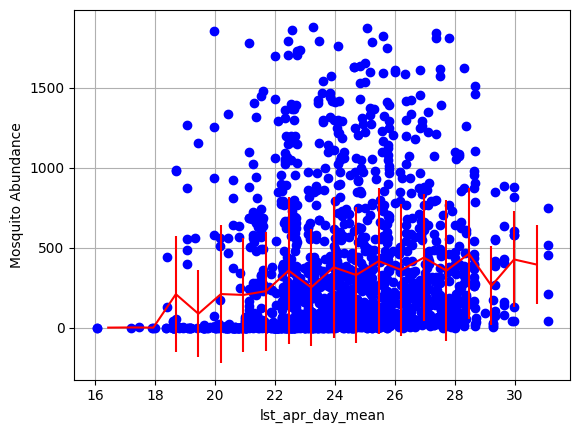

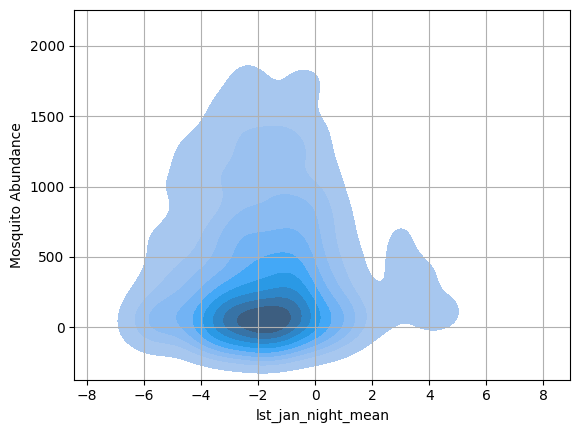

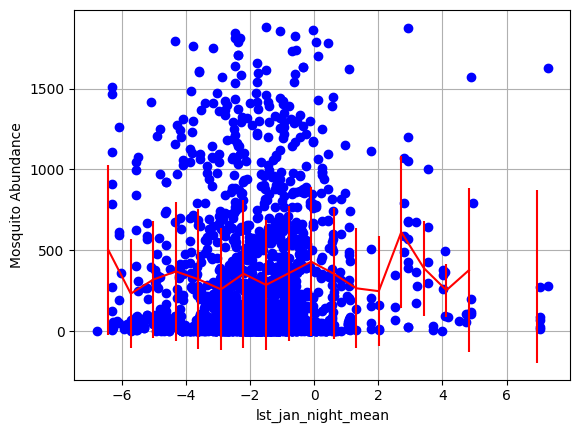

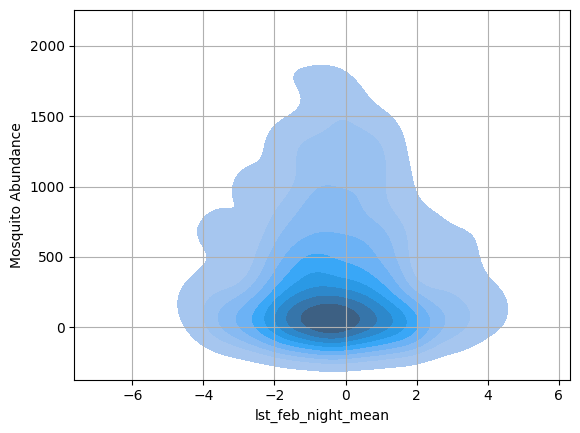

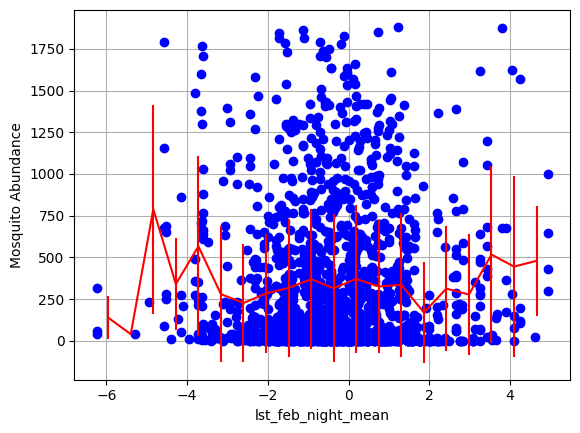

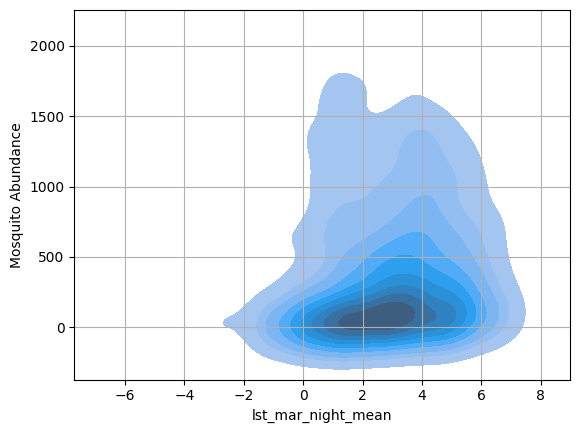

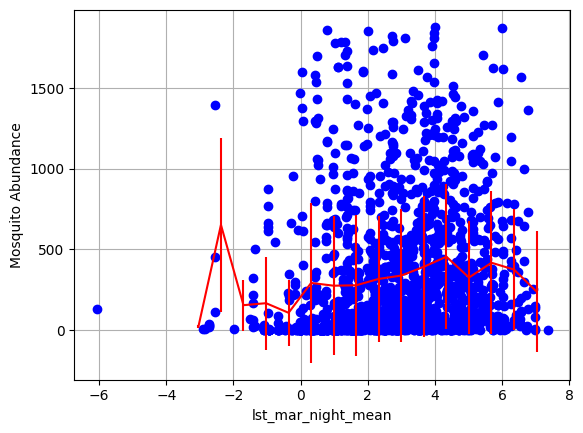

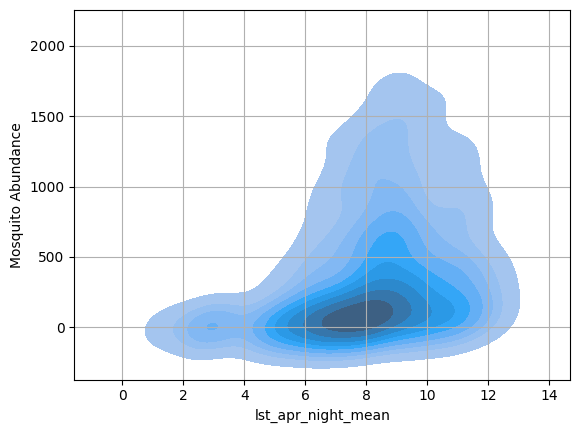

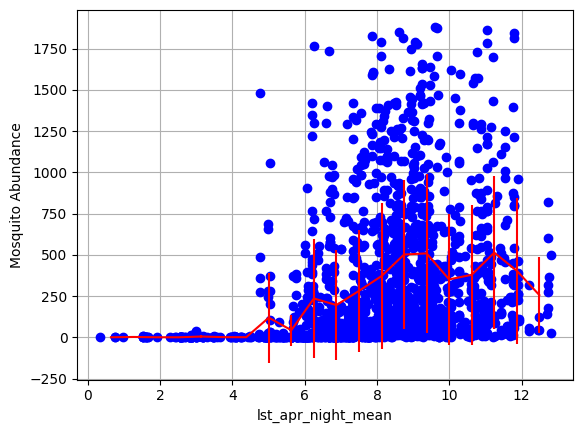

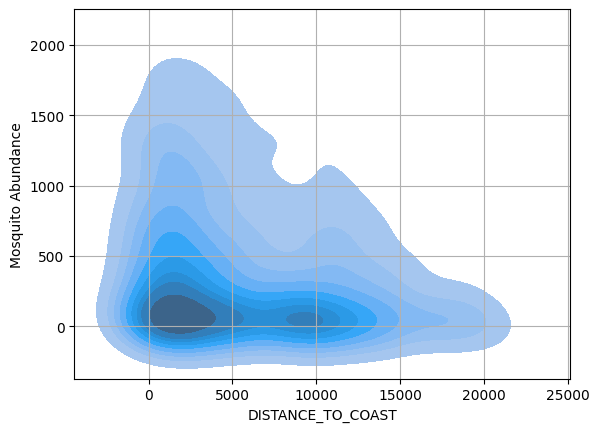

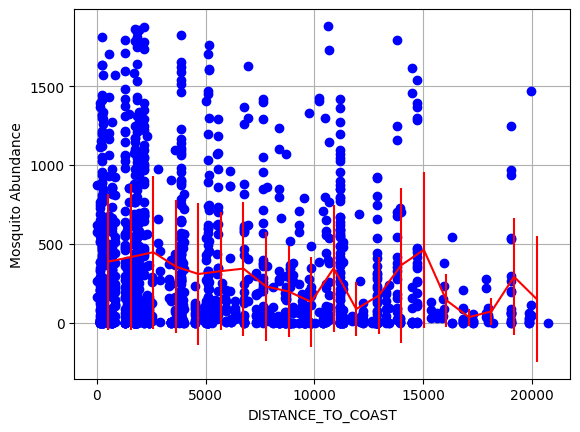

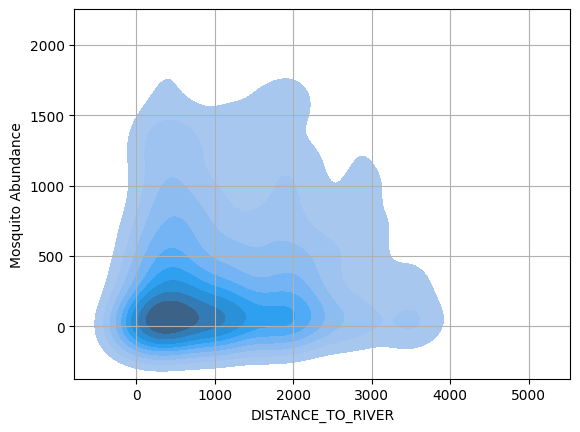

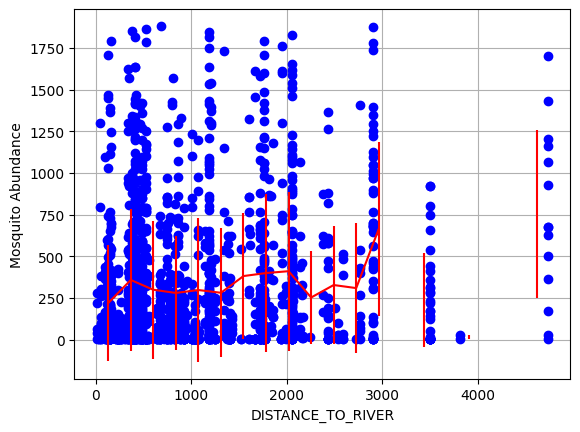

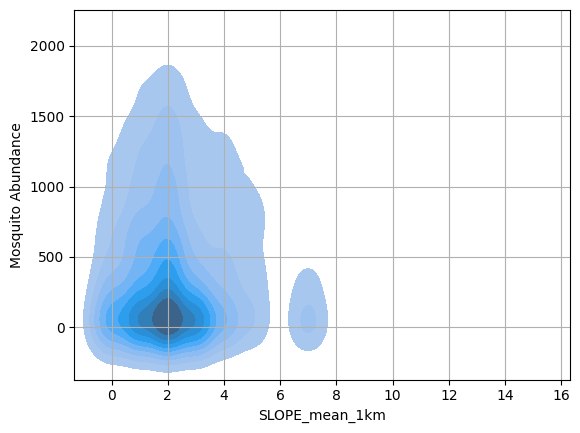

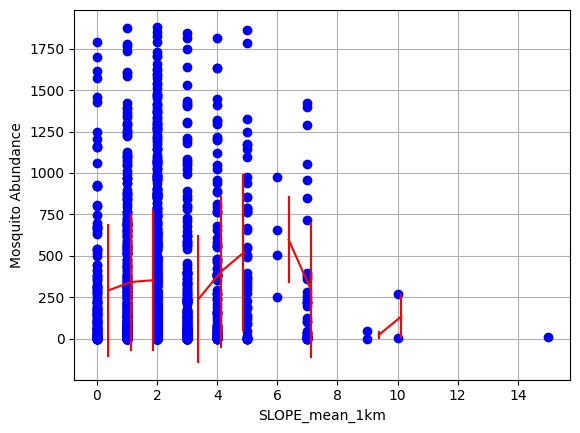

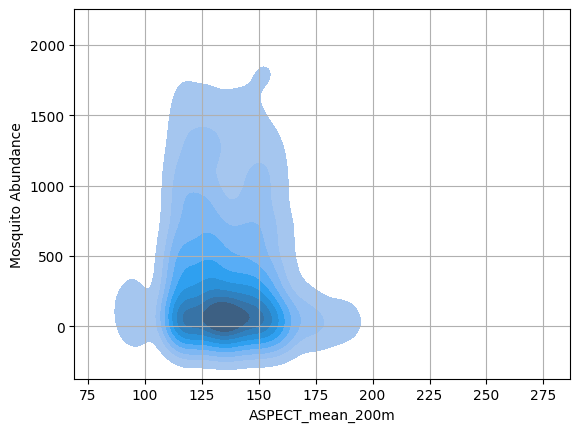

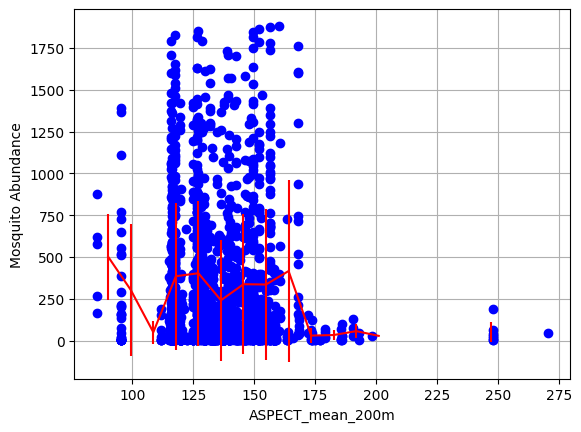

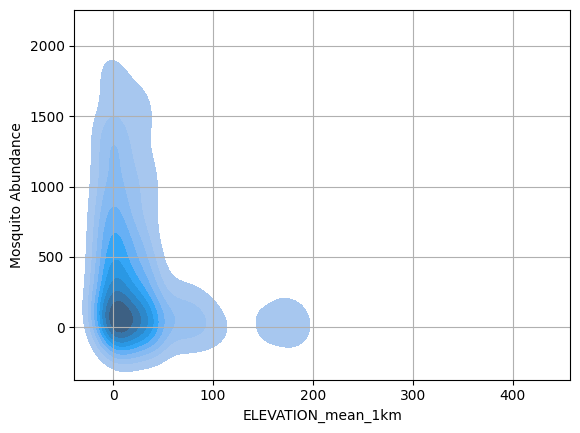

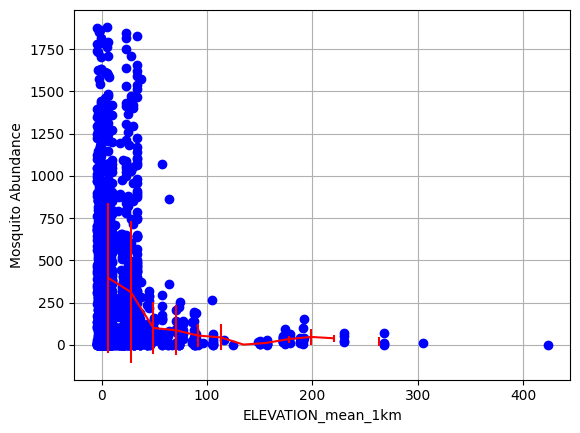

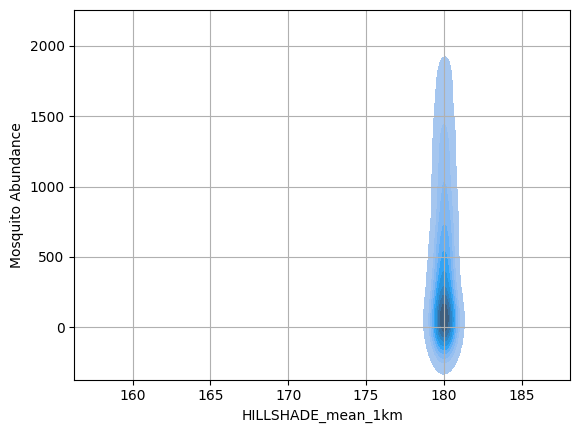

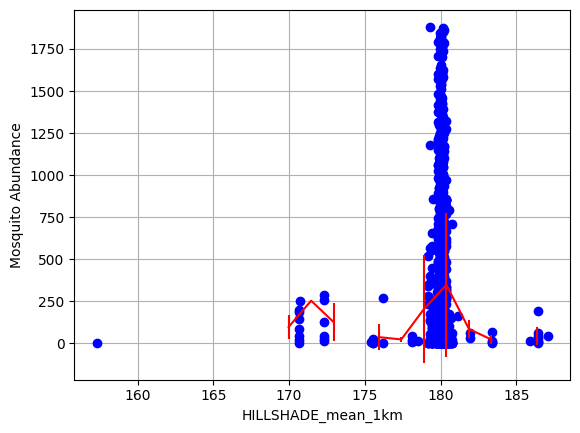

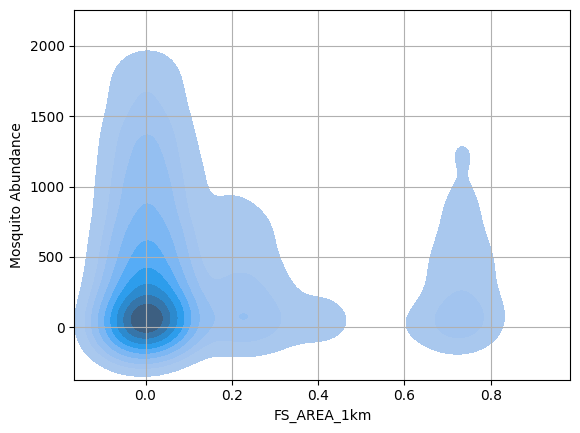

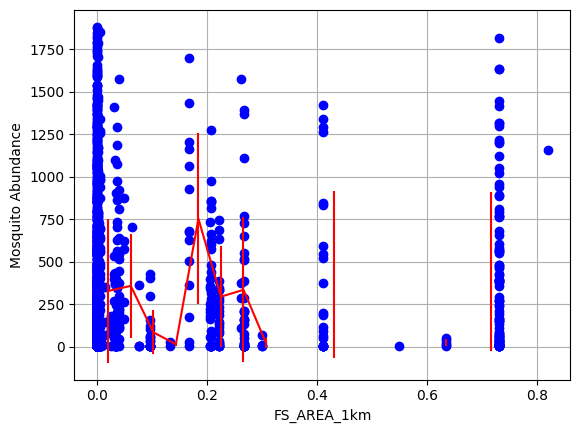

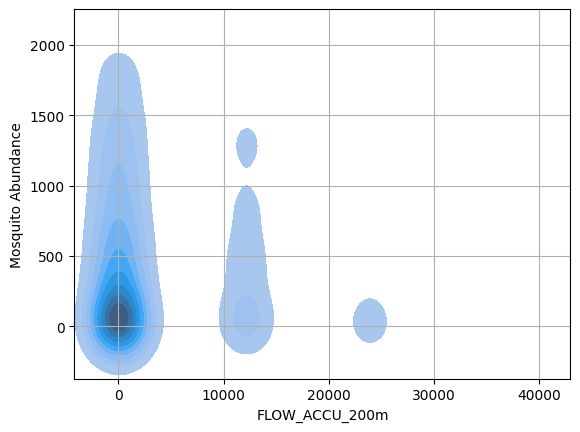

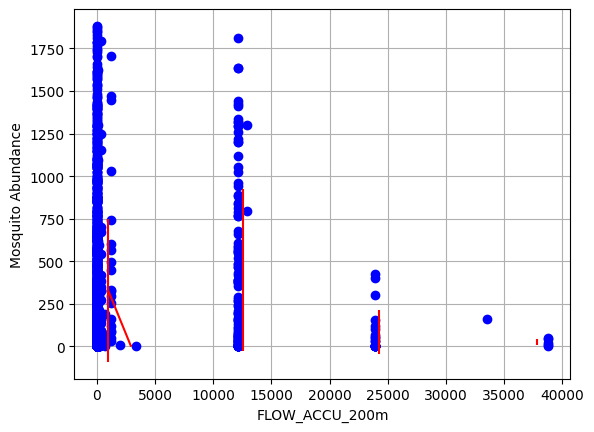

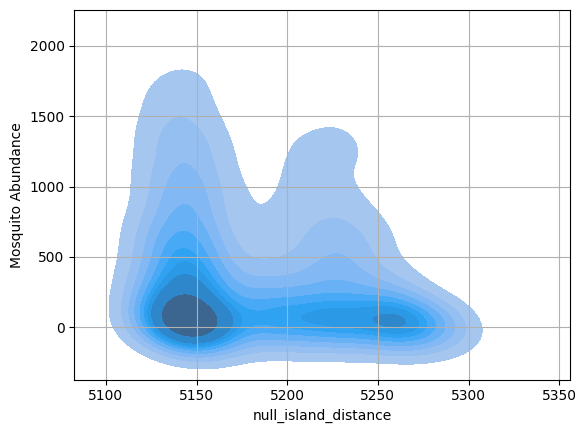

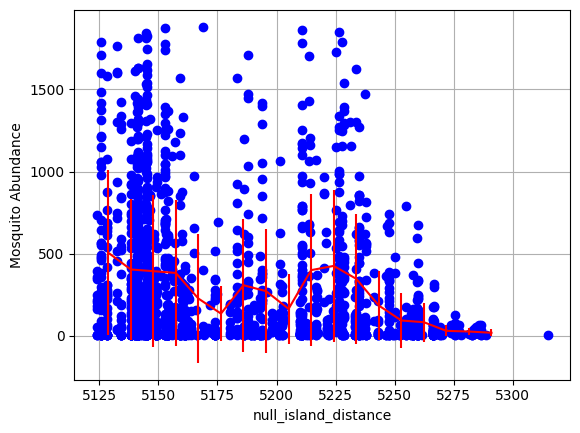

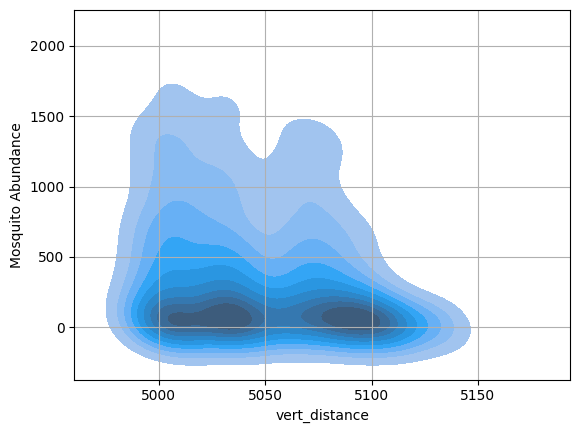

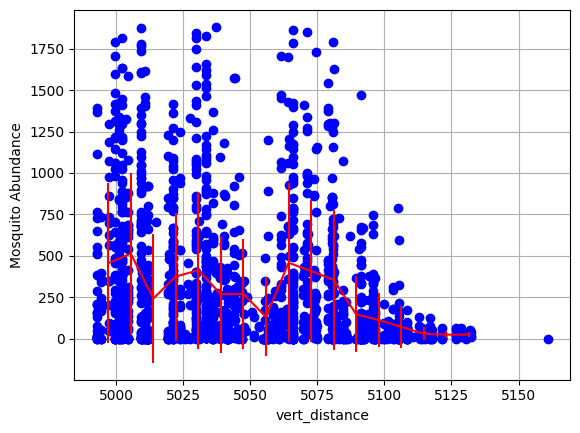

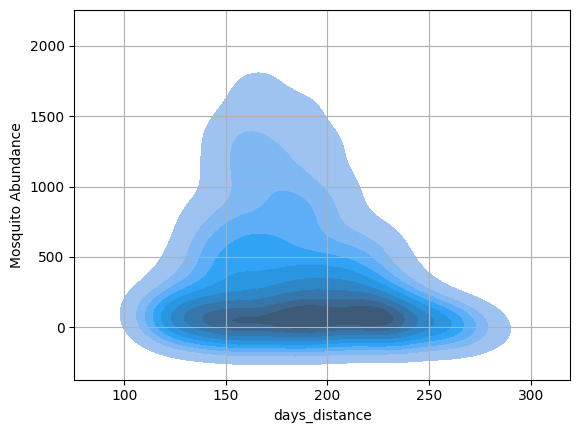

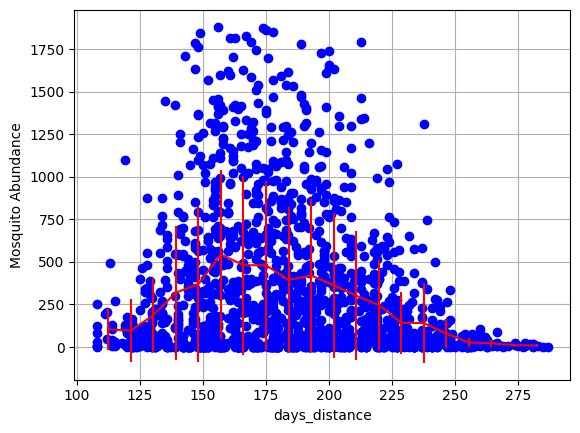

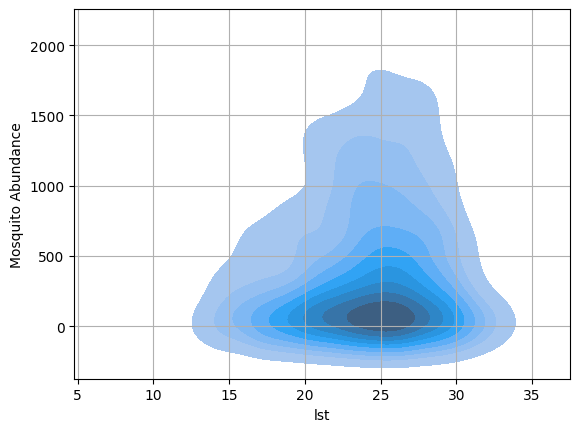

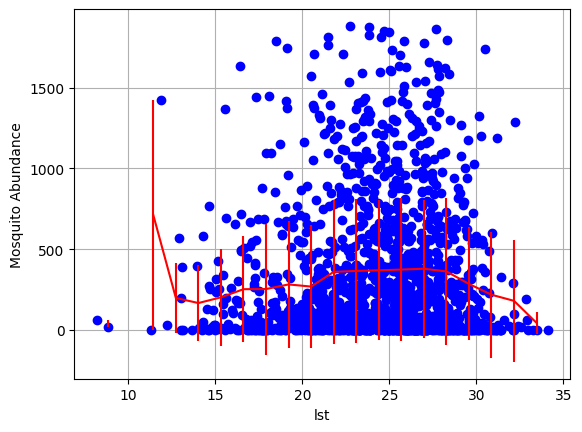

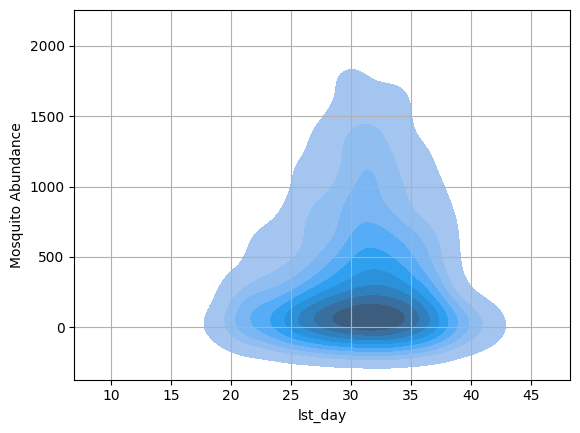

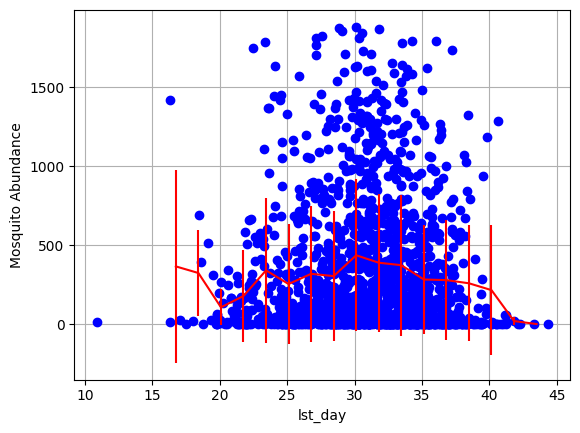

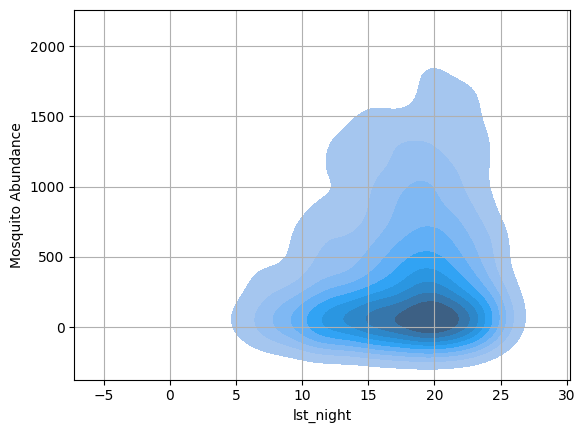

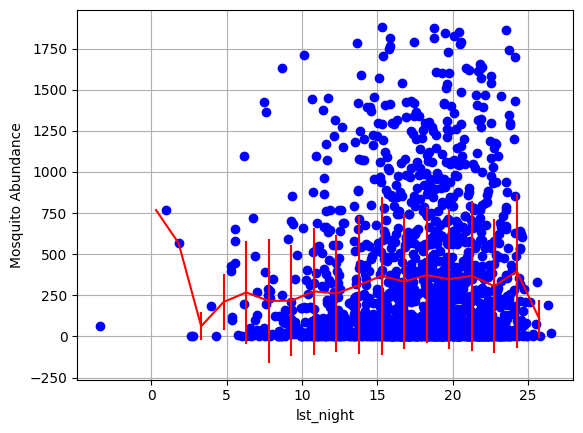

In [7]:
statistics(data)

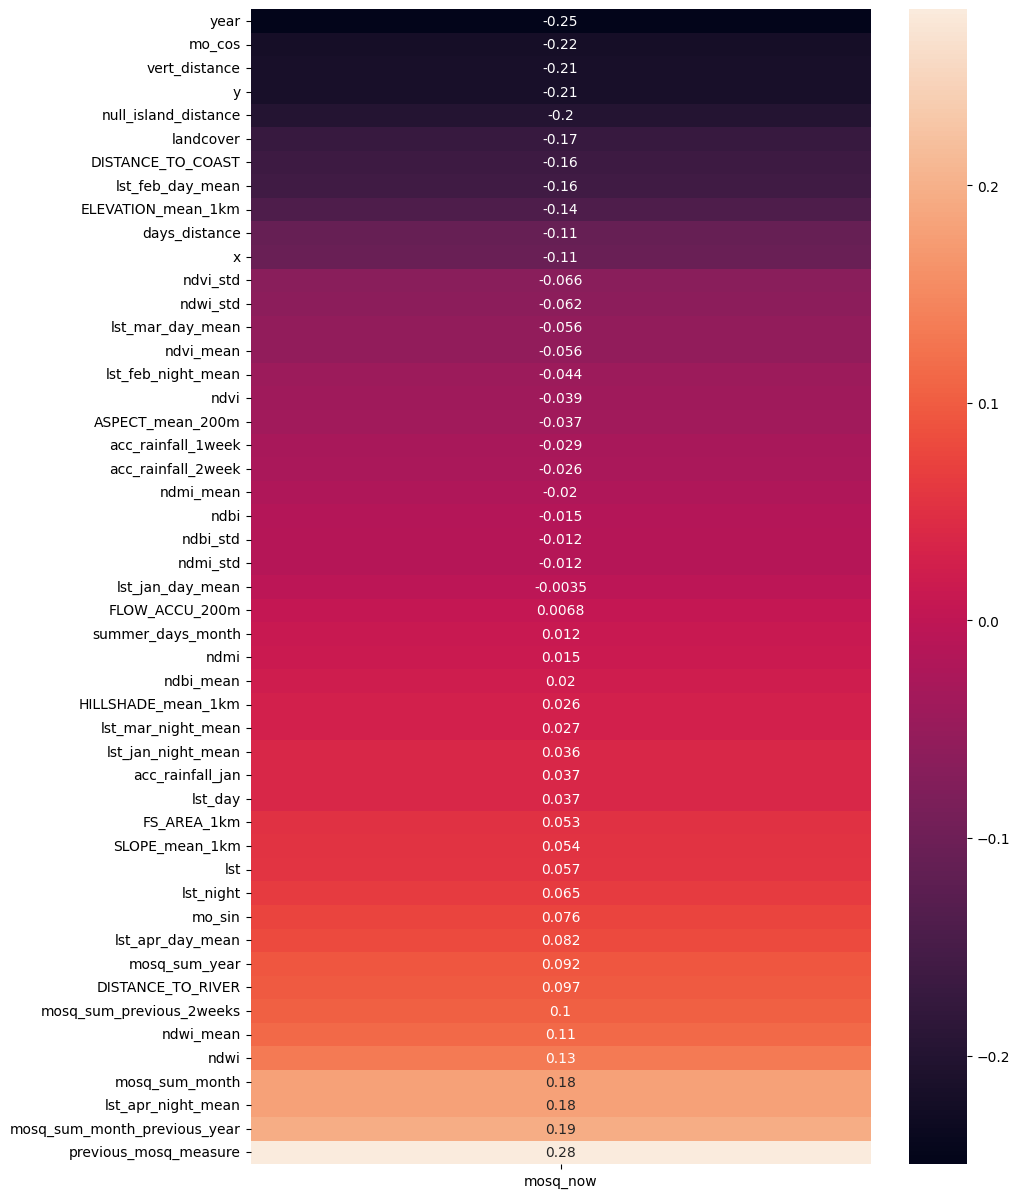

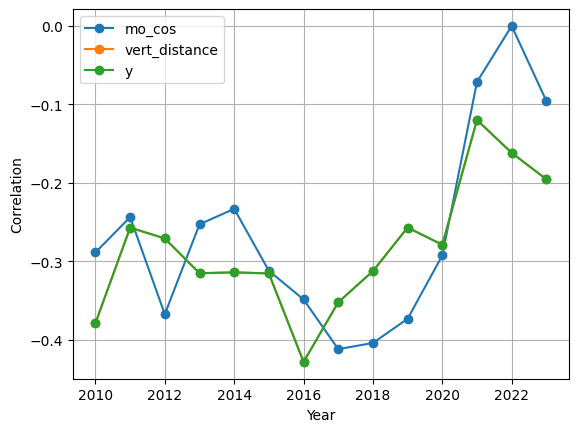

In [8]:
plot_correlations(data)

In [7]:
data = initializer(data, model_type, [-1., 2., 16., 48., 98., 195., 318., 500.8, 772.8, 1300.,  13398.], dropna=False)

Bounds: [   -1.      2.     16.     48.     98.    195.    318.    500.8   772.8
  1300.  13398. ]


In [10]:
data['mosq_now'].value_counts().sort_index()

mosq_now
0.0    232
1.0    142
2.0    158
3.0    156
4.0    156
5.0    157
6.0    155
7.0    157
8.0    157
9.0    156
Name: count, dtype: int64

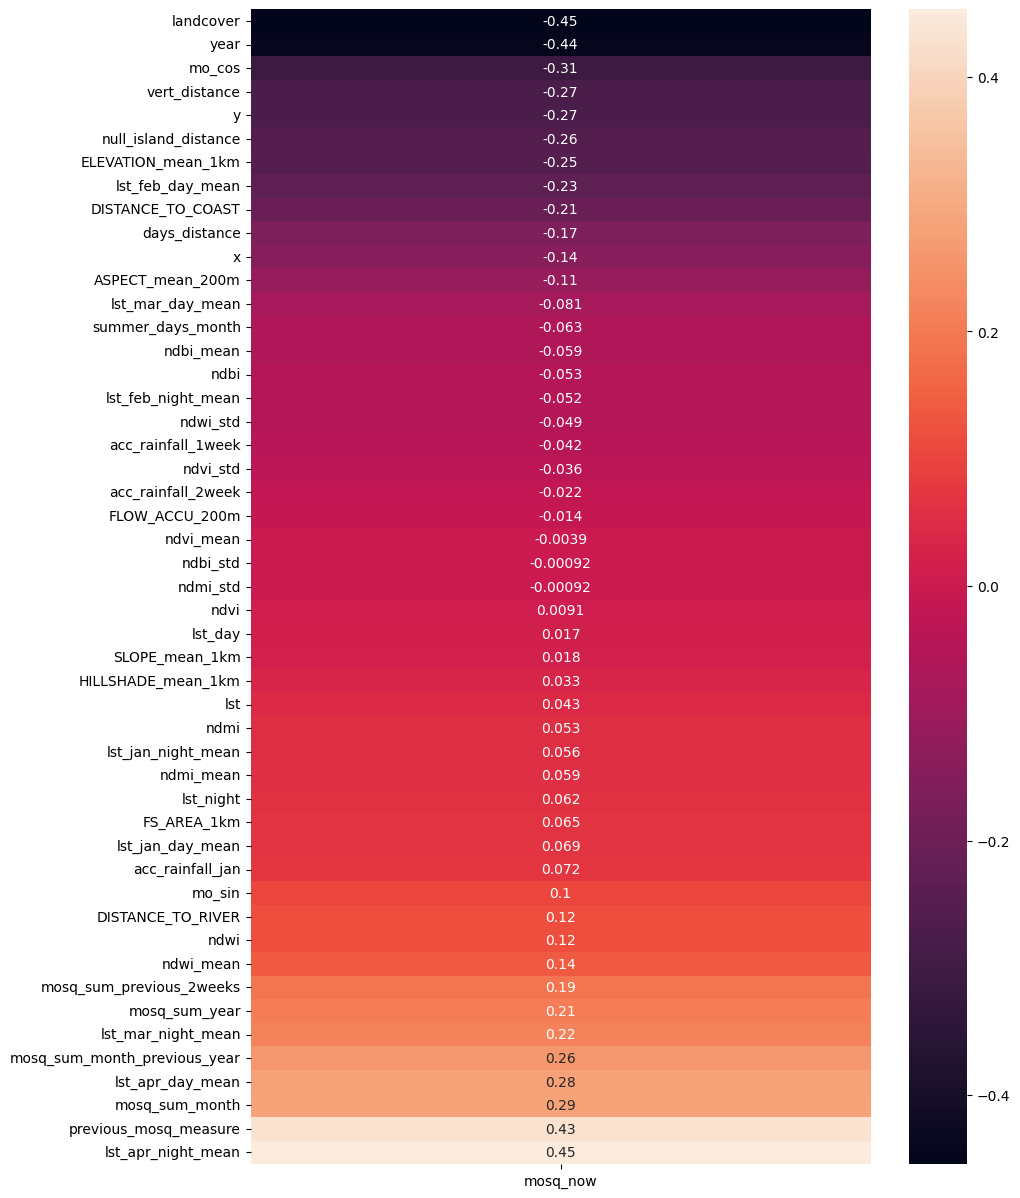

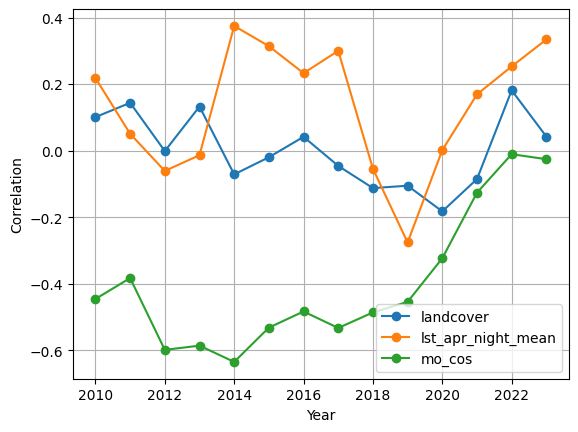

In [11]:
plot_correlations(data)

#===========================================
Predictions without entomological features
#===========================================



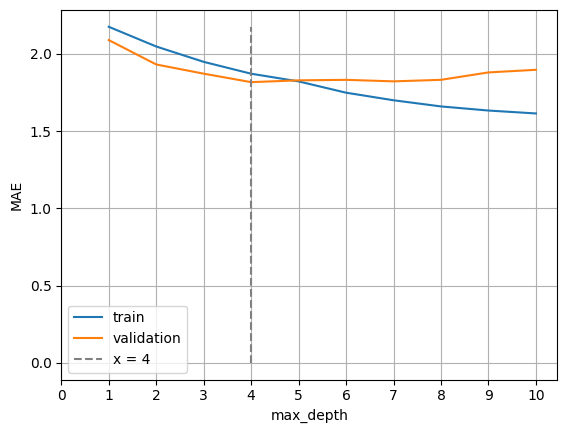

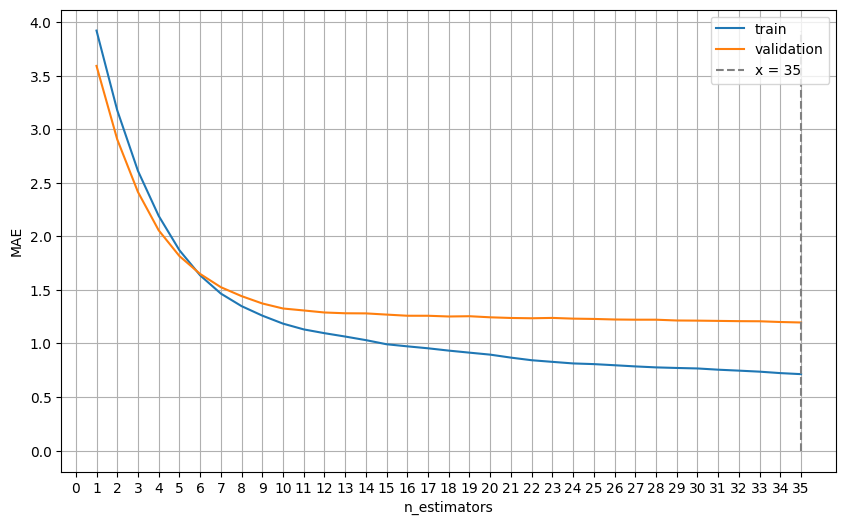

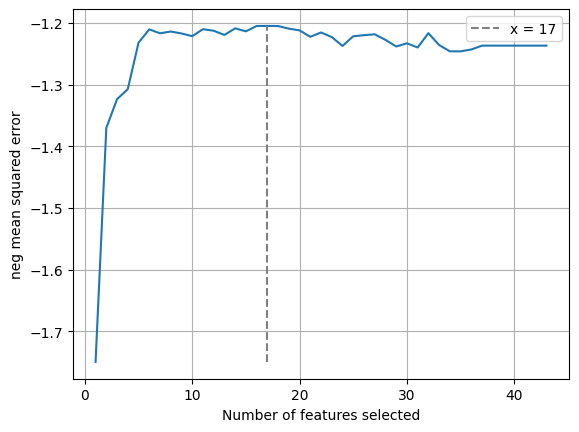

max_depth:  4
Number of estimators:  35
Selected_features:  Index(['y', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
       'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean',
       'lst_apr_night_mean', 'DISTANCE_TO_COAST', 'DISTANCE_TO_RIVER',
       'ASPECT_mean_200m', 'ELEVATION_mean_1km', 'HILLSHADE_mean_1km',
       'FLOW_ACCU_200m', 'null_island_distance', 'days_distance', 'mo_cos'],
      dtype='object')
prediction
1.0     4
2.0    28
3.0    53
4.0    56
5.0    39
6.0     4
Name: count, dtype: int64

Low risk category stations: 4
Medium risk category stations: 176
High risk category stations: 4
#===========================================
Predictions without entomological features
#===========================================

prediction
1.0     4
2.0    18
3.0    27
4.0    16
5.0    33
6.0    33
7.0     7
Name: count, dtype: int64

Low risk category stations: 4
Medium risk category stations: 94
High risk category stations: 40
#=====================

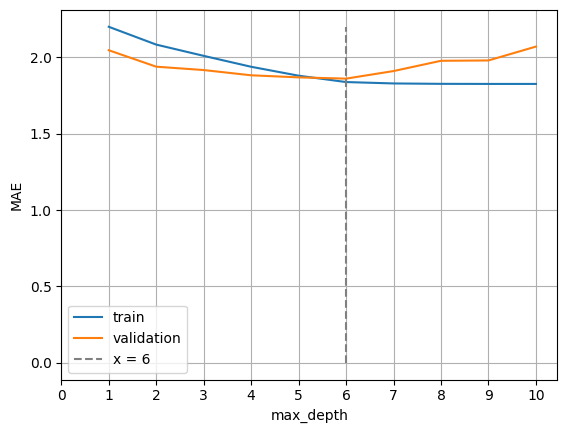

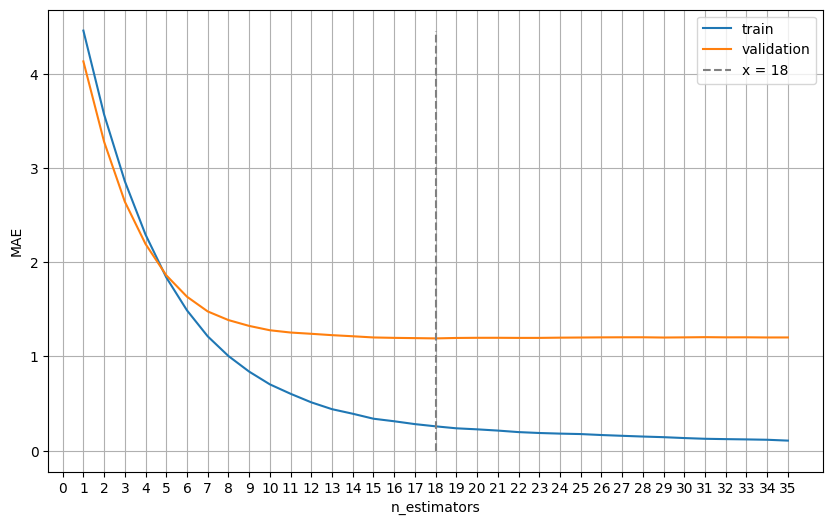

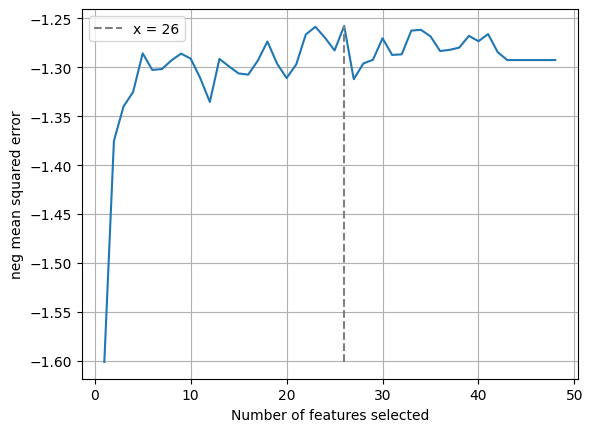

max_depth:  6
Number of estimators:  18
Selected_features:  Index(['ndmi_std', 'lst_night', 'acc_rainfall_1week', 'acc_rainfall_2week',
       'acc_rainfall_jan', 'lst_jan_day_mean', 'lst_feb_day_mean',
       'lst_mar_day_mean', 'lst_apr_day_mean', 'lst_jan_night_mean',
       'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean',
       'DISTANCE_TO_COAST', 'DISTANCE_TO_RIVER', 'ASPECT_mean_200m',
       'ELEVATION_mean_1km', 'HILLSHADE_mean_1km', 'FLOW_ACCU_200m',
       'null_island_distance', 'days_distance', 'mosq_sum_month',
       'mosq_sum_month_previous_year', 'mosq_sum_year',
       'mosq_sum_previous_2weeks', 'previous_mosq_measure'],
      dtype='object')
prediction
3.0    1
4.0    6
6.0    2
7.0    2
8.0    3
Name: count, dtype: int64

Low risk category stations: 0
Medium risk category stations: 7
High risk category stations: 7
#===========================================
Predictions without entomological features
#===========================================

p

prediction
0.0    1
1.0    2
Name: count, dtype: int64

Low risk category stations: 3
Medium risk category stations: 0
High risk category stations: 0
#===========================================
Predictions without entomological features
#===========================================

prediction
0.0     531
1.0    1061
2.0    1232
3.0    1096
4.0     817
5.0     344
6.0     106
7.0      30
8.0       1
Name: count, dtype: int64

Low risk category stations: 1592
Medium risk category stations: 3489
High risk category stations: 137
#===========================================
Predictions with entomological features
#===========================================

prediction
5.0    2
6.0    1
Name: count, dtype: int64

Low risk category stations: 0
Medium risk category stations: 2
High risk category stations: 1
prediction
2.0    3
Name: count, dtype: int64

Low risk category stations: 0
Medium risk category stations: 3
High risk category stations: 0
#===========================================
P

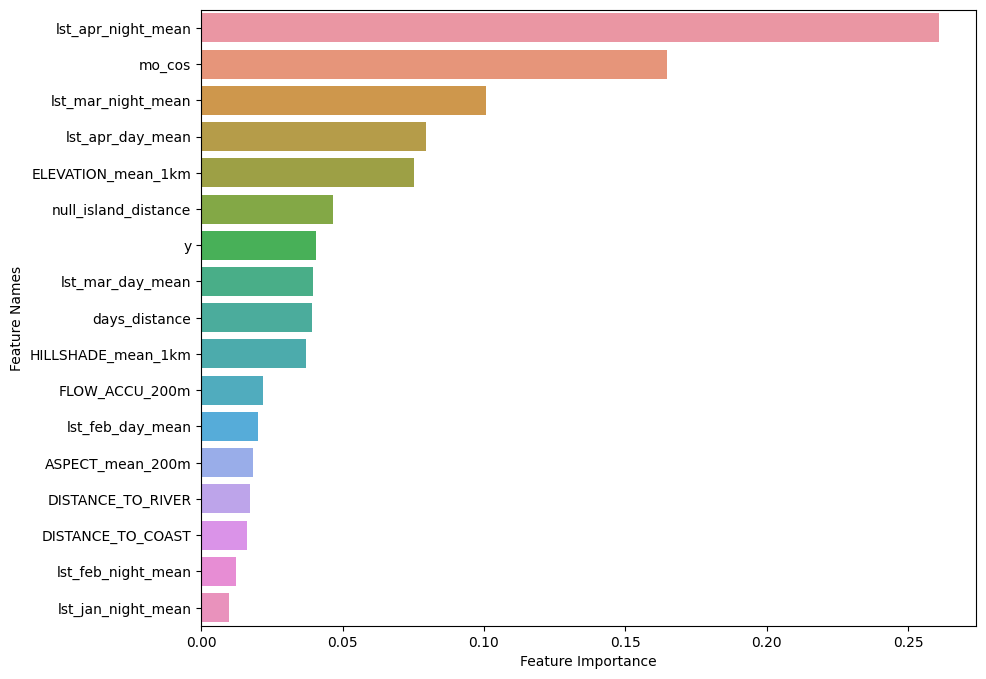

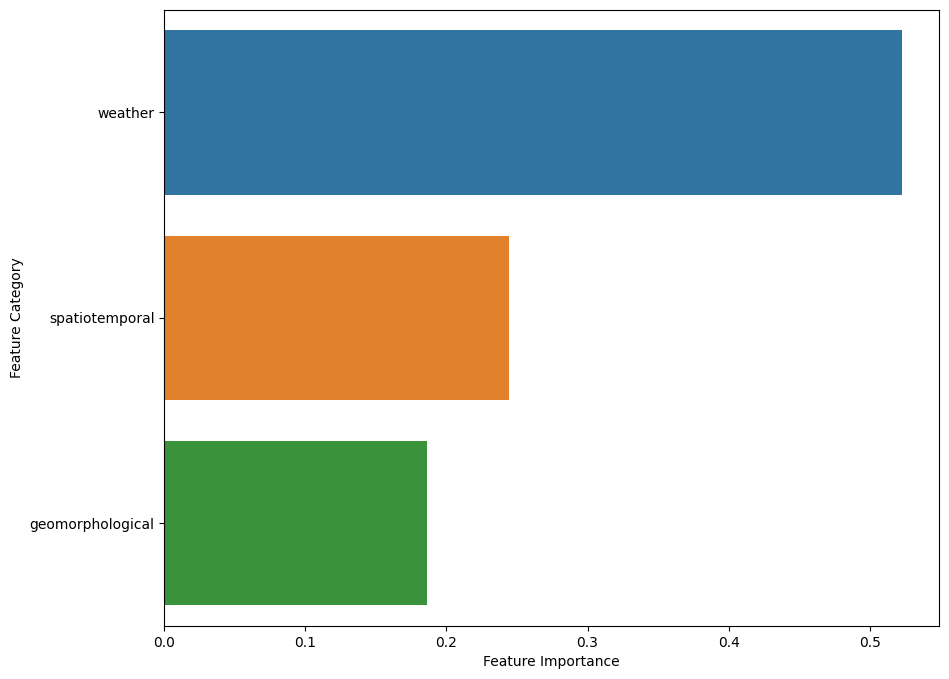

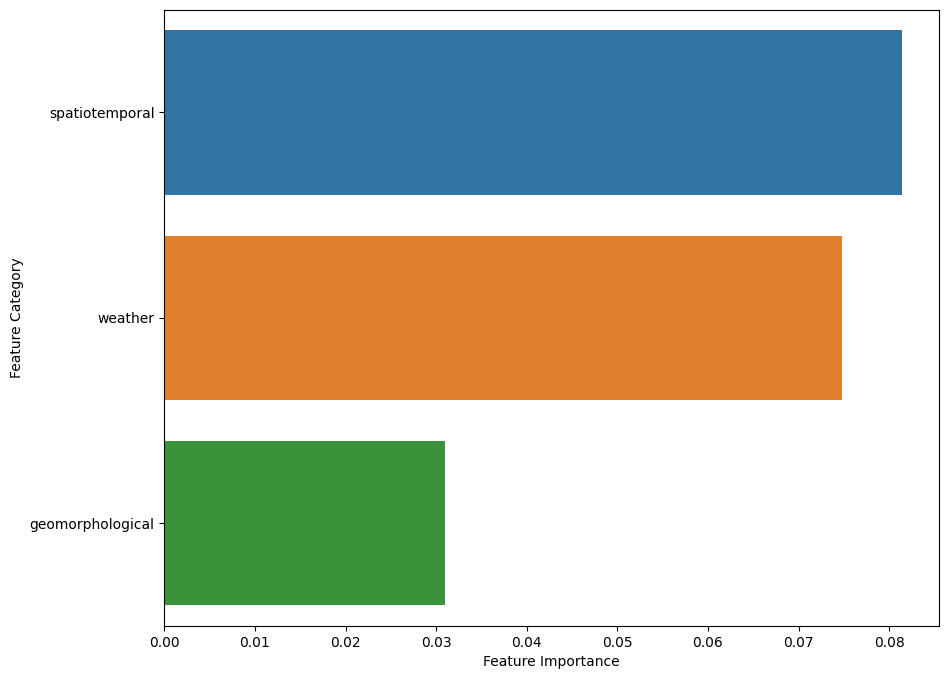

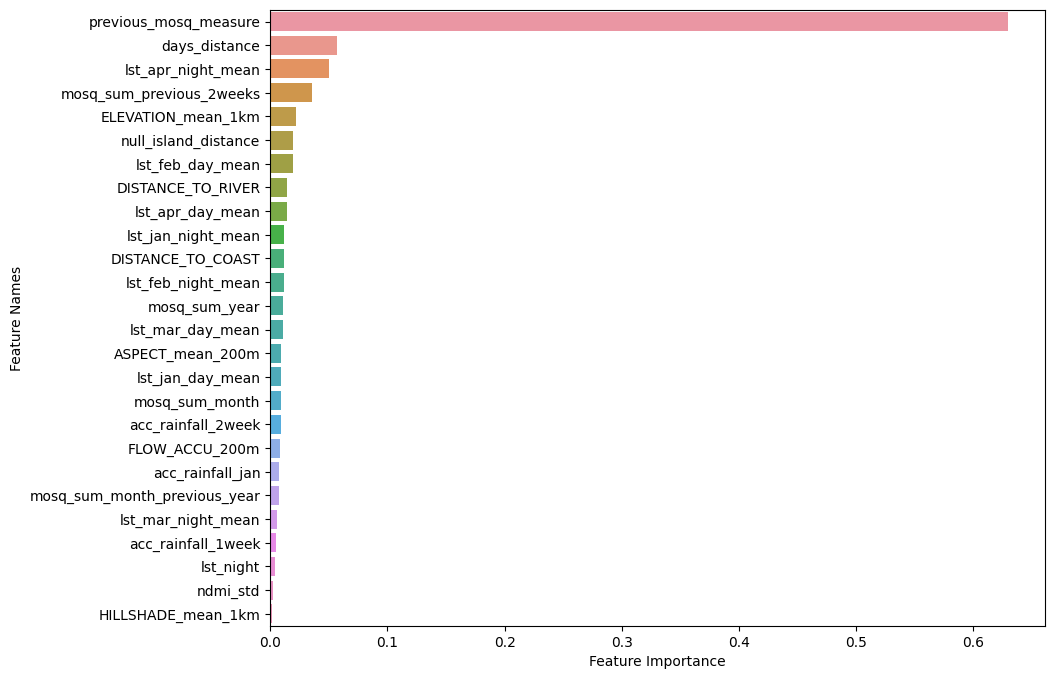

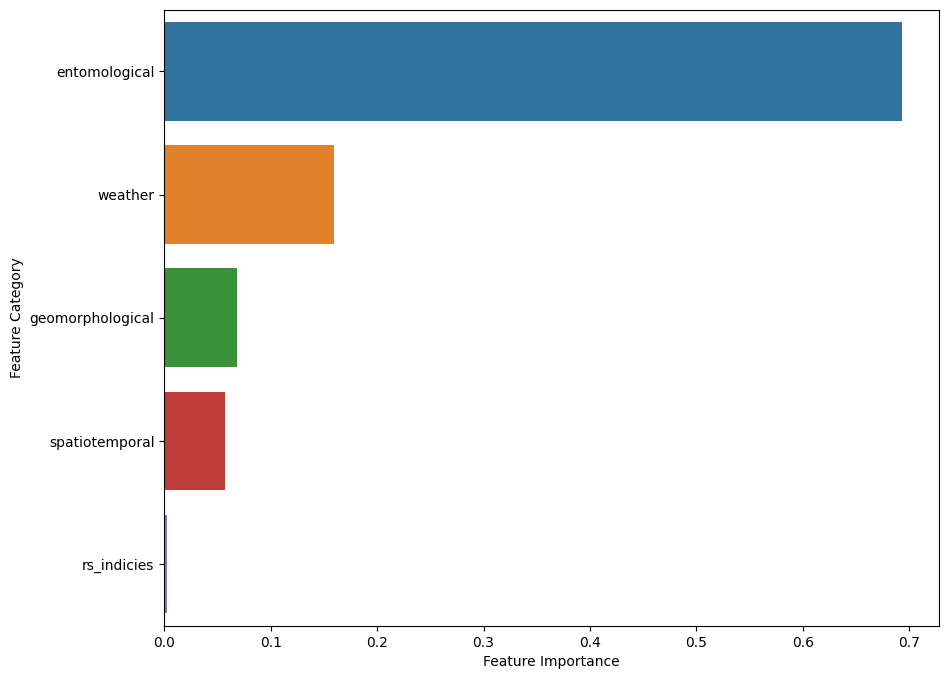

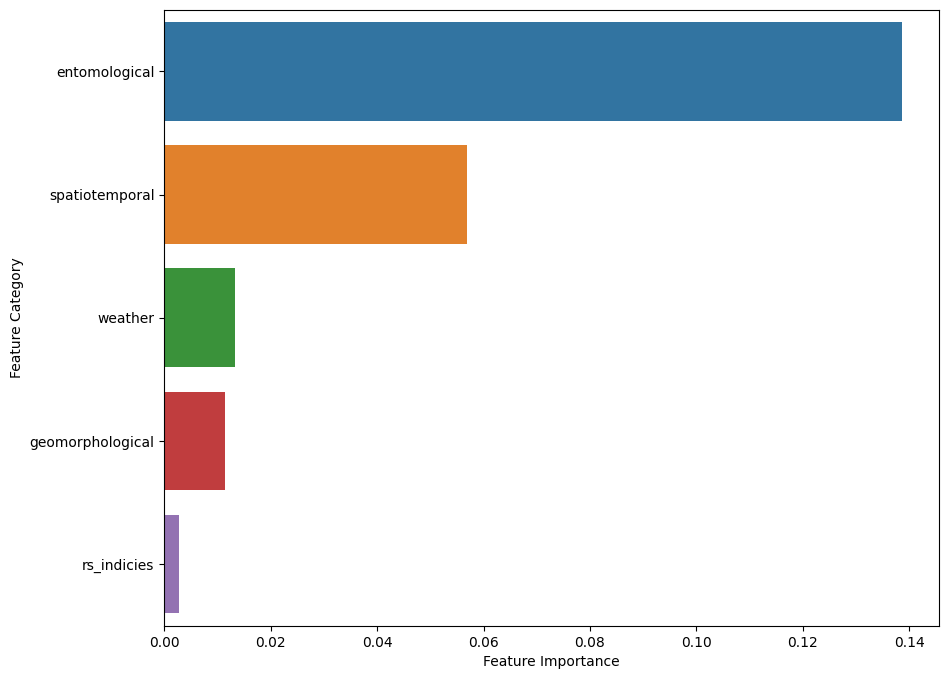

In [12]:
del data['year']
#=====================================================================
# Automation models without or with/without entomological data
#=====================================================================
learning_rate = 0.2
# set the early stop argument as early_stop = (tolerance, min_delta)
early_stop = None
#set the transformation actions on the data. Options are 'augmentation', 'normalization', 'log', 'scaling'
transformation_list = []
#set the data for embeddings e.g. data[['col', 'col2']]
embedded_data = None
#set the boolean for plotting feature importance
fi = False

exp=False

model_ent = Xgboost_model(model_type = model_type, learning_rate = learning_rate,
                          embedding_data = embedded_data,  transformation_list = transformation_list,
                          early_stop = False, l1_weight = 0, l2_weight = 0, weights = False)

model_env = Xgboost_model(model_type = model_type, learning_rate = learning_rate,
                          embedding_data = embedded_data,  transformation_list = transformation_list,
                          early_stop = False, l1_weight = 0, l2_weight = 0, weights = False)

predictions = pd.DataFrame()
ent_predictions_env_model = pd.DataFrame()

date = '2021-01-01'
months = data.loc[data['dt_placement']>=pd.to_datetime(date),'dt_placement'].dt.to_period('M').unique()
months = months.strftime('%Y-%m')
months.sort()

for i in months:
    date1 = i +'-01'
    if i.split('-')[1]=='12':
        date2 = str(int(i.split('-')[0])+1) +'-01-01'
    else:
        date2 = i.split('-')[0] + '-' + str(int(i.split('-')[1]) + 1) + '-01'
        
    train = data.loc[data[date_col] < pd.to_datetime(date1)]
    train = train.reset_index(drop=True)
    
    test = data.loc[data[date_col] >= pd.to_datetime(date1)]
    test = test.loc[test[date_col] < pd.to_datetime(date2)]
    test = test.reset_index(drop=True)

    # set the only_env as True if there are no mosquitoes for the forecast month
    only_env=None    
    if len(test.dropna(subset=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                               'mosq_sum_previous_2weeks','previous_mosq_measure']).drop(columns=['mosq_now']).dropna())>0:
        only_env=False
    elif len(test.drop(columns=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                               'mosq_sum_previous_2weeks', 'previous_mosq_measure', 'mosq_now']).dropna())>0:
        only_env=True
    else:
        print('No data left for prediction')

    if only_env != None:
        # Run first without entomological features
        print("#===========================================")
        print("Predictions without entomological features")
        print("#===========================================")
        print()
        data_env = train.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                              'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)
        test_env = test.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                              'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)

        data_env = data_env.dropna().reset_index(drop=True)
        test_env = test_env.dropna(subset=test_env.columns.difference(['mosq_now'])).reset_index(drop=True)
        
        if len(test_env)!=0:
            predictions_env = give_predictions_xgboost(model_env, data_env, test_env, env = True,
                                                       filepath = path, case = '', fi = fi, export = False)
            predictions = pd.concat([predictions,predictions_env],axis=0)


        # Run with entomological features if at least one station has mosquitos number
        if not only_env:
            print("#===========================================")
            print("Predictions with entomological features")
            print("#===========================================")
            print()

            data_entom = train.dropna().reset_index(drop=True)
            test_entom = test.dropna(subset=test.columns.difference(['mosq_now'])).reset_index(drop=True)
            
            if len(test_entom)!=0:
            
                predictions2 = give_predictions_xgboost(model_env, data_entom, test_entom, env = True,
                                                        filepath = path, case = '', fi = fi, export = False)
                
                predictions_entom = give_predictions_xgboost(model_ent, data_entom, test_entom, env = False,
                                                             filepath = path, fi = fi, case = '', export = False)
                
                predictions = pd.concat([predictions,predictions_entom],axis=0)
                
                ent_predictions_env_model = pd.concat([ent_predictions_env_model,predictions2],axis=0)
                ent_predictions_env_model = pd.concat([ent_predictions_env_model,predictions_entom],axis=0)
                
model_env.plot_feature_importance()
model_ent.plot_feature_importance()

predictions = predictions.sort_values(['entomological_features'], ascending=False).reset_index(drop=True)
predictions = predictions.drop_duplicates(subset=['dt_placement', 'x', 'y'], keep='first').reset_index(drop=True)
predictions = predictions.drop_duplicates(subset=['week', 'x', 'y'], keep='first').reset_index(drop=True)

ent_predictions_env_model = ent_predictions_env_model.reset_index(drop=True)

predictions = validate_results2(predictions, data)
ent_predictions_env_model = validate_results2(ent_predictions_env_model, data)

if exp:
    csv_name =  path +'overall_predictions.csv'
    predictions.to_csv(csv_name,index=False)
    csv_name =  path +'overall_predictions_ent_with_env_model.csv'
    ent_predictions_env_model.to_csv(csv_name,index=False)

In [13]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import statsmodels.api as sm
import pandas as pd
import numpy as np
import math
import seaborn as sns
import shap

In [14]:
def shap_explanations(predictions, model):
    
    explainer = shap.TreeExplainer(model.model)
    shap_values = explainer.shap_values(predictions[model.features].dropna())
    
    plt.figure()
    shap.summary_plot(shap_values, features=predictions[model.features].dropna(), 
                          feature_names=model.features, show=False, plot_type="violin")
    plt.show()
    
    plt.figure()
    shap.summary_plot(shap_values, features=predictions[model.features].dropna(), 
                          feature_names=model.features, show=False, plot_type='bar')
    plt.show()

    months = {4:'April',
              5:'May',
              6:'June',
              7:'July',
              8:'August',
              9:'September',
              10:'October'}
    k=1
    for i in [5,6,7,8,9]:
        plt.figure()
        predictions_month = predictions[predictions['dt_placement'].dt.month==i]
        shap_values = explainer.shap_values(predictions_month[model.features].dropna())
        shap.summary_plot(shap_values, features=predictions_month[model.features].dropna(), 
                          feature_names=model.features,max_display=5,show=False, plot_type="violin")
        plt.title(months[i])
        plt.show()
        
        plt.figure()
        predictions_month = predictions[predictions['dt_placement'].dt.month==i]
        explainer = shap.TreeExplainer(model.model)
        shap_values = explainer.shap_values(predictions_month[model.features].dropna())
        shap.summary_plot(shap_values, features=predictions_month[model.features].dropna(), 
                          feature_names=model.features,max_display=5,show=False, plot_type='bar')
        plt.title(months[i])
        plt.show()
        k = k+1

    plt.figure()
    predictions_month = predictions[predictions['prediction']<=4]
    shap_values = explainer.shap_values(predictions_month[model.features].dropna())
    shap.summary_plot(shap_values, features=predictions_month[model.features].dropna(), 
                      feature_names=model.features,max_display=5, show=False, plot_type="violin")
    plt.title('Low risk observations')
    plt.show()
    
    plt.figure()
    predictions_month = predictions[predictions['prediction']<=4]
    shap_values = explainer.shap_values(predictions_month[model.features].dropna())
    shap.summary_plot(shap_values, features=predictions_month[model.features].dropna(), 
                      feature_names=model.features,max_display=5, show=False, plot_type='bar')
    plt.title('Low risk observations')
    plt.show()

    plt.figure()
    predictions_month = predictions[predictions['prediction']>=5]
    shap_values = explainer.shap_values(predictions_month[model.features].dropna())
    shap.summary_plot(shap_values, features=predictions_month[model.features].dropna(), 
                      feature_names=model.features,max_display=5, show=False, plot_type="violin")
    plt.title('High risk observations')
    plt.show()
    
    plt.figure()
    predictions_month = predictions[predictions['prediction']>=5]
    shap_values = explainer.shap_values(predictions_month[model.features].dropna())
    shap.summary_plot(shap_values, features=predictions_month[model.features].dropna(), 
                      feature_names=model.features,max_display=5, show=False, plot_type='bar')
    plt.title('High risk observations')
    plt.show()
    
    shap_values = explainer(predictions[model.features].dropna())
    for i in model.features:
        idx = np.where(predictions[model.features].columns==i)[0][0]
        x = predictions[model.features].dropna().iloc[:,idx]
        y_sv = shap_values.values[:,idx]
        lowess = sm.nonparametric.lowess(y_sv, x, frac=.6)

        _,ax = plt.subplots()
        ax.plot(*list(zip(*lowess)), color="red")
        shap.plots.scatter(shap_values[:, i], ax=ax)

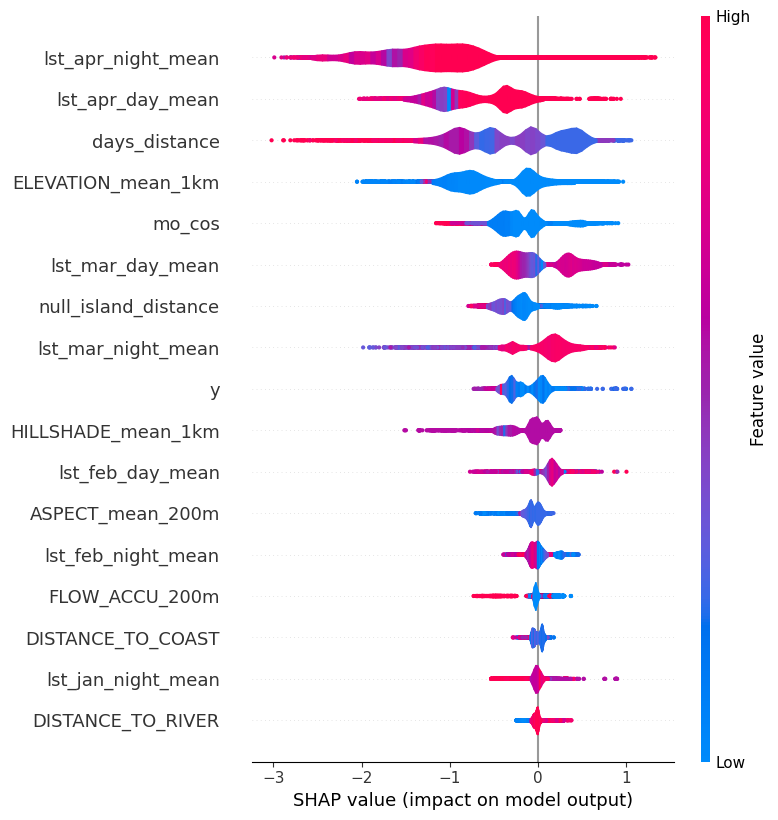

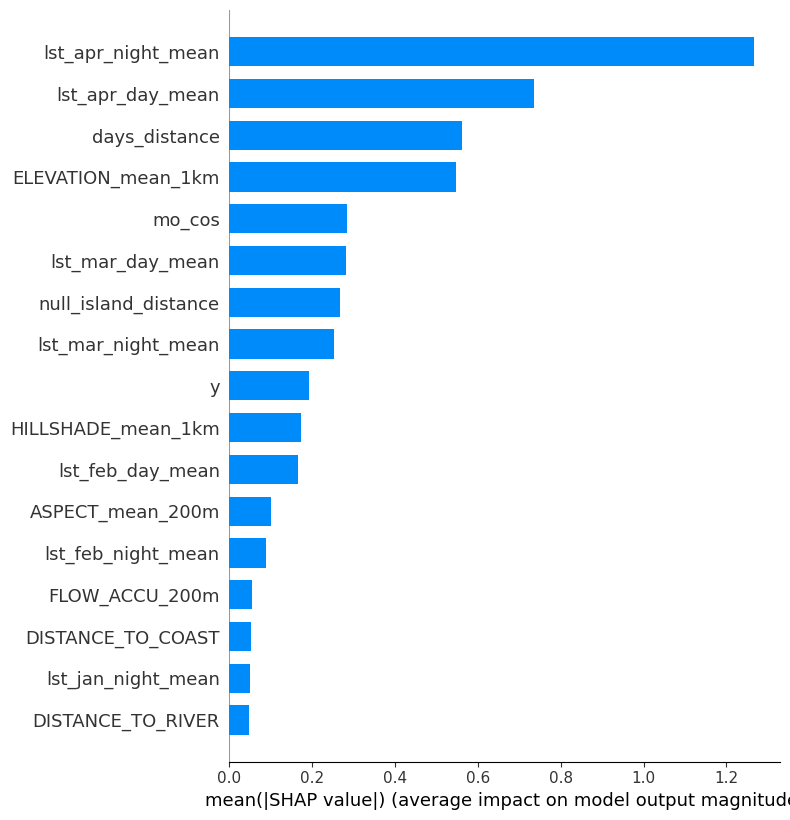

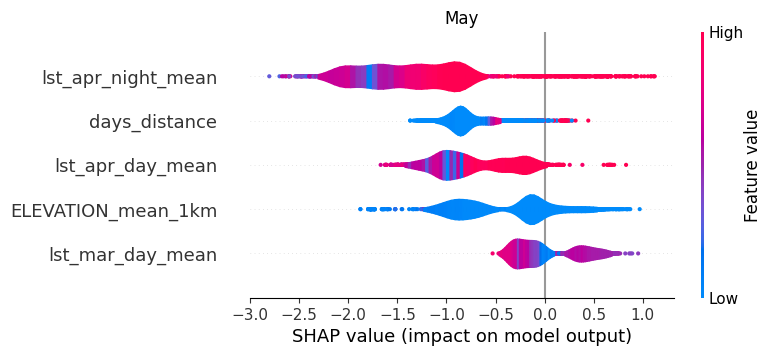

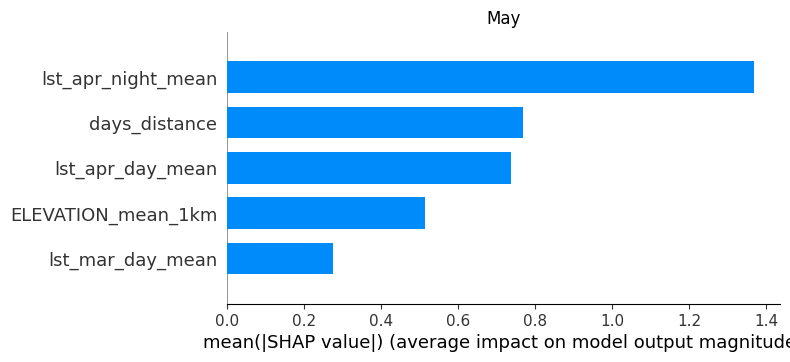

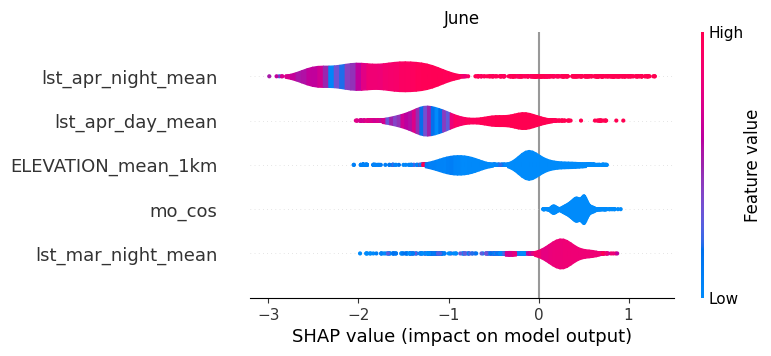

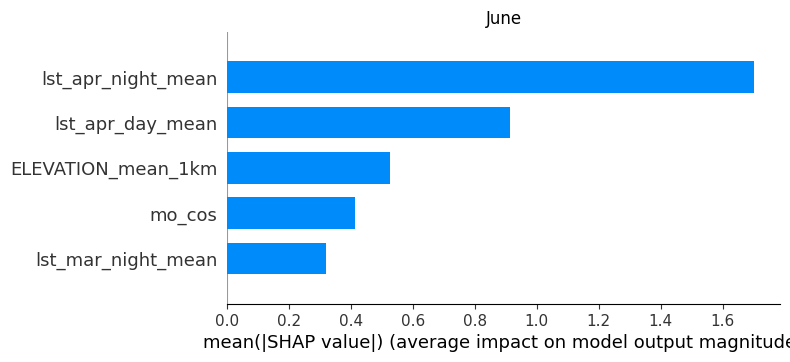

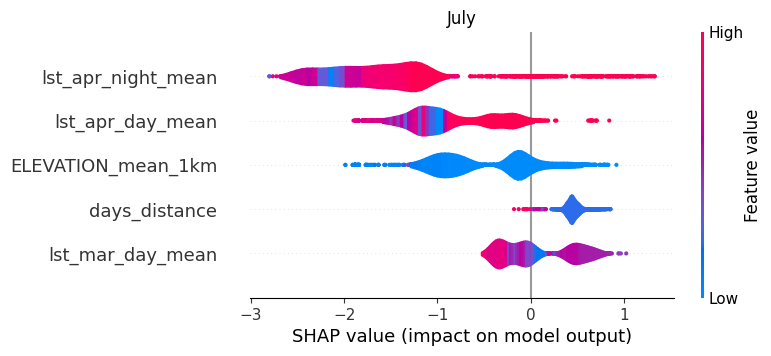

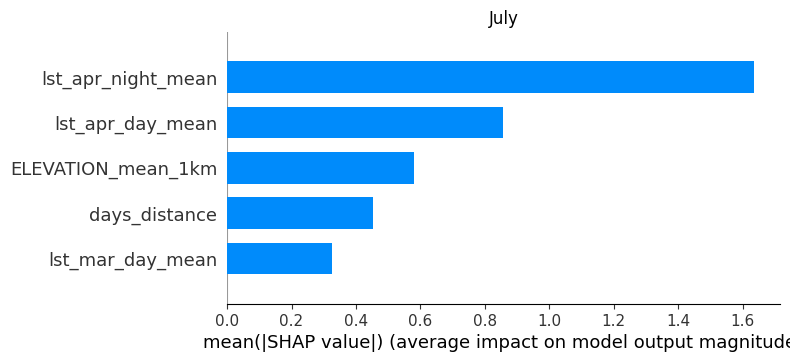

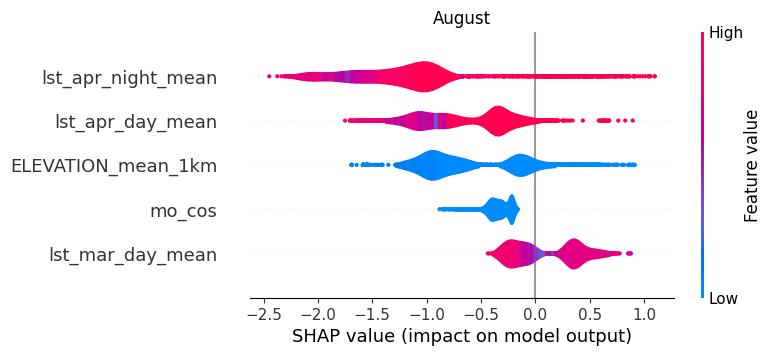

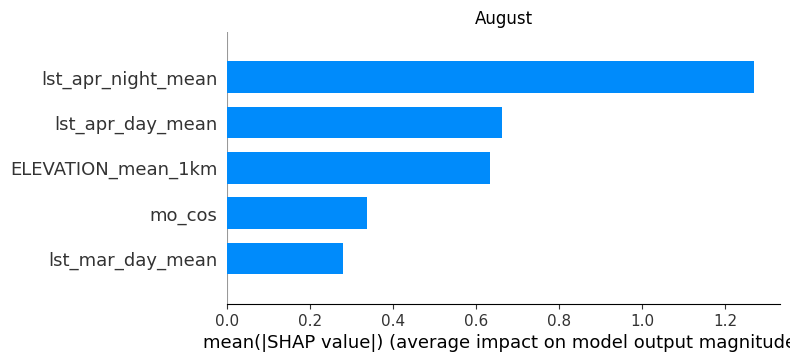

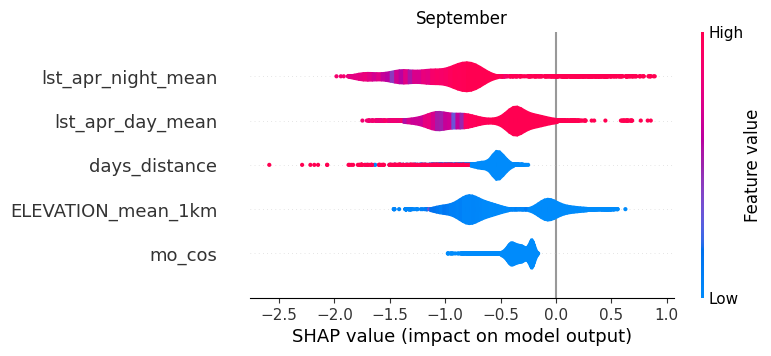

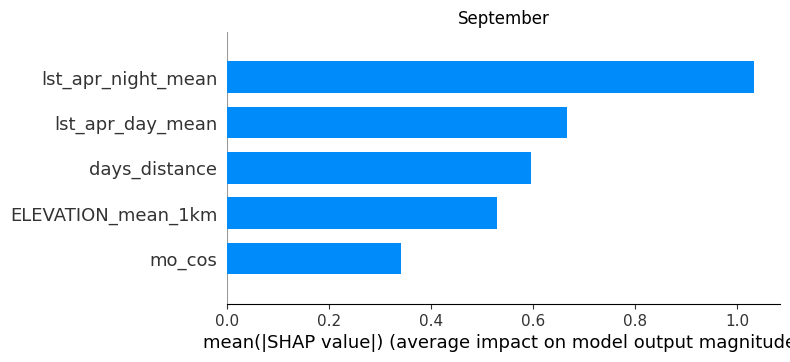

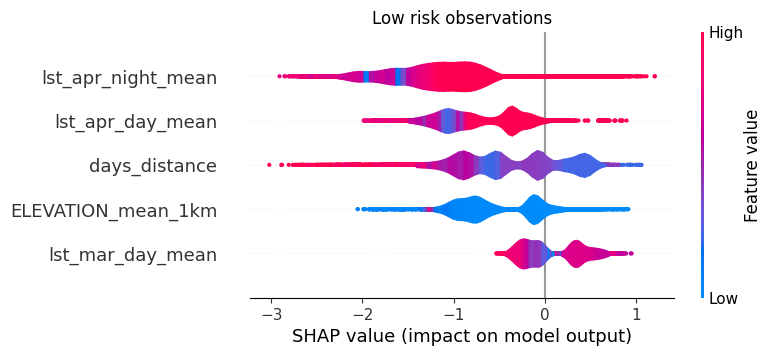

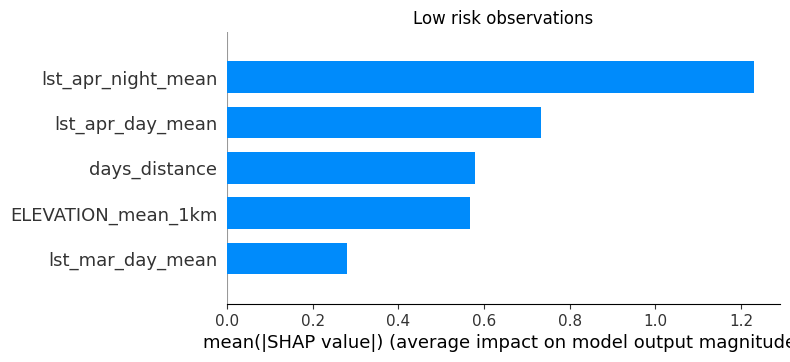

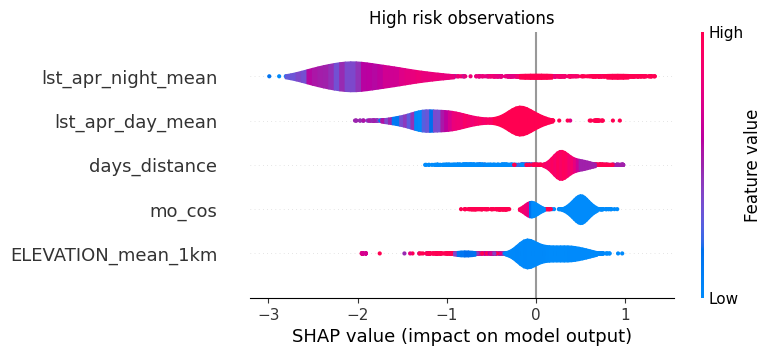

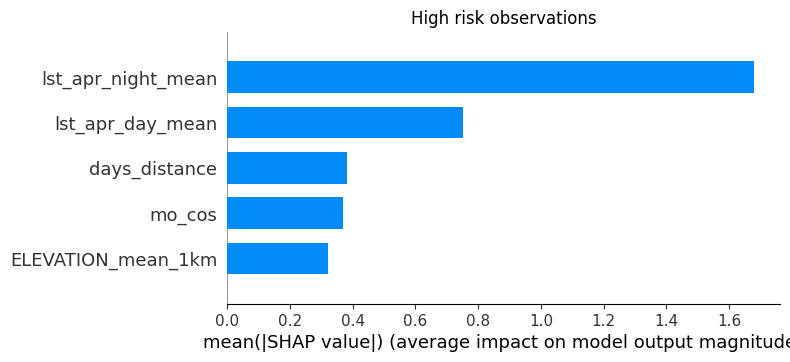

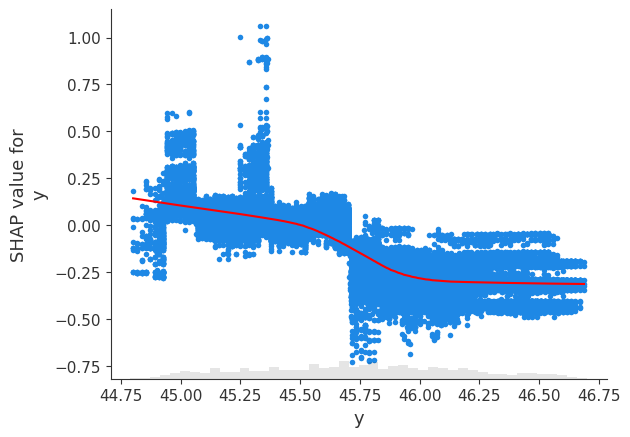

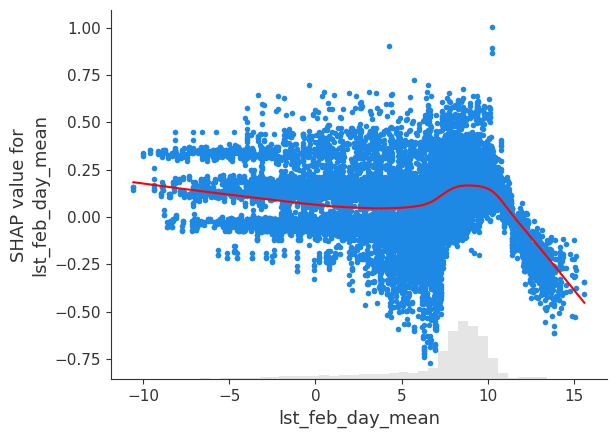

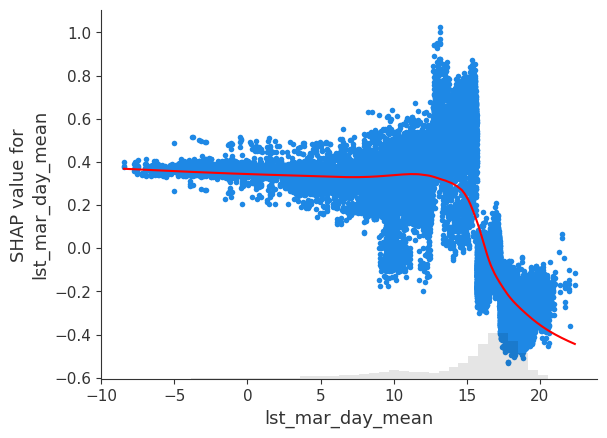

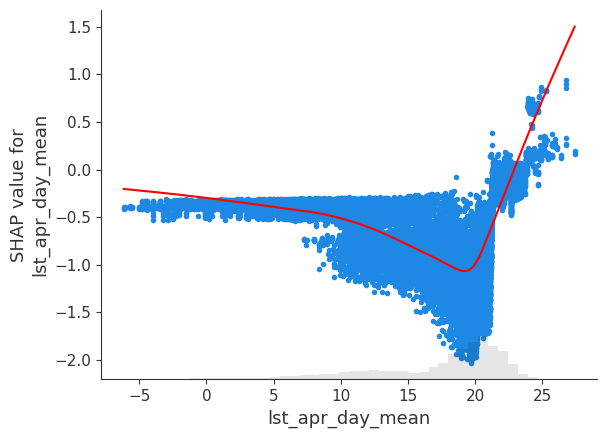

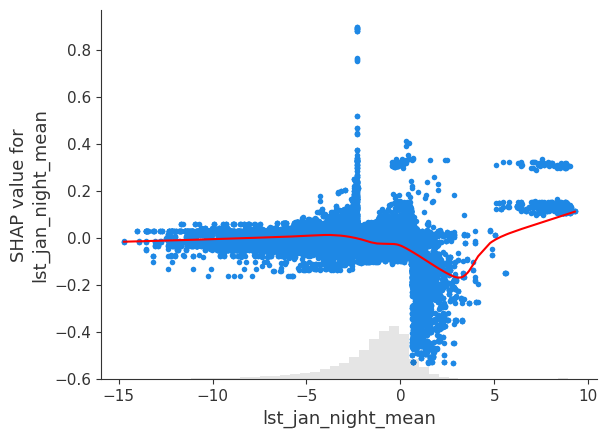

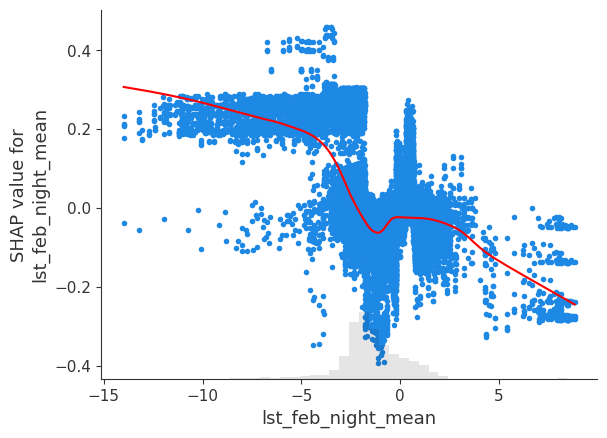

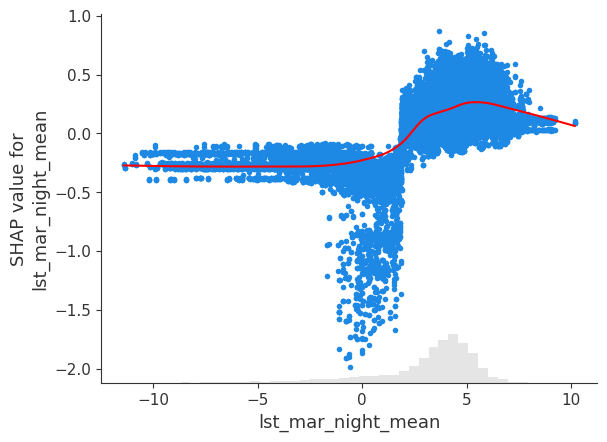

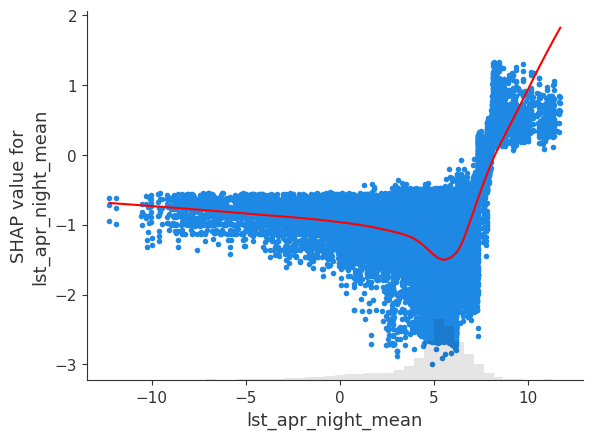

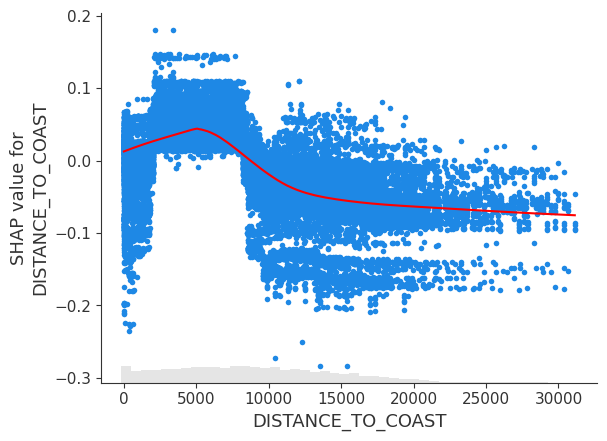

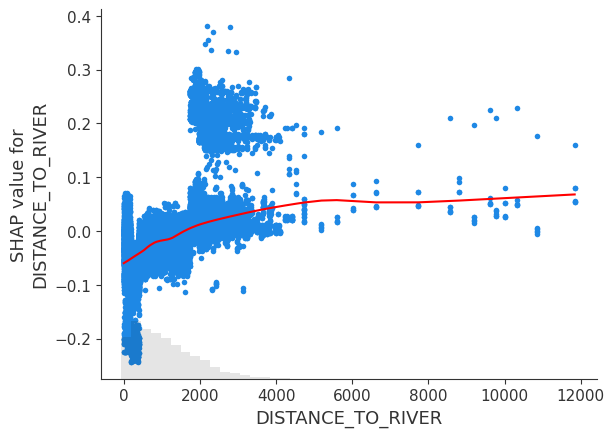

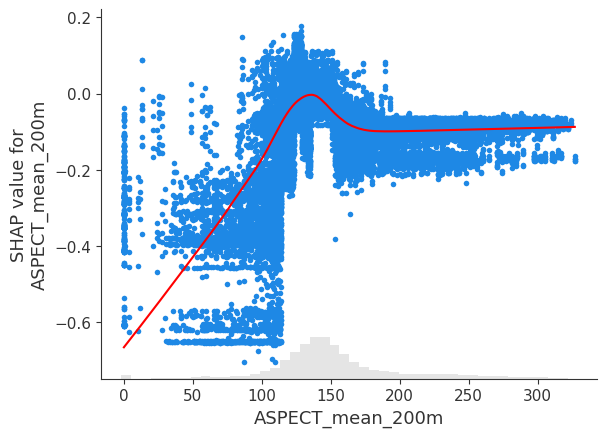

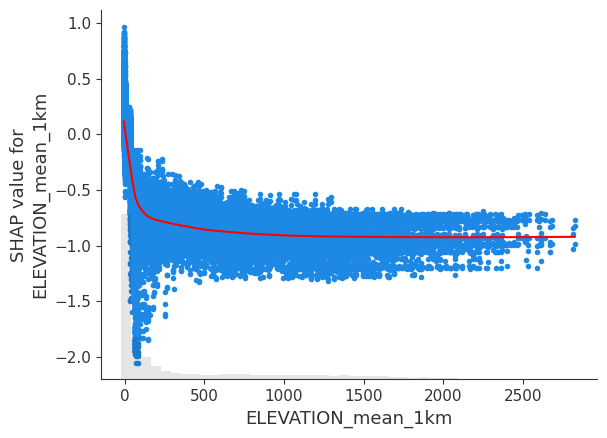

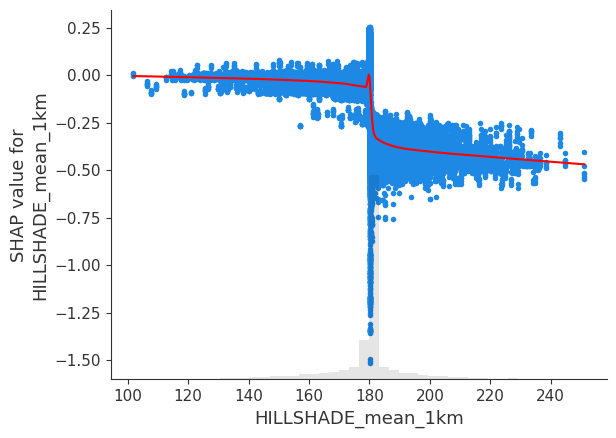

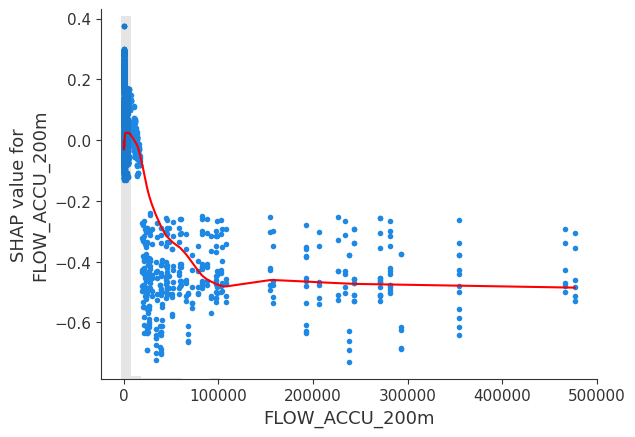

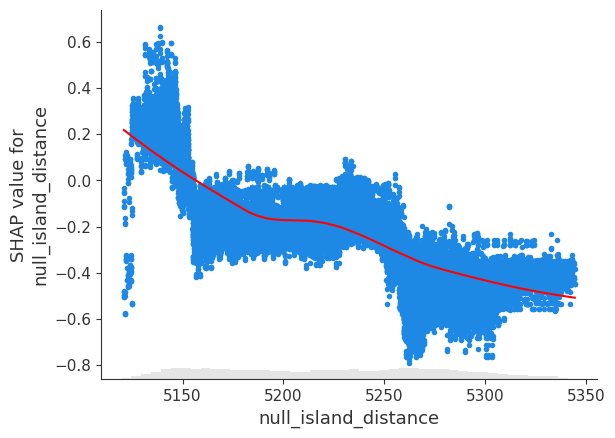

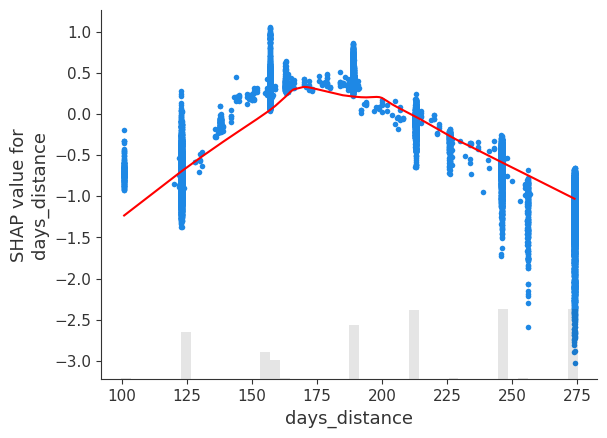

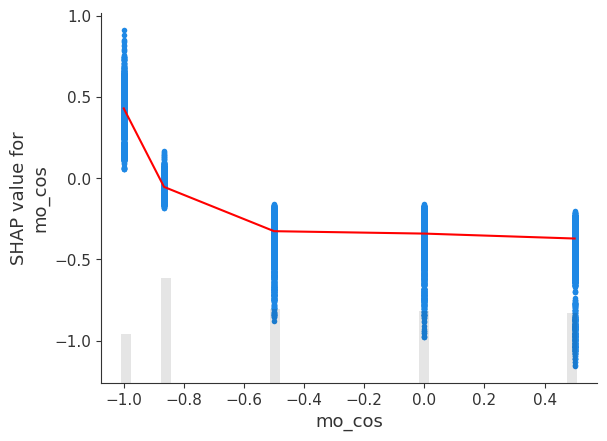

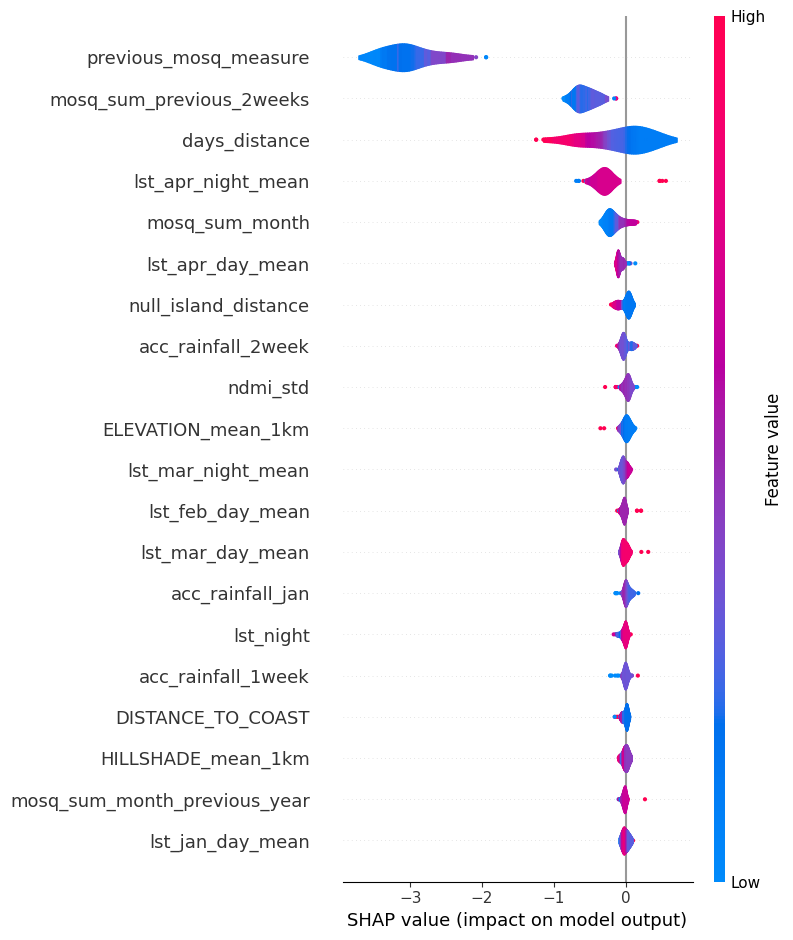

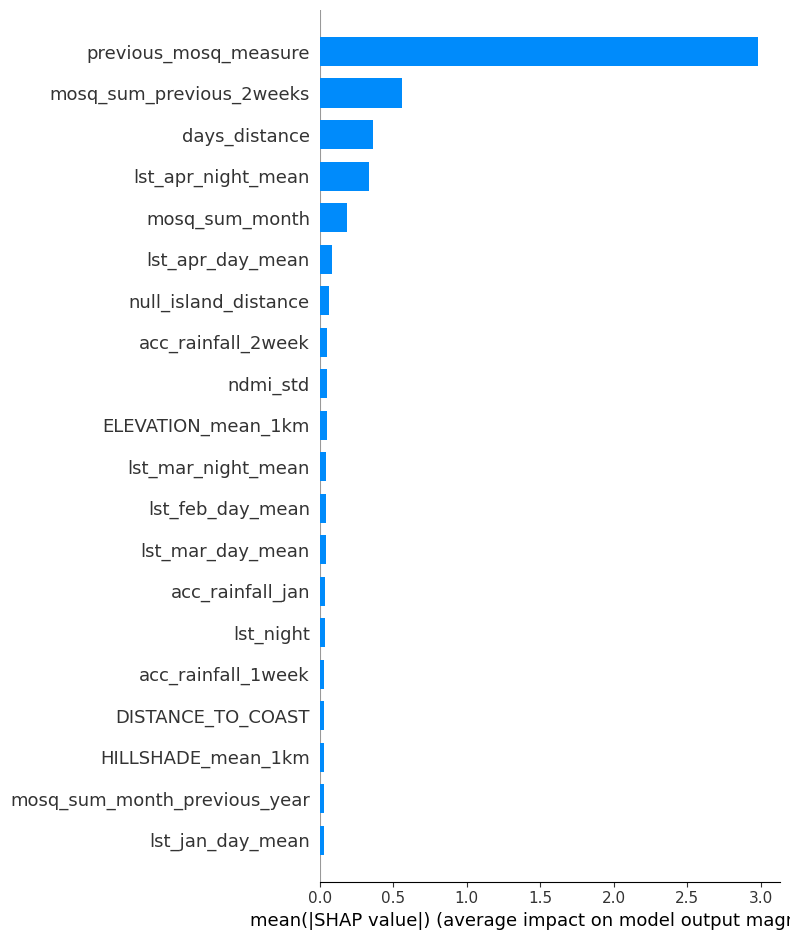

ValueError: `dataset` input should have multiple elements.

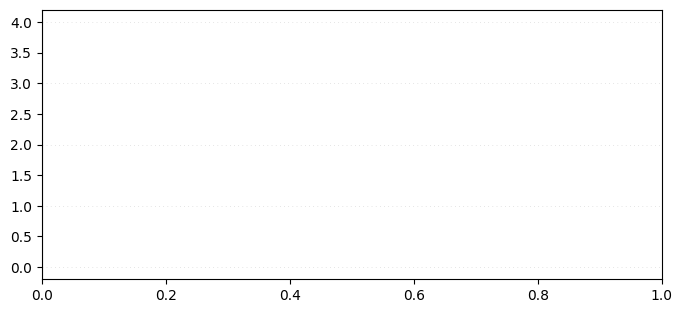

In [15]:
shap_explanations(predictions, model_env)
print('=============================')
shap_explanations(predictions, model_ent)

In [16]:
def validation_plots(path):
    csv_name =  path + 'overall_predictions_22.csv'
    predictions = pd.read_csv(csv_name)
    predictions['dt_placement'] = pd.to_datetime(predictions['dt_placement'], format="%Y-%m-%d")
    predictions['dt_prediction'] = pd.to_datetime(predictions['dt_prediction'], format="%Y-%m-%d")
    
    classes = list(range(10))
    q = np.array([1., 2., 16., 48., 98., 195., 318., 500.8, 772.8, 1300.,  13398.])
    bins, bounds = pd.cut(predictions.loc[:, 'previous_mosq_measure'], bins=q, retbins=True, labels=classes)
    predictions['previous_mosq_measure'] = bins
    predictions['previous_mosq_measure'] = predictions['previous_mosq_measure'].cat.codes.astype(int)
    predictions['previous_mosq_measure'] = predictions['previous_mosq_measure'].replace(-1,np.NaN)
    
    predictions['error'] = predictions['prediction'] - predictions['actual']
    predictions['abs_error'] = np.abs(predictions['error'])
    predictions['error_prev_actual'] = predictions['actual'] - predictions['previous_mosq_measure']
    predictions['abs_error_prev_actual'] = np.abs(predictions['error_prev_actual'])
    predictions['error_prev_pred'] = predictions['prediction'] - predictions['previous_mosq_measure']
    predictions['abs_error_prev_pred'] = np.abs(predictions['error_prev_pred'])
    
    months = {4:'April',
             5:'May',
             6:'June',
             7:'July',
             8:'August',
             9:'September',
             10:'October'}
    years = predictions['dt_prediction'].dt.year.unique().tolist()
    years.sort()
    
    predictions_10_diff = predictions[np.abs(predictions['time_diff'])<10]
    predictions_10_diff_v2 = predictions_10_diff.dropna(subset=['previous_mosq_measure']).reset_index(drop=True)
    predictions_30_diff = predictions[np.abs(predictions['time_diff'])<30].reset_index(drop=True)
    predictions_mean = predictions_10_diff.groupby(predictions_10_diff.dt_prediction.dt.to_period('M')).agg('mean')
    predictions_mean.index = predictions_mean.index.to_timestamp()
    predictions_std = predictions_10_diff.groupby(predictions_10_diff.dt_prediction.dt.to_period('M')).agg('std')
    predictions_std.index = predictions_std.index.to_timestamp()
    
    bins = np.arange(len(predictions_10_diff['actual'].unique())) - 0.5
    plt.hist(predictions_10_diff['abs_error'], bins)
    plt.xticks(range(len(predictions_10_diff['actual'].unique())))
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()
    
    bins = np.arange(len(predictions_10_diff['actual'].unique())) - 0.5
    _, _, bars = plt.hist(predictions_10_diff['abs_error'], bins, density=True)
    plt.xticks(range(len(predictions_10_diff['actual'].unique())))
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()
    
    print('Error 0:', bars[0].get_height())
    print('Error 1:', bars[1].get_height())
    print('Error 0+1:', bars[0].get_height() + bars[1].get_height())
    
    plt.plot(predictions_mean.index, predictions_mean['prediction'],'-o', label='prediction')
    plt.plot(predictions_mean.index, predictions_mean['actual'],'-o', label='actual')
    plt.grid()
    plt.legend()
    plt.xticks(rotation=30)
    plt.xlabel('Year - Month')
    plt.ylabel('Mean Class')
    plt.show()
    
    labels = predictions_10_diff.loc[:,'actual'].unique().tolist()
    labels.sort()
    f = []
    length = []
    for k in labels:
        cc = predictions_10_diff.loc[predictions_10_diff['actual']==k]
        length.append(len(cc))
        actual = cc.loc[:,'actual']
        predictions = cc.loc[:,'prediction']
        mae_class = np.abs(actual - predictions).mean()
        f.append(mae_class)
    labels = [str(int(e)) for e in labels]
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(labels,f)
    for i, v in enumerate(f):
        ax.text(i, v, str('%.2f'%(v)), rotation=30)
        ax.text(i, v/2,'n = '+ str(length[i]), weight="bold", ha='center', rotation=90)
    plt.xlabel('Class')
    plt.ylabel('MAE')
    plt.grid(axis='y')
    plt.show()
    
    def obj(x, a):
        return a * x
    
    freq_df = predictions_10_diff.groupby(by=['actual', 'prediction']).size().reset_index(name='frequency')
    f, ax = plt.subplots()
    points = ax.scatter(freq_df['actual'], freq_df['prediction'], c=freq_df['frequency'], cmap='Greens')
    f.colorbar(points, label='Frequency')
    popt, pcov = curve_fit(obj, predictions_10_diff['actual'], predictions_10_diff['prediction'])
    m = popt[0]
    b=0    
    plt.plot([0.0, 9.0], m*pd.Series([0.0, 9.0]) + b,'r',label='y={:.2f}x'.format(m))
#     plt.plot([min(predictions_10_diff['actual'].min(),predictions_10_diff['prediction'].min()), max(predictions_10_diff['actual'].max(), predictions_10_diff['prediction'].max())], [min(predictions_10_diff['actual'].min(), predictions_10_diff['prediction'].min()), max(predictions_10_diff['actual'].max(), predictions_10_diff['prediction'].max())], '--', color='grey', label='y=x')
    plt.plot([0.0, 9.0], [0.0, 9.0],'--', color='grey', label='y=x')
    plt.grid()
    plt.legend()
    plt.xlabel('Actual Class')
    plt.ylabel('Predicted Class')
    plt.show()
    
    f, ax = plt.subplots(nrows=1, ncols=5,  figsize=(50, 10))
    k=1
    for i in [5,6,7,8,9]:
        plt.subplot(1, 5, k)
        month_df = predictions_10_diff[predictions_10_diff.dt_placement.dt.month==i].reset_index(drop=True)
        if len(month_df) != 0:
            freq_df = month_df.groupby(by=['prediction', 'actual']).size().reset_index(name='frequency')
            points = ax[k-1].scatter(freq_df['actual'], freq_df['prediction'],  c=freq_df['frequency'], cmap='Greens')
            f.colorbar(points, label='Frequency')
            popt, pcov = curve_fit(obj, month_df['actual'], month_df['prediction'])
            m = popt[0]
            b=0
            plt.plot([0.0, 9.0], m*pd.Series([0.0, 9.0]) + b, 'r', label='y={:.2f}x'.format(m))
#             plt.plot(month_df['actual'], m*month_df['actual'] + b, 'r', label='y={:.2f}x'.format(m))
#         plt.plot([min(month_df['actual'].min(),month_df['prediction'].min()), max(month_df['actual'].max(),month_df['prediction'].max())], [min(month_df['actual'].min(),month_df['prediction'].min()), max(month_df['actual'].max(),month_df['prediction'].max())], '--', color='grey', label='y=x')
        plt.plot([0.0, 9.0], [0.0, 9.0],'--', color='grey', label='y=x')
        plt.grid()
        plt.legend()
        plt.xlabel('Actual Class')
        plt.ylabel('Predicted Class')
        plt.title(months[i])
        k = k+1
    plt.tight_layout()
    plt.show()

    for i in years:
        predictions_year = predictions_mean[predictions_mean.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['abs_error'],'-o',label=str(i))
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Mean Absolute Error')
    plt.show()
    
    for i in years:
        predictions_year = predictions_mean[predictions_mean.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['error'],'-o',label=str(i))
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Mean Error')
    plt.show()
    
    for i in years:
        predictions_year = predictions_mean[predictions_mean.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['prediction'],'-o',label=str(i))
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Mean Predicted Class')
    plt.show()
    
    for i in years:
        predictions_year = predictions_mean[predictions_mean.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['actual'],'-o',label=str(i))
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Mean Actual Class')
    plt.show()
    
    for i in years:
        predictions_year_mean = predictions_mean[predictions_mean.index.year==i]
        predictions_year_std = predictions_std[predictions_std.index.year==i]
        plt.plot(predictions_year_std.index.month, predictions_year_std['abs_error']/predictions_year_mean['abs_error'],'-o',label=str(i))
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Coefficient of Error Std')
    plt.show()
    
    predictions_30_diff['time_diff'] = np.abs(predictions_30_diff['time_diff'])
    freq_df = predictions_30_diff.groupby(by=['time_diff', 'abs_error']).size().reset_index(name='frequency')
    f, ax = plt.subplots()
    points = ax.scatter(freq_df['time_diff'], freq_df['abs_error'], c=freq_df['frequency'], cmap='Greens')
    f.colorbar(points, label='Frequency')
    m, b = np.polyfit(np.abs(predictions_30_diff['time_diff']),predictions_30_diff['abs_error'], 1)
    plt.plot(np.abs(predictions_30_diff['time_diff']), m*np.abs(predictions_30_diff['time_diff']) + b,'r',label='y={:.2f}x+{:.2f}'.format(m,b))
    plt.ylabel('Absolute error')
    plt.xlabel('Time Difference (Days)')
    plt.legend()
    plt.grid()
    plt.show()
    
    for i in years:
        predictions_year = predictions_mean[predictions_mean.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['abs_error_prev_actual'],'-o',label=str(i))
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('consecutive measurements \n mean difference')
    plt.show()
    
    for i in years:
        predictions_year = predictions_mean[predictions_mean.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['abs_error_prev_pred'],'-o',label=str(i))
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Prediction - previous measurment \n mean difference')
    plt.show()
    
    freq_df = predictions_10_diff_v2.groupby(by=['actual', 'previous_mosq_measure']).size().reset_index(name='frequency')
    f, ax = plt.subplots()
    points = ax.scatter(freq_df['previous_mosq_measure'], freq_df['actual'],  c=freq_df['frequency'], cmap='Greens')
    f.colorbar(points, label='Frequency')
    popt, pcov = curve_fit(obj, predictions_10_diff_v2['previous_mosq_measure'], predictions_10_diff_v2['actual'])
    m = popt[0]
    b=0
    plt.plot([0.0, 9.0], m*pd.Series([0.0, 9.0]) + b, 'r', label='y={:.2f}x'.format(m))
    #plt.plot([min(predictions_10_diff_v2['previous_mosq_measure'].min(),predictions_10_diff_v2['actual'].min()), max(predictions_10_diff_v2['previous_mosq_measure'].max(), predictions_10_diff_v2['actual'].max())], [min(predictions_10_diff_v2['previous_mosq_measure'].min(), predictions_10_diff_v2['actual'].min()), max(predictions_10_diff_v2['previous_mosq_measure'].max(), predictions_10_diff_v2['actual'].max())], '--', color='grey', label='y=x')
    plt.plot([0.0, 9.0], [0.0, 9.0],'--', color='grey', label='y=x')
    plt.grid()
    plt.legend()
    plt.xlabel('Previous Class')
    plt.ylabel('Current Class')
    plt.show()
    
    f, ax = plt.subplots(nrows=1, ncols=5,  figsize=(50, 10))
    k=1
    for i in [5,6,7,8,9]:
        plt.subplot(1, 5, k)
        month_df = predictions_10_diff_v2[predictions_10_diff_v2.dt_prediction.dt.month==i].reset_index(drop=True)
        if len(month_df) != 0:
            print(months[i]+':', len(month_df[month_df['actual']>= month_df['previous_mosq_measure']])/len(month_df))
            freq_df =month_df.groupby(by=['actual', 'previous_mosq_measure']).size().reset_index(name='frequency')
            points = ax[k-1].scatter(freq_df['previous_mosq_measure'], freq_df['actual'],  c=freq_df['frequency'], cmap='Greens')
            f.colorbar(points, label='Frequency')
            popt, pcov = curve_fit(obj, month_df['previous_mosq_measure'], month_df['actual'])
            m = popt[0]
            b=0
            plt.plot([0.0, 9.0], m*pd.Series([0.0, 9.0]) + b, 'r', label='y={:.2f}x'.format(m))
#             plt.plot(month_df['previous_mosq_measure'], m*month_df['previous_mosq_measure'] + b, 'r', label='y={:.2f}x'.format(m))
#         plt.plot([min(predictions_10_diff_v2['previous_mosq_measure'].min(),predictions_10_diff_v2['actual'].min()), max(predictions_10_diff_v2['previous_mosq_measure'].max(), predictions_10_diff_v2['actual'].max())], [min(predictions_10_diff_v2['previous_mosq_measure'].min(), predictions_10_diff_v2['actual'].min()), max(predictions_10_diff_v2['previous_mosq_measure'].max(), predictions_10_diff_v2['actual'].max())], '--', color='grey', label='y=x')
        plt.plot([0.0, 9.0], [0.0, 9.0],'--', color='grey', label='y=x')
        plt.grid()
        plt.legend()
        plt.xlabel('Previous Class')
        plt.ylabel('Current Class')
        plt.title(months[i])
        k = k+1
    plt.tight_layout()
    plt.show()
    
    freq_df = predictions_10_diff_v2.groupby(by=['prediction', 'previous_mosq_measure']).size().reset_index(name='frequency')
    f, ax = plt.subplots()
    points = ax.scatter(freq_df['previous_mosq_measure'], freq_df['prediction'], c=freq_df['frequency'], cmap='Greens')
    f.colorbar(points, label='Frequency')
    popt, pcov = curve_fit(obj, predictions_10_diff_v2['previous_mosq_measure'], predictions_10_diff_v2['prediction'])
    m = popt[0]
    b=0
    plt.plot([0.0, 9.0], m*pd.Series([0.0, 9.0]) + b, 'r', label='y={:.2f}x'.format(m))
#     plt.plot([min(predictions_10_diff_v2['previous_mosq_measure'].min(),predictions_10_diff_v2['prediction'].min()), max(predictions_10_diff_v2['previous_mosq_measure'].max(), predictions_10_diff_v2['prediction'].max())], [min(predictions_10_diff_v2['previous_mosq_measure'].min(), predictions_10_diff_v2['prediction'].min()), max(predictions_10_diff_v2['previous_mosq_measure'].max(), predictions_10_diff_v2['prediction'].max())], '--', color='grey', label='y=x')
    plt.plot([0.0, 9.0], [0.0, 9.0],'--', color='grey', label='y=x')
    plt.grid()
    plt.legend()
    plt.xlabel('Previous Class')
    plt.ylabel('Predicted Class')
    plt.show()
    
    f, ax = plt.subplots(nrows=1, ncols=5,  figsize=(50, 10))
    k=1
    for i in [5,6,7,8,9]:
        plt.subplot(1, 5, k)
        month_df = predictions_10_diff_v2[predictions_10_diff_v2.dt_prediction.dt.month==i].reset_index(drop=True) 
        if len(month_df) != 0:
            freq_df =month_df.groupby(by=['prediction', 'previous_mosq_measure']).size().reset_index(name='frequency')
            points = ax[k-1].scatter(freq_df['previous_mosq_measure'], freq_df['prediction'],  c=freq_df['frequency'], cmap='Greens')
            f.colorbar(points, label='Frequency')
            popt, pcov = curve_fit(obj, month_df['previous_mosq_measure'], month_df['prediction'])
            m = popt[0]
            b=0
            plt.plot([0.0, 9.0], m*pd.Series([0.0, 9.0]) + b, 'r', label='y={:.2f}x'.format(m))
#             plt.plot(month_df['previous_mosq_measure'], m*month_df['previous_mosq_measure'] + b, 'r', label='y={:.2f}x'.format(m))
#         plt.plot([min(month_df['previous_mosq_measure'].min(),month_df['prediction'].min()), max(month_df['previous_mosq_measure'].max(),month_df['prediction'].max())], [min(month_df['previous_mosq_measure'].min(),month_df['prediction'].min()), max(month_df['previous_mosq_measure'].max(),month_df['prediction'].max())], '--', color='grey', label='y=x')
        plt.plot([0.0, 9.0], [0.0, 9.0],'--', color='grey', label='y=x')
        plt.grid()
        plt.legend()
        plt.xlabel('Previous Class')
        plt.ylabel('Predicted Class')
        plt.title(months[i])
        k = k+1
    plt.tight_layout()
    plt.show()
    
#     f, ax = plt.subplots(nrows=1, ncols=5,  figsize=(50, 10))
#     k=1
#     for i in [5,6,7,8,9]:
#         plt.subplot(1, 5, k)
#         month_df = predictions_10_diff_v2[predictions_10_diff_v2.dt_prediction.dt.month==i].reset_index(drop=True) 
#         if len(month_df) != 0:
#             month_df['diff'] =  month_df['actual'] - month_df['previous_mosq_measure']
#             freq_df =month_df.groupby(by=['diff', 'previous_mosq_measure']).size().reset_index(name='frequency')
#             points = ax[k-1].scatter(freq_df['previous_mosq_measure'], freq_df['diff'],  c=freq_df['frequency'], cmap='Greens')
#             f.colorbar(points, label='Frequency')
#             popt, pcov = curve_fit(obj, month_df['previous_mosq_measure'], month_df['diff'])
#             m = popt[0]
#             b=0
#             plt.plot(month_df['previous_mosq_measure'], m*month_df['previous_mosq_measure'] + b, 'r', label='y={:.2f}x'.format(m))
#         plt.grid()
#         plt.legend()
#         plt.xlabel('Previous Class')
#         plt.ylabel('Diff Class')
#         plt.title(months[i])
#         k = k+1
#     plt.tight_layout()
#     plt.show()    

In [5]:
def validation_plots_comparison(path):
    csv_name =  path + 'overall_predictions_ent_with_env_model.csv'
    predictions = pd.read_csv(csv_name)
    predictions['dt_placement'] = pd.to_datetime(predictions['dt_placement'], format="%Y-%m-%d")
    predictions['dt_prediction'] = pd.to_datetime(predictions['dt_prediction'], format="%Y-%m-%d")
    
    classes = list(range(10))
    q = np.array([1., 2., 16., 48., 98., 195., 318., 500.8, 772.8, 1300.,  13398.])
    bins, bounds = pd.cut(predictions.loc[:, 'previous_mosq_measure'], bins=q, retbins=True, labels=classes)
    predictions['previous_mosq_measure'] = bins
    predictions['previous_mosq_measure'] = predictions['previous_mosq_measure'].cat.codes.astype(int)
    predictions['previous_mosq_measure'] = predictions['previous_mosq_measure'].replace(-1,np.NaN)
    
    predictions['error'] = predictions['prediction'] - predictions['actual']
    predictions['abs_error'] = np.abs(predictions['error'])
    predictions['error_prev_actual'] = predictions['actual'] - predictions['previous_mosq_measure']
    predictions['abs_error_prev_actual'] = np.abs(predictions['error_prev_actual'])
    predictions['error_prev_pred'] = predictions['prediction'] - predictions['previous_mosq_measure']
    predictions['abs_error_prev_pred'] = np.abs(predictions['error_prev_pred'])
    
    months = {4:'April',
             5:'May',
             6:'June',
             7:'July',
             8:'August',
             9:'September',
             10:'October'}
    years = predictions['dt_prediction'].dt.year.unique().tolist()
    years.sort()
    
    predictions_10_diff = predictions[np.abs(predictions['time_diff'])<10]
    predictions_10_diff_ent = predictions_10_diff[predictions_10_diff['entomological_features']==True]
    predictions_10_diff_env = predictions_10_diff[predictions_10_diff['entomological_features']==False]
    predictions_30_diff = predictions[np.abs(predictions['time_diff'])<30].reset_index(drop=True)
    predictions_mean_env = predictions_10_diff_env.groupby(predictions_10_diff_env.dt_prediction.dt.to_period('M')).agg('mean')
    predictions_mean_env.index = predictions_mean_env.index.to_timestamp()
    predictions_std_env = predictions_10_diff_env.groupby(predictions_10_diff_env.dt_prediction.dt.to_period('M')).agg('std')
    predictions_std_env.index = predictions_std_env.index.to_timestamp()
    predictions_mean_ent = predictions_10_diff_ent.groupby(predictions_10_diff_ent.dt_prediction.dt.to_period('M')).agg('mean')
    predictions_mean_ent.index = predictions_mean_ent.index.to_timestamp()
    predictions_std_ent = predictions_10_diff_ent.groupby(predictions_10_diff_ent.dt_prediction.dt.to_period('M')).agg('std')
    predictions_std_ent.index = predictions_std_ent.index.to_timestamp()
    
    plt.subplot(1, 2, 1)
    bins = np.arange(len(predictions_10_diff_ent['actual'].unique())) - 0.5
    plt.hist(predictions_10_diff_ent['abs_error'], bins)
    plt.xticks(range(len(predictions_10_diff_ent['actual'].unique())))
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.title('With entomological info')
    plt.grid()
    plt.subplot(1, 2, 2)
    bins = np.arange(len(predictions_10_diff_env['actual'].unique())) - 0.5
    plt.hist(predictions_10_diff_env['abs_error'], bins)
    plt.xticks(range(len(predictions_10_diff_env['actual'].unique())))
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.title('Without entomological info')
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    plt.plot(predictions_mean_env.index, predictions_mean_env['prediction'],'-o', label='entomological prediction')
    plt.plot(predictions_mean_ent.index, predictions_mean_ent['prediction'],'-o', label='environmental prediction')
    plt.plot(predictions_mean_ent.index, predictions_mean_ent['actual'],'-o', label='actual')
    plt.grid()
    plt.legend()
    plt.xticks(rotation=30)
    plt.xlabel('Year - Month')
    plt.ylabel('Mean Class')
    plt.show()
    
    
    labels = predictions_10_diff.loc[:,'actual'].unique().tolist()
    labels.sort()
    f_env = []
    length_env = []
    f_ent = []
    length_ent = []
    for k in labels:
        cc = predictions_10_diff_env.loc[predictions_10_diff_env['actual']==k]
        length_env.append(len(cc))
        actual = cc.loc[:,'actual']
        predictions = cc.loc[:,'prediction']
        mae_class = np.abs(actual - predictions).mean()
        f_env.append(mae_class)
        cc = predictions_10_diff_ent.loc[predictions_10_diff_ent['actual']==k]
        length_ent.append(len(cc))
        actual = cc.loc[:,'actual']
        predictions = cc.loc[:,'prediction']
        mae_class = np.abs(actual - predictions).mean()
        f_ent.append(mae_class)
    total = []
    size = []
    for j in range(10):
        total.append([f_ent[j], f_env[j]])
        size.append([length_ent[j], length_ent[j]])
    df = pd.DataFrame(total, index=list(range(10)), columns = ["entomological","environmental"])
    size_df = pd.DataFrame(size, index=list(range(10)), columns = ["entomological","environmental"])
    ax = df.plot(kind='bar',figsize=(10,8),width=0.8, ylabel="MAE",title='MAE per class', xlabel='Class')
    i = 0
    for p in ax.patches:
        row = i%(len(df))
        column = i//(len(df))
        if not math.isnan(df.iloc[row,column]):
            ax.annotate('%.2f'%(p.get_height()), (p.get_x() +0.1, p.get_height() * 1.005),rotation=30)
            ax.annotate(int(size_df.iloc[row,column]), (p.get_x()+0.1, p.get_height()/2),rotation=90)
        i += 1
    ax.legend(loc="lower right")
    fig = ax.get_figure()
    plt.grid(axis='y')
    plt.show()
    
    f, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
    plt.subplot(1, 2, 1)

    m, b = np.polyfit(predictions_10_diff_env['actual'], predictions_10_diff_env['prediction'], 1)
    plt.plot(predictions_10_diff_env['actual'], m*predictions_10_diff_env['actual'] + b,'r',label='y={:.2f}x+{:.2f}'.format(m,b))
    freq_df = predictions_10_diff_env.groupby(by=['actual', 'prediction']).size().reset_index(name='frequency')
    points = ax1.scatter(freq_df['actual'], freq_df['prediction'], c=freq_df['frequency'], cmap='Greens')
    f.colorbar(points, label='Frequency')
    plt.grid()
    plt.title('Without entomological info')
    plt.legend()
    plt.xlabel('Actual Class')
    plt.ylabel('Predicted Class')
    plt.subplot(1, 2, 2)
    m, b = np.polyfit(predictions_10_diff_ent['actual'], predictions_10_diff_ent['prediction'], 1)
    plt.plot(predictions_10_diff_ent['actual'], m*predictions_10_diff_ent['actual'] + b,'r',label='y={:.2f}x+{:.2f}'.format(m,b))
    freq_df = freq_df.groupby(by=['actual', 'prediction']).size().reset_index(name='frequency')
    points = ax2.scatter(freq_df['actual'], freq_df['prediction'], c=freq_df['frequency'], cmap='Greens')
    f.colorbar(points, label='Frequency')
    plt.grid()
    plt.legend()
    plt.title('With entomological info')
    plt.xlabel('Actual Class')
    plt.ylabel('Predicted Class')
    plt.tight_layout()
    plt.show()

    colours = ['b','r','g']
    c =0
    for i in years:
        predictions_year = predictions_mean_env[predictions_mean_env.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['abs_error'],'-o',color=colours[c],label=str(i)+'_env')
        predictions_year = predictions_mean_ent[predictions_mean_ent.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['abs_error'],'--o',color=colours[c],label=str(i)+'_ent')
        c = c+1
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Mean Absolute Error')
    plt.show()
    
    c =0
    for i in years:
        predictions_year = predictions_mean_env[predictions_mean_env.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['error'],'-o',color=colours[c],label=str(i)+'_env')
        predictions_year = predictions_mean_ent[predictions_mean_ent.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['error'],'--o',color=colours[c],label=str(i)+'_ent')
        c = c+1
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Mean Error')
    plt.show()
    
    c =0
    for i in years:
        predictions_year = predictions_mean_env[predictions_mean_env.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['prediction'],'-o',color=colours[c],label=str(i)+'_env')
        predictions_year = predictions_mean_ent[predictions_mean_ent.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['prediction'],'--o',color=colours[c],label=str(i)+'_ent')
        c = c+1
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Mean Predicted Class')
    plt.show()
    
    c =0
    for i in years:
        predictions_year = predictions_mean_env[predictions_mean_env.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['actual'],'-o',color=colours[c],label=str(i))
        c = c+1
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Mean Actual Class')
    plt.show()
    
    c=0
    for i in years:
        predictions_year_mean = predictions_mean_env[predictions_mean_env.index.year==i]
        predictions_year_std = predictions_std_env[predictions_std_env.index.year==i]
        plt.plot(predictions_year_std.index.month, predictions_year_std['abs_error']/predictions_year_mean['abs_error'],'-o', color=colours[c], label=str(i)+'_env')
        predictions_year_mean = predictions_mean_ent[predictions_mean_ent.index.year==i]
        predictions_year_std= predictions_std_ent[predictions_std_ent.index.year==i]
        plt.plot(predictions_year_std.index.month, predictions_year_std['abs_error']/predictions_year_mean['abs_error'],'--o', color=colours[c], label=str(i)+'_ent')
        c = c+1
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Coefficient of Error Std')
    plt.show()
    
    
    predictions_30_diff['time_diff'] = np.abs(predictions_30_diff['time_diff'])
    f, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
    plt.subplot(1, 2, 1)
    freq_df = predictions_30_diff[predictions_30_diff['entomological_features']==False]
    m, b = np.polyfit(freq_df['time_diff'],freq_df['abs_error'], 1)
    plt.plot(np.abs(freq_df['time_diff']), m*np.abs(freq_df['time_diff']) + b,'r',label='y={:.2f}x+{:.2f}'.format(m,b))
    freq_df = freq_df.groupby(by=['time_diff', 'abs_error']).size().reset_index(name='frequency')
    points = ax1.scatter(freq_df['time_diff'], freq_df['abs_error'], c=freq_df['frequency'], cmap='Greens')
    f.colorbar(points, label='Frequency')
    plt.ylabel('Absolute error')
    plt.xlabel('Time Difference (Days)')
    plt.title('Without entomological info')
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    freq_df = predictions_30_diff[predictions_30_diff['entomological_features']==True]
    m, b = np.polyfit(freq_df['time_diff'],freq_df['abs_error'], 1)
    plt.plot(np.abs(freq_df['time_diff']), m*np.abs(freq_df['time_diff']) + b,'r',label='y={:.2f}x+{:.2f}'.format(m,b))
    freq_df = freq_df.groupby(by=['time_diff', 'abs_error']).size().reset_index(name='frequency')
    points = ax2.scatter(freq_df['time_diff'], freq_df['abs_error'], c=freq_df['frequency'], cmap='Greens')
    f.colorbar(points, label='Frequency')
    plt.ylabel('Absolute error')
    plt.xlabel('Time Difference (Days)')
    plt.title('With entomological info')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    c=0
    for i in years:
        predictions_year = predictions_mean_env[predictions_mean_env.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['abs_error_prev_actual'],'-o', color=colours[c], label=str(i))
        c = c+1
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('consecutive measurements \n mean difference')
    plt.show()
    
    c=0
    for i in years:
        predictions_year = predictions_mean_env[predictions_mean_env.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['abs_error_prev_pred'],'-o', color=colours[c], label=str(i)+'_env')
        predictions_year = predictions_mean_ent[predictions_mean_ent.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['abs_error_prev_pred'],'--o', color=colours[c], label=str(i)+'_ent')
        c = c+1
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Prediction - previous measurment \n mean difference')
    plt.show()
    
    f, ax = plt.subplots()
    m, b = np.polyfit(predictions_10_diff_ent['previous_mosq_measure'], predictions_10_diff_ent['actual'], 1)
    plt.plot(predictions_10_diff_ent['previous_mosq_measure'], m*predictions_10_diff_ent['previous_mosq_measure'] + b, 'r', label='y={:.2f}x+{:.2f}'.format(m,b))
    freq_df = predictions_10_diff_ent.groupby(by=['actual', 'previous_mosq_measure']).size().reset_index(name='frequency')
    points = ax.scatter(freq_df['previous_mosq_measure'], freq_df['actual'],  c=freq_df['frequency'], cmap='Greens')
    f.colorbar(points, label='Frequency')
    plt.grid()
    plt.legend()
    plt.xlabel('Previous Class')
    plt.ylabel('Current Actual Class')
    plt.title('With entomological info')
    plt.show()
    
    f, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
    plt.subplot(1, 2, 1)
    m, b = np.polyfit(predictions_10_diff_env['previous_mosq_measure'], predictions_10_diff_env['prediction'], 1)
    plt.plot(predictions_10_diff_env['previous_mosq_measure'], m*predictions_10_diff_env['previous_mosq_measure'] + b, 'r', label='y={:.2f}x+{:.2f}'.format(m,b))
    freq_df = predictions_10_diff_env.groupby(by=['prediction', 'previous_mosq_measure']).size().reset_index(name='frequency')
    points = ax1.scatter(freq_df['previous_mosq_measure'], freq_df['prediction'],  c=freq_df['frequency'], cmap='Greens')
    f.colorbar(points, label='Frequency')
    plt.grid()
    plt.legend()
    plt.xlabel('Previous Class')
    plt.ylabel('Current Predicted Class')
    plt.title('Without entomological info')
    plt.subplot(1, 2, 2)
    m, b = np.polyfit(predictions_10_diff_ent['previous_mosq_measure'], predictions_10_diff_ent['prediction'], 1)
    plt.plot(predictions_10_diff_ent['previous_mosq_measure'], m*predictions_10_diff_ent['previous_mosq_measure'] + b, 'r', label='y={:.2f}x+{:.2f}'.format(m,b))
    freq_df = predictions_10_diff_ent.groupby(by=['prediction', 'previous_mosq_measure']).size().reset_index(name='frequency')
    points = ax2.scatter(freq_df['previous_mosq_measure'], freq_df['prediction'],  c=freq_df['frequency'], cmap='Greens')
    f.colorbar(points, label='Frequency')
    plt.grid()
    plt.legend()
    plt.xlabel('Previous Class')
    plt.ylabel('Current Predicted Class')
    plt.title('With entomological info')
    plt.tight_layout()
    plt.show()

In [20]:
def metrics_plot(path):
    csv_name =  path + 'overall_predictions_22.csv'
    predictions = pd.read_csv(csv_name)
    predictions['dt_placement'] = pd.to_datetime(predictions['dt_placement'], format="%Y-%m-%d")
    predictions['dt_prediction'] = pd.to_datetime(predictions['dt_prediction'], format="%Y-%m-%d")
    predictions['error'] = predictions['prediction'] - predictions['actual']
    predictions['abs_error'] = np.abs(predictions['error'])
    
    predictions = predictions[np.abs(predictions['time_diff'])<10].reset_index(drop=True)
    
    month = {1:'Janauary',
             2:'February',
             3:'March',
             4:'April',
             5:'May',
             6:'June',
             7:'July',
             8:'August',
             9:'September',
             10:'October',
             11:'November',
             12:'December'}
    
    years = predictions['dt_prediction'].dt.year.unique().tolist()
    years.sort()
    months = predictions['dt_prediction'].dt.month.unique().tolist()
    months.sort()
    
    print('Overall MAE:', predictions['abs_error'].mean())
    print('Scaled MAE:', predictions['abs_error'].mean() / predictions['actual'].std() )
    print('Bias:', predictions['error'].mean())
    print('Error <= 3:', round(((predictions['abs_error']<=3).mean())*100, 2))
    
    x = predictions.loc[predictions['entomological_features']==True].reset_index(drop=True)
    print('Overall MAE with entomolgical info:',x['abs_error'].mean())
    print('% of error <= 3 with entomolgical info:',round((x['abs_error']<=3).mean()*100,2))
    x = predictions.loc[predictions['entomological_features']==False].reset_index(drop=True)
    print('Overall MAE without entomolgical info:',x['abs_error'].mean())
    print('% of error <= 3 without entomolgical info:',round((x['abs_error']<=3).mean()*100,2))
    
    bias = []
    error_list_year = []
    sc_error_list_year = []
    error_list_ent_year = []
    error_list_env_year = []
    perc_list_year = []
    perc_list_ent_year = []
    perc_list_env_year = []
    size_list_year = []
    size_list_ent_year = []
    size_list_env_year = []
    for k in years:
        error_list = []
        sc_error_list = []
        error_list_ent = []
        error_list_env = []
        size_list = []
        size_list_ent = []
        size_list_env = []
        perc_list = []
        perc_list_ent = []
        perc_list_env = []
        
        predictions2 = predictions[predictions['dt_prediction'].dt.year==k]    
        error_list_year.append(np.abs(predictions2['abs_error']).mean())
        bias.append(predictions2['error'].mean())
        sc_error_list_year.append((predictions2['abs_error'].mean())/(predictions2['actual'].std()))
        perc_list_year.append((predictions2['abs_error']<=3).mean())
        size_list_year.append(len(predictions2['abs_error']))
        
        ent = predictions2.loc[predictions2['entomological_features']==True]
        if len(ent) != 0:
            error_list_ent_year.append(ent['abs_error'].mean())
            perc_list_ent_year.append((ent['abs_error']<=3).mean())
            size_list_ent_year.append(len(ent['abs_error']))
        else:
            error_list_ent_year.append(np.nan)
            perc_list_ent_year.append(np.nan)
            size_list_ent_year.append(np.nan)
            
        ent = predictions2.loc[predictions2['entomological_features']==False]
        if len(ent) != 0:
            error_list_env_year.append(ent['abs_error'].mean())
            perc_list_env_year.append((ent['abs_error']<=3).mean())
            size_list_env_year.append(len(ent['abs_error']))
        else:
            error_list_env_year.append(np.nan)
            perc_list_env_year.append(np.nan)
            size_list_env_year.append(np.nan)

        for x in months:
            data1 = predictions2.loc[predictions2['dt_prediction'].dt.month==x]
            error_list.append(data1['abs_error'].mean())
            perc_list.append((data1['abs_error']<=3).mean())
            size_list.append(len(data1['abs_error']))
            ent = data1.loc[data1['entomological_features']==True]
            if len(ent) != 0:
                error_list_ent.append(ent['abs_error'].mean())
                perc_list_ent.append((ent['abs_error']<=3).mean())
                size_list_ent.append(len(ent['abs_error']))
            else:
                error_list_ent.append(np.nan)
                size_list_ent.append(np.nan)
                perc_list_ent.append(np.nan)
            ent = data1.loc[data1['entomological_features']==False]
            if len(ent) != 0:
                error_list_env.append(ent['abs_error'].mean())
                perc_list_env.append((ent['abs_error']<=3).mean())
                size_list_env.append(len(ent['abs_error']))
            else:
                error_list_env.append(np.nan)
                size_list_env.append(np.nan)
                perc_list_env.append(np.nan)
                

        total = []
        size = []
        perc = []
        for j in range(len(months)):
            total.append([error_list[j],error_list_ent[j],error_list_env[j]])
            perc.append([perc_list[j],perc_list_ent[j],perc_list_env[j]])
            size.append([size_list[j], size_list_ent[j], size_list_env[j]])


        df = pd.DataFrame(total, index=months, columns = ['total',"entomological","environmental"])
        size_df = pd.DataFrame(size, index=months, columns = ['total',"entomological","environmental"])
        perc_df = pd.DataFrame(perc, index=months, columns = ['total',"entomological","environmental"])
        perc_df = perc_df*100

        ax = df.plot(kind='bar',figsize=(10,8),width=0.8, ylabel="MAE",title=k, xlabel='Months')
        i = 0
        for p in ax.patches:
            row = i%(len(df))
            column = i//(len(df))
            if not math.isnan(df.iloc[row,column]):
                ax.annotate('%.2f'%(p.get_height()), (p.get_x() +0.1, p.get_height() * 1.005),rotation=30)
                ax.annotate(int(size_df.iloc[row,column]), (p.get_x()+0.1, p.get_height()/2),rotation=90)
            i += 1
        ax.legend(loc="lower right")
        fig = ax.get_figure()
        plt.grid(axis='y')
        plt.show()

        ax = perc_df.plot(kind='bar',figsize=(10,8),width=0.8, ylabel="Percentage of error < 3",title=k, xlabel='Months')
        i = 0
        for p in ax.patches:
            row = i%(len(df))
            column = i//(len(df))
            if not math.isnan(perc_df.iloc[row,column]):
                ax.annotate('%.2f'%(p.get_height()) + '%', (p.get_x() +0.1, p.get_height() * 1.005),rotation=30)
                ax.annotate(int(size_df.iloc[row,column]), (p.get_x()+0.1, p.get_height()/2),rotation=90)
            i += 1
        ax.legend(loc="lower right")
        fig = ax.get_figure()
        plt.grid(axis='y')
        plt.show()
        

    total =[]
    size = []
    perc = []
    for j in range(len(years)):
        total.append([error_list_year[j], error_list_ent_year[j],error_list_env_year[j]])
        perc.append([perc_list_year[j],perc_list_ent_year[j],perc_list_env_year[j]])
        size.append([size_list_year[j], size_list_ent_year[j], size_list_env_year[j]])

    df = pd.DataFrame(total, index=years, columns = ['total', "entomological","environmental"])
    size_df = pd.DataFrame(size, index=years, columns = ['total',"entomological","environmental"])
    perc_df = pd.DataFrame(perc, index=years, columns = ['total',"entomological","environmental"])
    perc_df = perc_df*100

    ax = df.plot(kind='bar',figsize=(10,8),width=0.8, ylabel="MAE", xlabel='Year')
    i = 0
    for p in ax.patches:
        row = i%(len(df))
        column = i//(len(df))
        if not math.isnan(df.iloc[row,column]):
            ax.annotate('%.2f'%(p.get_height()), (p.get_x() +0.1, p.get_height() * 1.005),rotation=30)
            ax.annotate(int(size_df.iloc[row,column]), (p.get_x()+0.1, p.get_height()/2),rotation=90)
        i += 1

    ax.legend(loc="lower right")
    fig = ax.get_figure()
    plt.grid(axis='y')
    plt.show()

    ax = perc_df.plot(kind='bar',figsize=(10,8),width=0.8, ylabel="Percentage of error < 3", xlabel='Year')
    i = 0
    for p in ax.patches:
        row = i%(len(df))
        column = i//(len(df))
        if not math.isnan(perc_df.iloc[row,column]):
            ax.annotate('%.2f'%(p.get_height()) + '%', (p.get_x() +0.1, p.get_height() * 1.005),rotation=30)
            ax.annotate(int(size_df.iloc[row,column]), (p.get_x()+0.1, p.get_height()/2),rotation=90)
        i += 1
    ax.legend(loc="lower right")
    fig = ax.get_figure()
    plt.grid(axis='y')
    plt.show()
    
    total =[]
    for j in range(len(years)):
        total.append([error_list_year[j],sc_error_list_year[j], bias[j]])

    df = pd.DataFrame(total, index=years, columns = ['MAE','Scaled MAE', 'Bias'])

    ax = df.plot(kind='bar',figsize=(10,8),width=0.8, xlabel='Year')
    i = 0
    for p in ax.patches:
        row = i%(len(df))
        column = i//(len(df))
        if not math.isnan(df.iloc[row,column]):
            ax.annotate('%.2f'%(p.get_height()), (p.get_x() +0.1, p.get_height() * 1.005),rotation=30)
#             ax.annotate(int(size_df.iloc[row,column]), (p.get_x()+0.1, p.get_height()/2),rotation=90)
        i += 1
    ax.legend(loc="upper right")
    fig = ax.get_figure()
    plt.grid(axis='y')
    plt.show()

In [7]:
def metrics_plot_comparison(path):
    csv_name =  path + 'overall_predictions_ent_with_env_model.csv'
    predictions = pd.read_csv(csv_name)
    predictions['dt_placement'] = pd.to_datetime(predictions['dt_placement'], format="%Y-%m-%d")
    predictions['dt_prediction'] = pd.to_datetime(predictions['dt_prediction'], format="%Y-%m-%d")
    predictions['error'] = predictions['prediction'] - predictions['actual']
    predictions['abs_error'] = np.abs(predictions['error'])
    
    predictions = predictions[np.abs(predictions['time_diff'])<10].reset_index(drop=True)
    
    month = {1:'Janauary',
             2:'February',
             3:'March',
             4:'April',
             5:'May',
             6:'June',
             7:'July',
             8:'August',
             9:'September',
             10:'October',
             11:'November',
             12:'December'}
    
    years = predictions['dt_prediction'].dt.year.unique().tolist()
    years.sort()
    

    error_list_ent_year = []
    error_list_env_year = []
    
    perc_list_ent_year = []
    perc_list_env_year = []

    size_list_ent_year = []
    size_list_env_year = []
    for k in years:
        predictions2 = predictions[predictions['dt_prediction'].dt.year==k]    
        months = predictions2['dt_prediction'].dt.month.unique()
        months.sort()
        error_list_ent = []
        error_list_env = []
        size_list_ent = []
        size_list_env = []
        perc_list_ent = []
        perc_list_env = []
        ent = predictions2.loc[predictions2['entomological_features']==True]
        if len(ent) != 0:
            error_list_ent_year.append(ent['abs_error'].mean())
            perc_list_ent_year.append((ent['abs_error']<=3).mean())
            size_list_ent_year.append(len(ent['abs_error']))
        else:
            error_list_ent_year.append(np.nan)
            perc_list_ent_year.append(np.nan)
            size_list_ent_year.append(np.nan)
            
        ent = predictions2.loc[predictions2['entomological_features']==False]
        if len(ent) != 0:
            error_list_env_year.append(ent['abs_error'].mean())
            perc_list_env_year.append((ent['abs_error']<=3).mean())
            size_list_env_year.append(len(ent['abs_error']))
        else:
            error_list_env_year.append(np.nan)
            perc_list_env_year.append(np.nan)
            size_list_env_year.append(np.nan)

        for x in months:
            data1 = predictions2.loc[predictions2['dt_prediction'].dt.month==x]
            
            ent = data1.loc[data1['entomological_features']==True]
            if len(ent) != 0:
                error_list_ent.append(ent['abs_error'].mean())
                perc_list_ent.append((ent['abs_error']<=3).mean())
                size_list_ent.append(len(ent['abs_error']))
            else:
                error_list_ent.append(np.nan)
                size_list_ent.append(np.nan)
                perc_list_ent.append(np.nan)
                
            ent = data1.loc[data1['entomological_features']==False]
            if len(ent) != 0:
                error_list_env.append(ent['abs_error'].mean())
                perc_list_env.append((ent['abs_error']<=3).mean())
                size_list_env.append(len(ent['abs_error']))
            else:
                error_list_env.append(np.nan)
                size_list_env.append(np.nan)
                perc_list_env.append(np.nan)

        total = []
        size = []
        perc = []
        for j in range(len(months)):
            total.append([error_list_ent[j],error_list_env[j]])
            perc.append([perc_list_ent[j],perc_list_env[j]])
            size.append([size_list_ent[j], size_list_env[j]])


        df = pd.DataFrame(total, index=months, columns = ['entomological','environmental'])
        size_df = pd.DataFrame(size, index=months, columns = ['entomological','environmental'])
        perc_df = pd.DataFrame(perc, index=months, columns = ['entomological','environmental'])
        perc_df = perc_df*100

        ax = df.plot(kind='bar',figsize=(10,8),width=0.8, ylabel="MAE",title=k, xlabel='Months')
        i = 0
        for p in ax.patches:
            row = i%(len(df))
            column = i//(len(df))
            if not math.isnan(df.iloc[row,column]):
                ax.annotate('%.2f'%(p.get_height()), (p.get_x() +0.1, p.get_height() * 1.005),rotation=30)
                ax.annotate(int(size_df.iloc[row,column]), (p.get_x()+0.15, p.get_height()/2),rotation=90)
            i += 1
        ax.legend(loc="lower right")
        fig = ax.get_figure()
        plt.grid(axis='y')
        plt.show()

        ax = perc_df.plot(kind='bar',figsize=(10,8),width=0.8, ylabel="Percentage of error < 3",title=k, xlabel='Months')
        i = 0
        for p in ax.patches:
            row = i%(len(df))
            column = i//(len(df))
            if not math.isnan(perc_df.iloc[row,column]):
                ax.annotate('%.2f'%(p.get_height()) + '%', (p.get_x() +0.1, p.get_height() * 1.005),rotation=30)
                ax.annotate(int(size_df.iloc[row,column]), (p.get_x()+0.15, p.get_height()/2),rotation=90)
            i += 1
        ax.legend(loc="lower right")
        fig = ax.get_figure()
        plt.grid(axis='y')
        plt.show()

    total =[]
    size = []
    perc = []
    for j in range(len(years)):
        total.append([error_list_ent_year[j],error_list_env_year[j]])
        perc.append([perc_list_ent_year[j],perc_list_env_year[j]])
        size.append([size_list_ent_year[j], size_list_env_year[j]])

    df = pd.DataFrame(total, index=years, columns = ['entomological','environmental'])
    size_df = pd.DataFrame(size, index=years, columns = ['entomological','environmental'])
    perc_df = pd.DataFrame(perc, index=years, columns = ['entomological','environmental'])
    perc_df = perc_df*100

    ax = df.plot(kind='bar',figsize=(10,8),width=0.8, ylabel="MAE", xlabel='Year')
    i = 0
    for p in ax.patches:
        row = i%(len(df))
        column = i//(len(df))
        if not math.isnan(df.iloc[row,column]):
            ax.annotate('%.2f'%(p.get_height()), (p.get_x() +0.1, p.get_height() * 1.005),rotation=30)
            ax.annotate(int(size_df.iloc[row,column]), (p.get_x()+0.15, p.get_height()/2),rotation=90)
        i += 1

    ax.legend(loc="lower right")
    fig = ax.get_figure()
    plt.grid(axis='y')
    plt.show()

    ax = perc_df.plot(kind='bar',figsize=(10,8),width=0.8, ylabel="Percentage of error < 3", xlabel='Year')
    i = 0
    for p in ax.patches:
        row = i%(len(df))
        column = i//(len(df))
        if not math.isnan(perc_df.iloc[row,column]):
            ax.annotate('%.2f'%(p.get_height()) + '%', (p.get_x() +0.1, p.get_height() * 1.005),rotation=30)
            ax.annotate(int(size_df.iloc[row,column]), (p.get_x()+0.15, p.get_height()/2),rotation=90)
        i += 1
    ax.legend(loc="lower right")
    fig = ax.get_figure()
    plt.grid(axis='y')
    plt.show()

In [8]:
def plot_correlations(path):    
    csv_name =  path + 'overall_predictions.csv'
    predictions = pd.read_csv(csv_name)
    predictions['dt_placement'] = pd.to_datetime(predictions['dt_placement'], format="%Y-%m-%d")
    predictions['dt_prediction'] = pd.to_datetime(predictions['dt_prediction'], format="%Y-%m-%d")
    predictions['error'] = predictions['prediction'] - predictions['actual']
    predictions['abs_error'] = np.abs(predictions['error'])
    predictions = predictions[np.abs(predictions['time_diff'])<10].reset_index(drop=True)

    predictions_mean = predictions.copy()
    csv_name =  path + 'yearly_mean_values.csv'
    mean_values = pd.read_csv(csv_name) 

    correlation_cols = mean_values.columns.tolist()
    correlation_cols.remove('year_index')

    plt.figure(figsize=(10,15))
    sns.heatmap(predictions_mean[correlation_cols+['error']].corr()[['error']].sort_values(by=['error'])[:-1].dropna(), annot=True)
    plt.show()

    predictions_mean = pd.merge(predictions_mean, mean_values, how='left', right_on = [mean_values['year']], left_on = [predictions_mean['dt_placement'].dt.year])
    for i in mean_values.columns[1:].tolist():
        predictions_mean.loc[:, i+'_x'] = predictions_mean.loc[:, i+'_x'] - predictions_mean.loc[:,i+'_y']
    predictions_mean = predictions_mean.drop(columns=['key_0', 'year_index']+[e+'_y' for e in mean_values.columns[1:]])
    predictions_mean.columns = [i.replace('_x', '') for i in predictions_mean.columns.tolist()]

    predictions_mean = predictions_mean[correlation_cols+['error']]
    plt.figure(figsize=(10,15))
    sns.heatmap(predictions_mean.corr()[['error']].sort_values(by=['error'])[:-1].dropna(), annot=True)
    plt.show()

In [9]:
def plot_correlations_comparison(path):    
    csv_name =  path + 'overall_predictions_ent_with_env_model.csv'
    predictions = pd.read_csv(csv_name)
    predictions['dt_placement'] = pd.to_datetime(predictions['dt_placement'], format="%Y-%m-%d")
    predictions['dt_prediction'] = pd.to_datetime(predictions['dt_prediction'], format="%Y-%m-%d")
    predictions['error'] = predictions['prediction'] - predictions['actual']
    predictions['abs_error'] = np.abs(predictions['error'])
    predictions = predictions[np.abs(predictions['time_diff'])<10].reset_index(drop=True)

    predictions_env = predictions[predictions['entomological_features']==False]
    predictions_ent = predictions[predictions['entomological_features']==True]
    csv_name =  path + 'yearly_mean_values.csv'
    mean_values = pd.read_csv(csv_name) 

    correlation_cols = mean_values.columns.tolist()
    correlation_cols.remove('year_index')

    plt.figure(figsize=(10,15))
    sns.heatmap(predictions_env[correlation_cols+['error']].corr()[['error']][:-1].sort_values(by=['error']).dropna(), annot=True)
    plt.title('Correlation of error without entomological info')
    plt.show()
    
    plt.figure(figsize=(10,15))
    sns.heatmap(predictions_ent[correlation_cols+['error']].corr()[['error']][:-1].sort_values(by=['error']).dropna(), annot=True)
    plt.title('Correlation of error with entomological info')
    plt.show()

    predictions_env = pd.merge(predictions_env, mean_values, how='left', right_on = [mean_values['year']], left_on = [predictions_env['dt_placement'].dt.year])
    for i in mean_values.columns[1:].tolist():
        predictions_env.loc[:, i+'_x'] = predictions_env.loc[:, i+'_x'] - predictions_env.loc[:,i+'_y']
    predictions_env = predictions_env.drop(columns=['key_0', 'year_index']+[e+'_y' for e in mean_values.columns[1:]])
    predictions_env.columns = [i.replace('_x', '') for i in predictions_env.columns.tolist()]
    
    predictions_ent = pd.merge(predictions_ent, mean_values, how='left', right_on = [mean_values['year']], left_on = [predictions_ent['dt_placement'].dt.year])
    for i in mean_values.columns[1:].tolist():
        predictions_ent.loc[:, i+'_x'] = predictions_ent.loc[:, i+'_x'] - predictions_ent.loc[:,i+'_y']
    predictions_ent = predictions_ent.drop(columns=['key_0', 'year_index']+[e+'_y' for e in mean_values.columns[1:]])
    predictions_ent.columns = [i.replace('_x', '') for i in predictions_ent.columns.tolist()]

    plt.figure(figsize=(10,15))
    sns.heatmap(predictions_env[correlation_cols+['error']].corr()[['error']].sort_values(by=['error'])[:-1].dropna(), annot=True)
    plt.title('Correlation of error without entomological info')
    plt.show()
    
    plt.figure(figsize=(10,15))
    sns.heatmap(predictions_ent[correlation_cols+['error']].corr()[['error']].sort_values(by=['error'])[:-1].dropna(), annot=True)
    plt.title('Correlation of error with entomological info')
    plt.show()

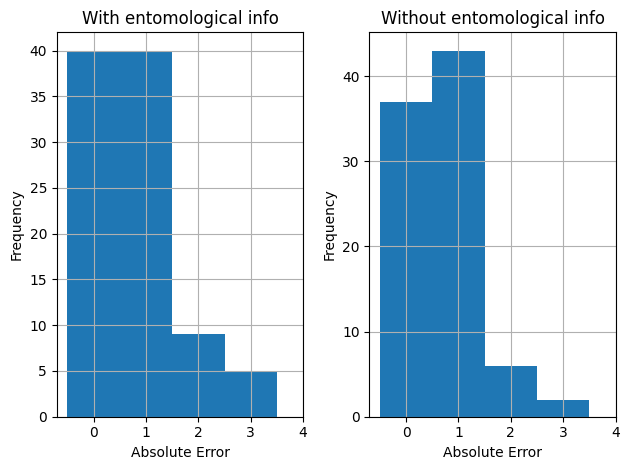

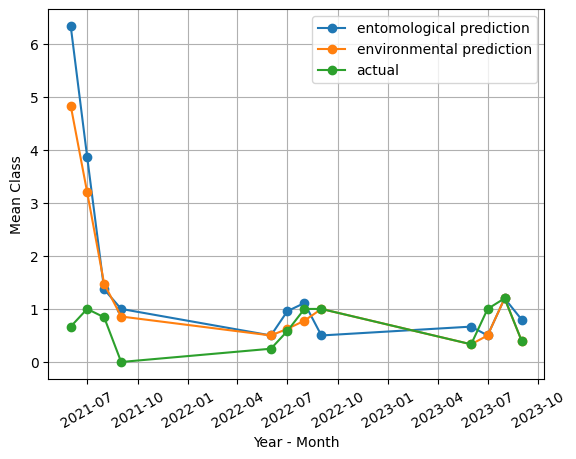

IndexError: list index out of range

In [10]:
validation_plots_comparison(path)
metrics_plot_comparison(path)
# plot_correlations_comparison(path)

In [17]:
csv_name =  path +'overall_predictions_22.csv'
predictions.to_csv(csv_name,index=False)

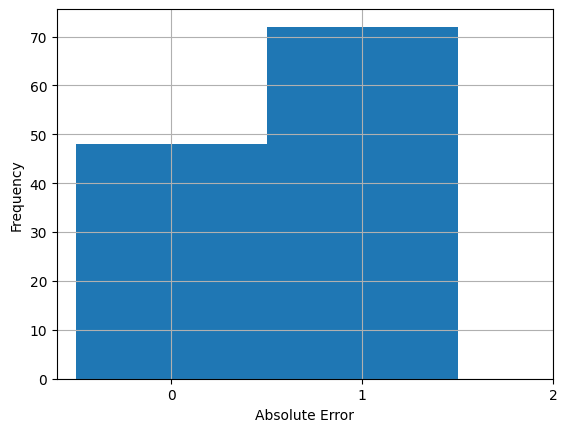

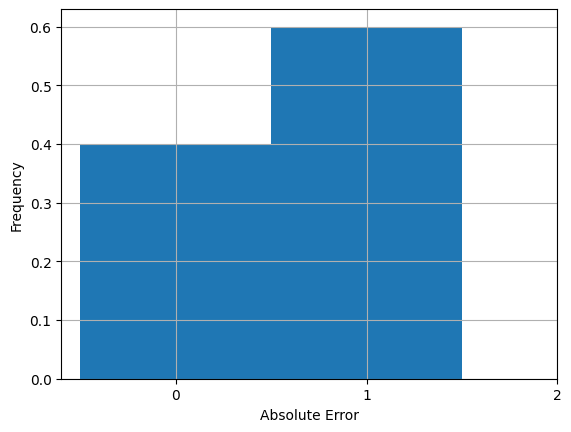

Error 0: 0.4
Error 1: 0.6
Error 0+1: 1.0


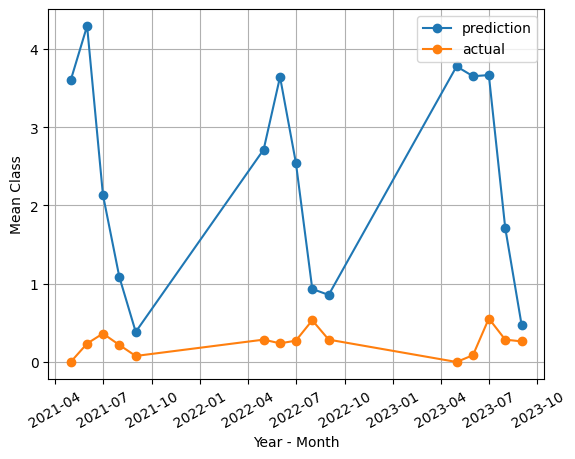

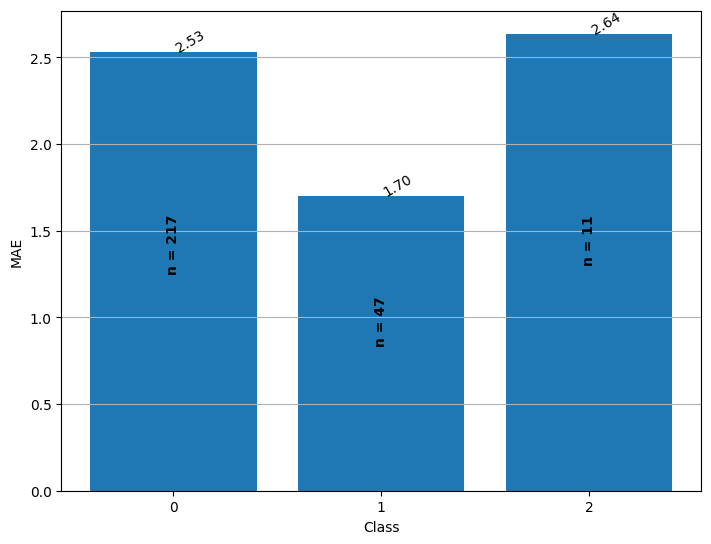

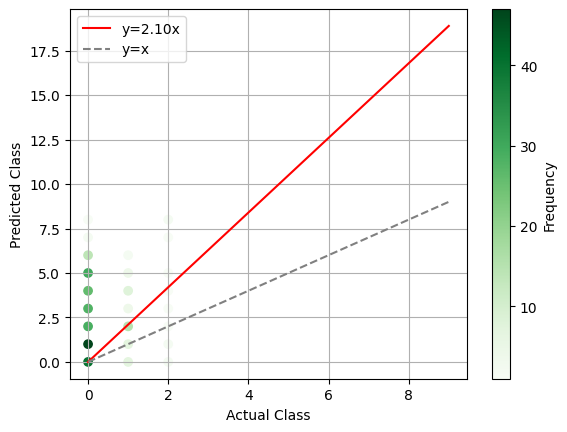

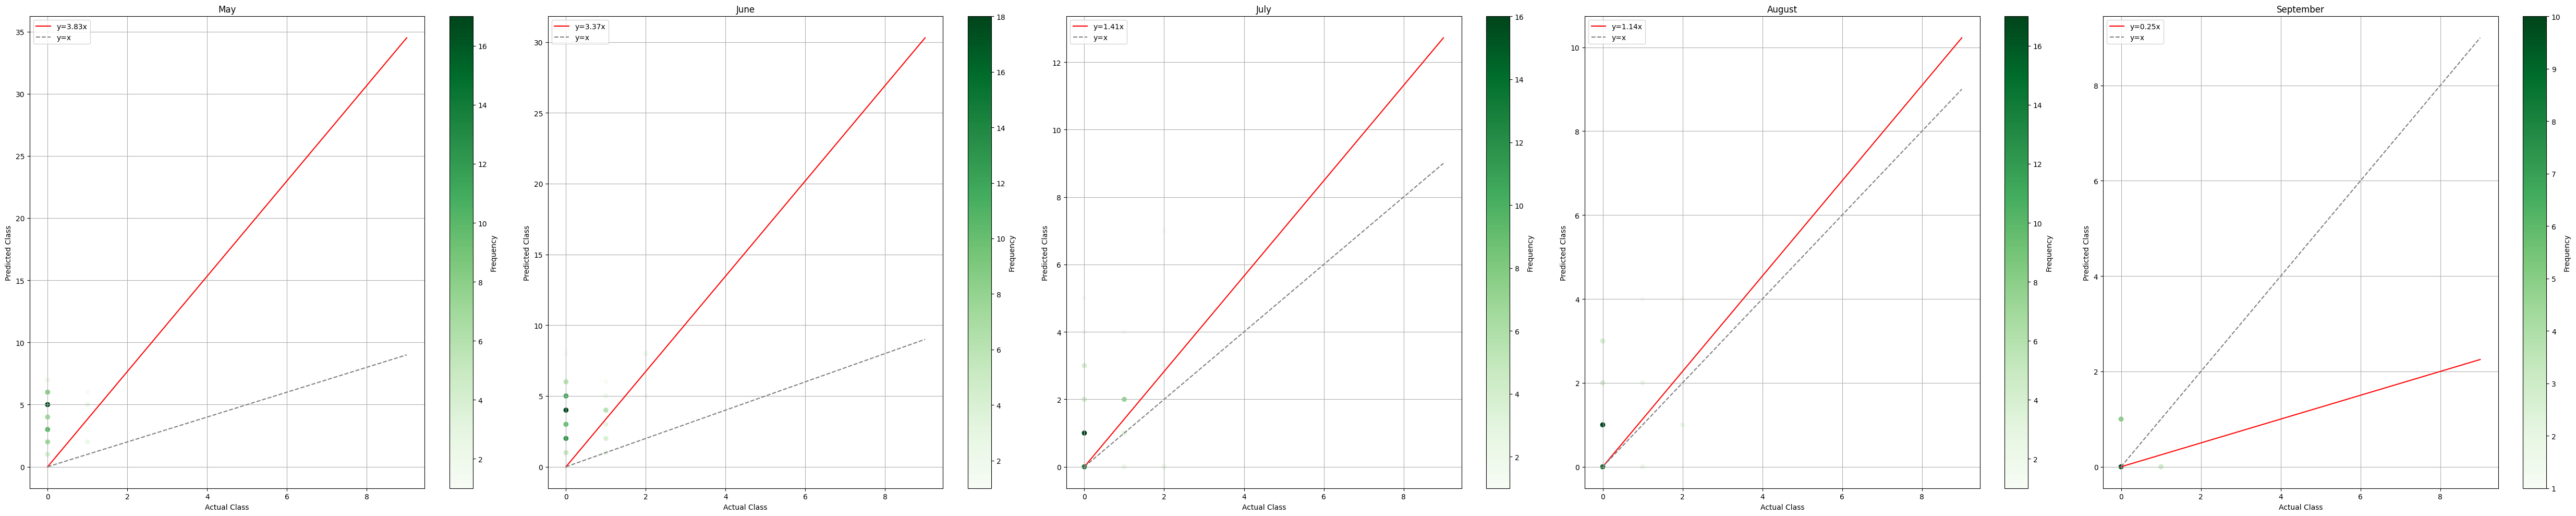

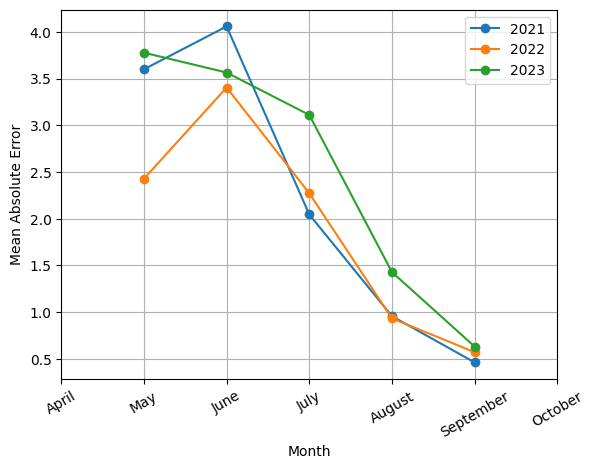

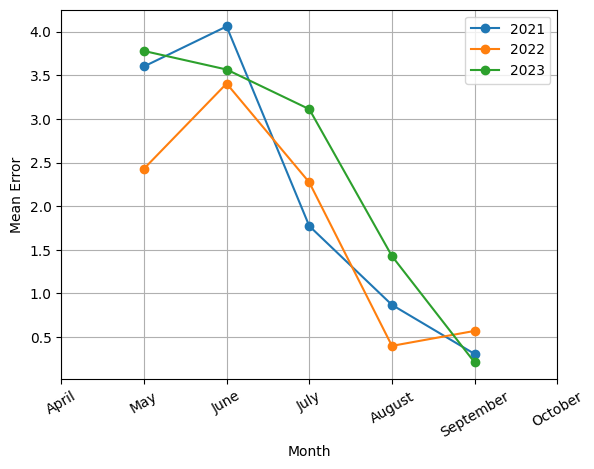

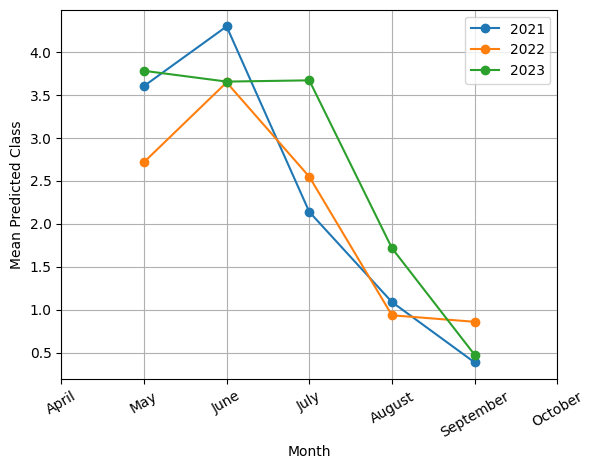

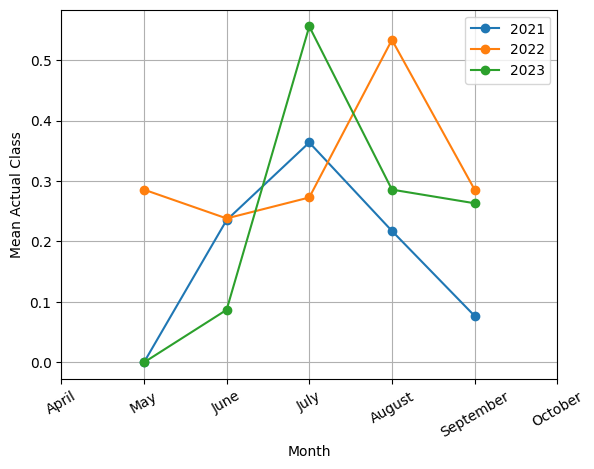

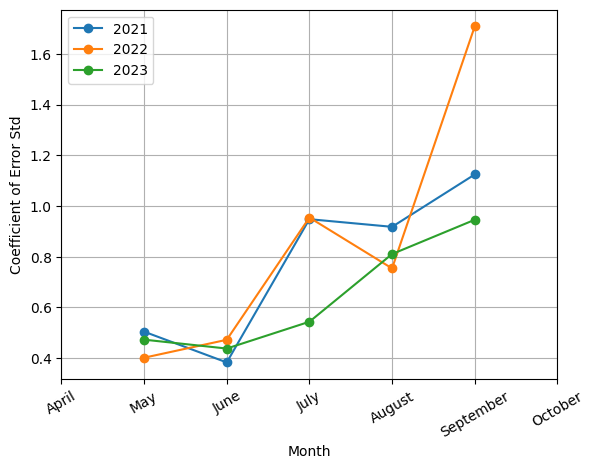

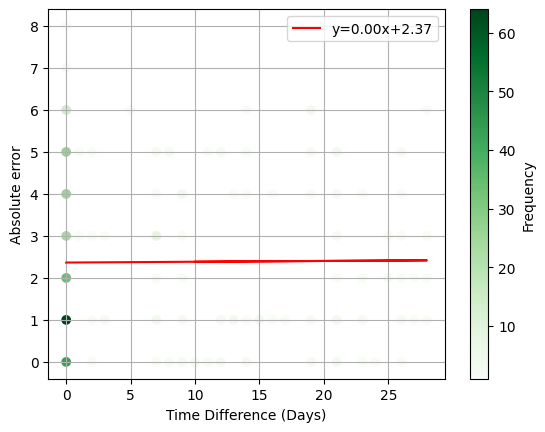

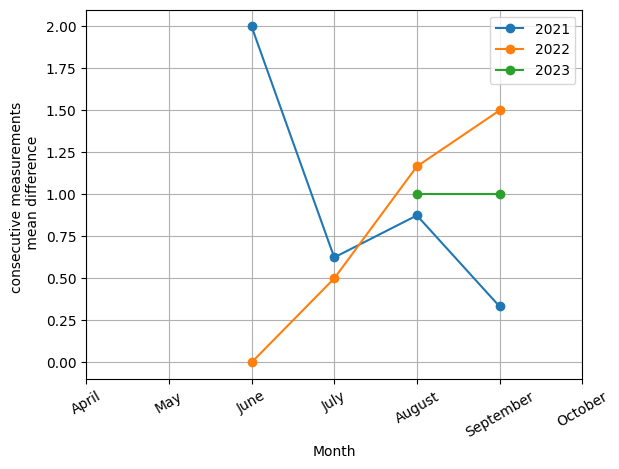

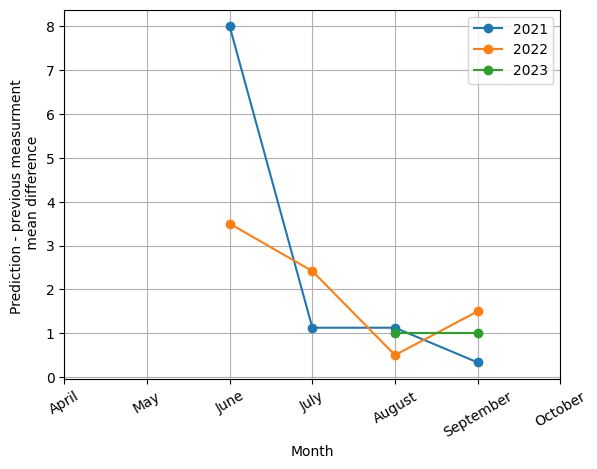

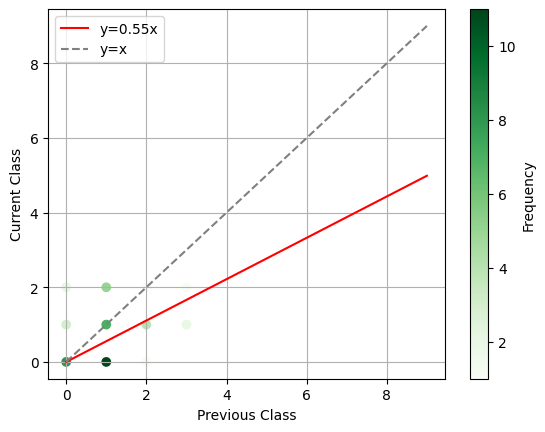

June: 1.0
July: 0.6
August: 0.5333333333333333
September: 0.42857142857142855


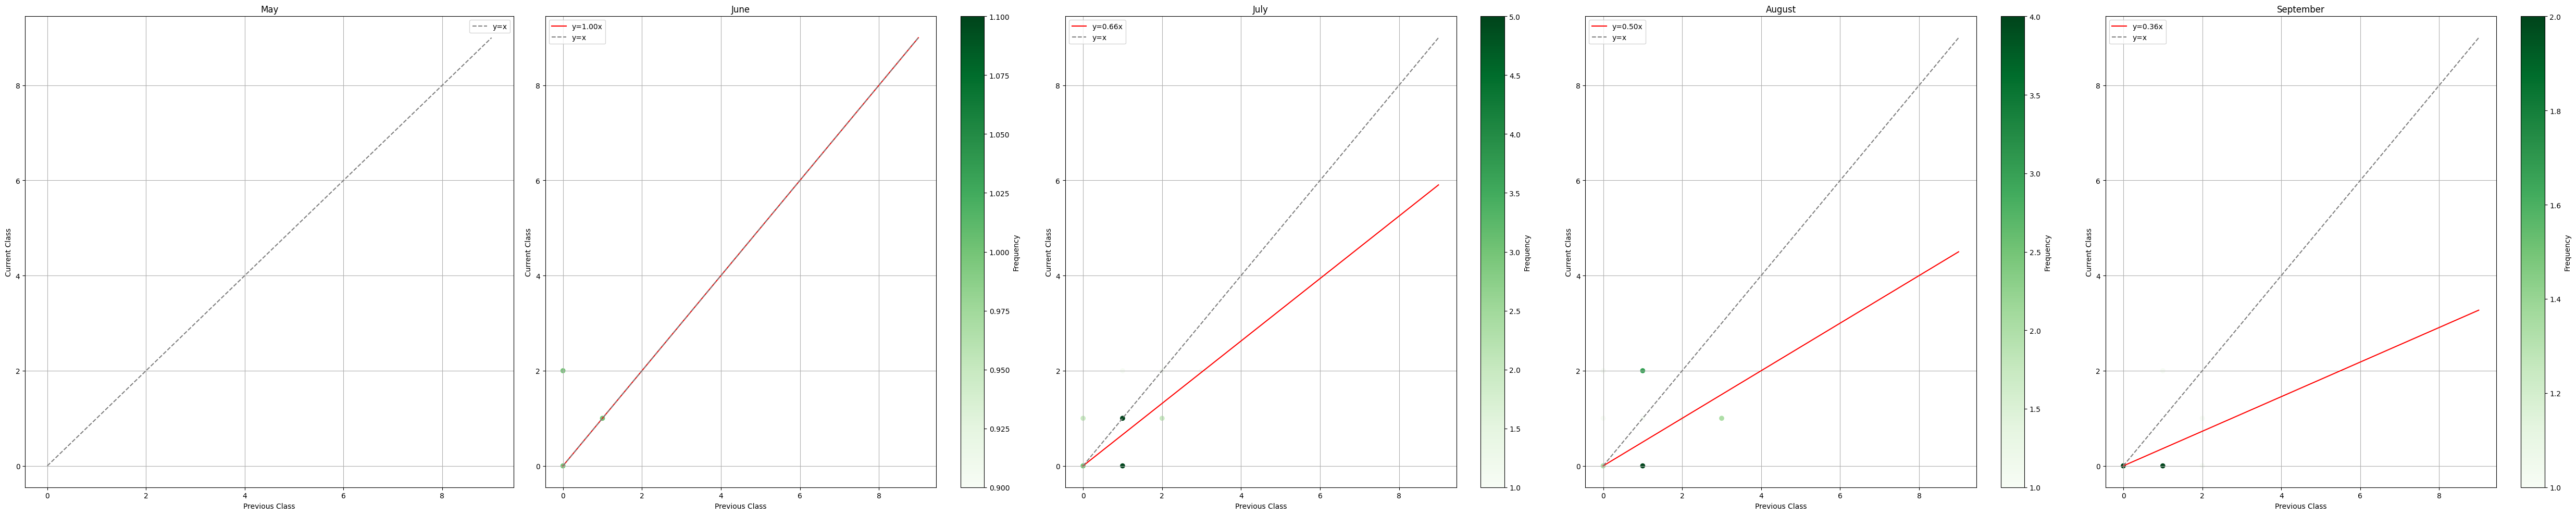

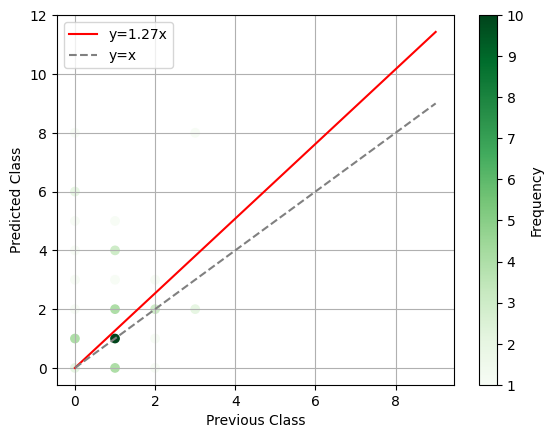

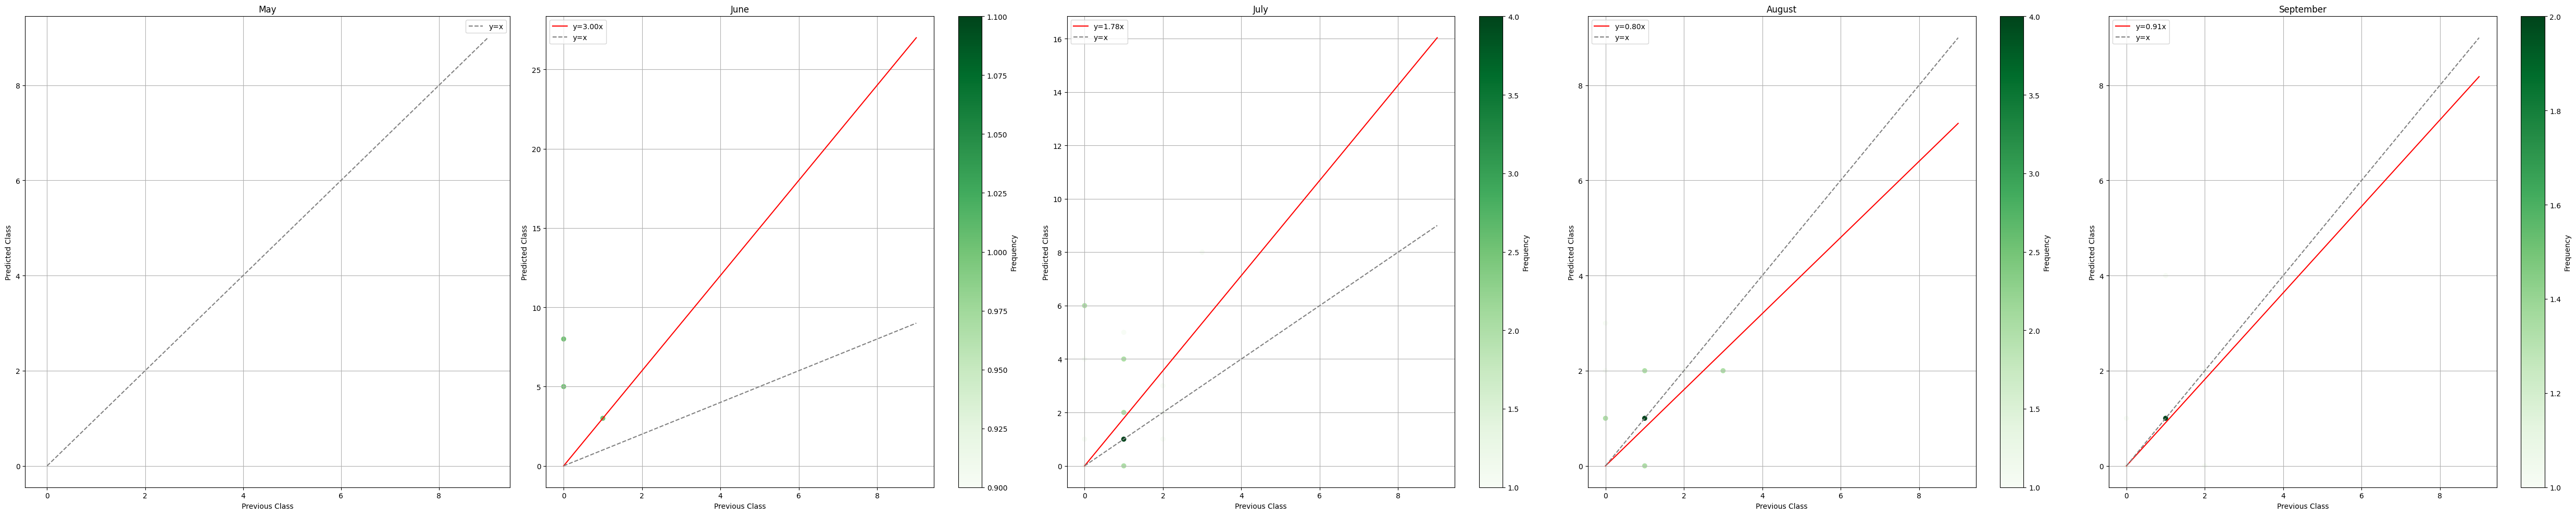

Overall MAE: 2.3927272727272726
Scaled MAE: 4.613943156302714
Bias: 2.2981818181818183
Error <= 3: 70.18
Overall MAE with entomolgical info: 1.7808219178082192
% of error <= 3 with entomolgical info: 82.19
Overall MAE without entomolgical info: 2.613861386138614
% of error <= 3 without entomolgical info: 65.84


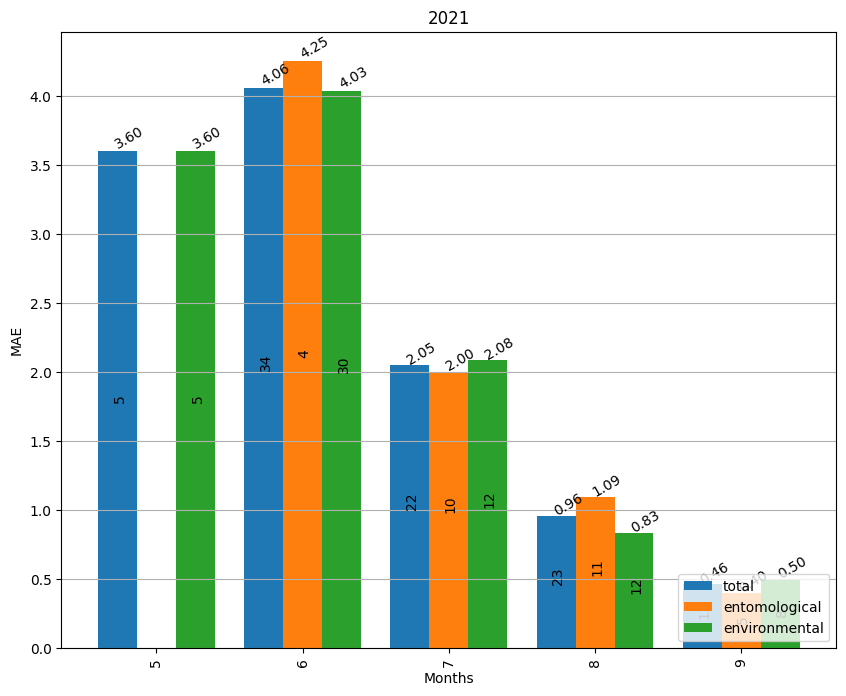

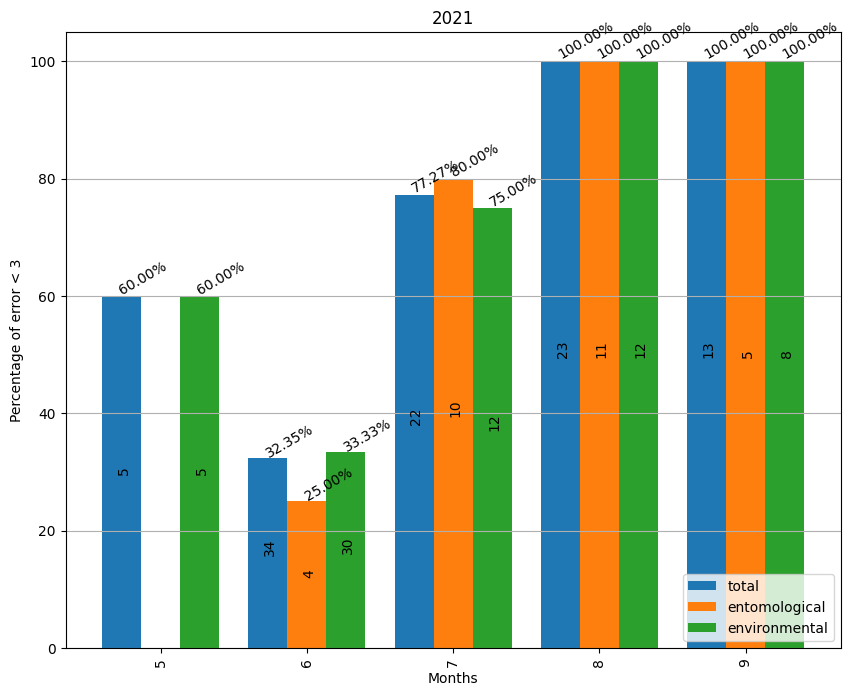

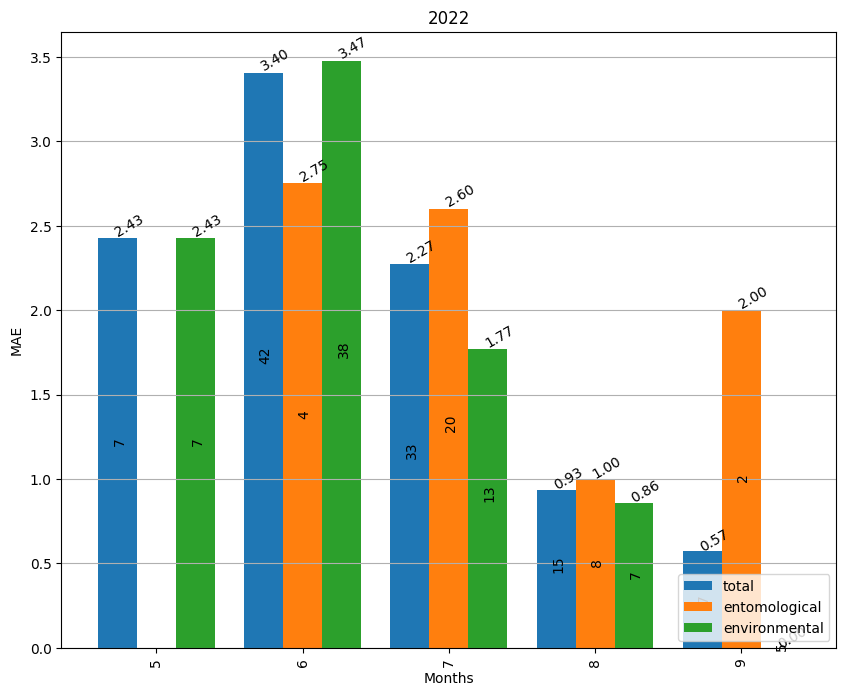

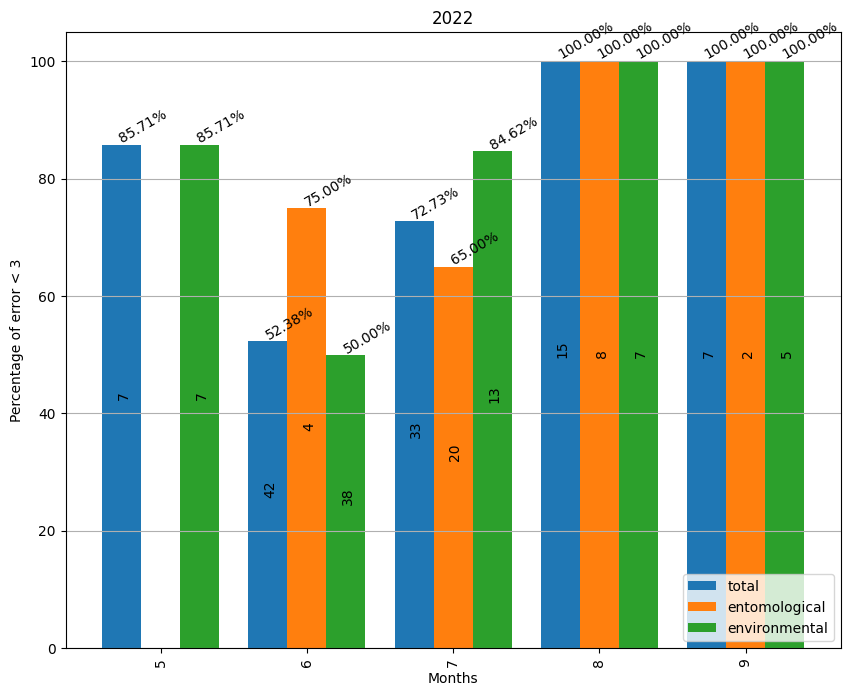

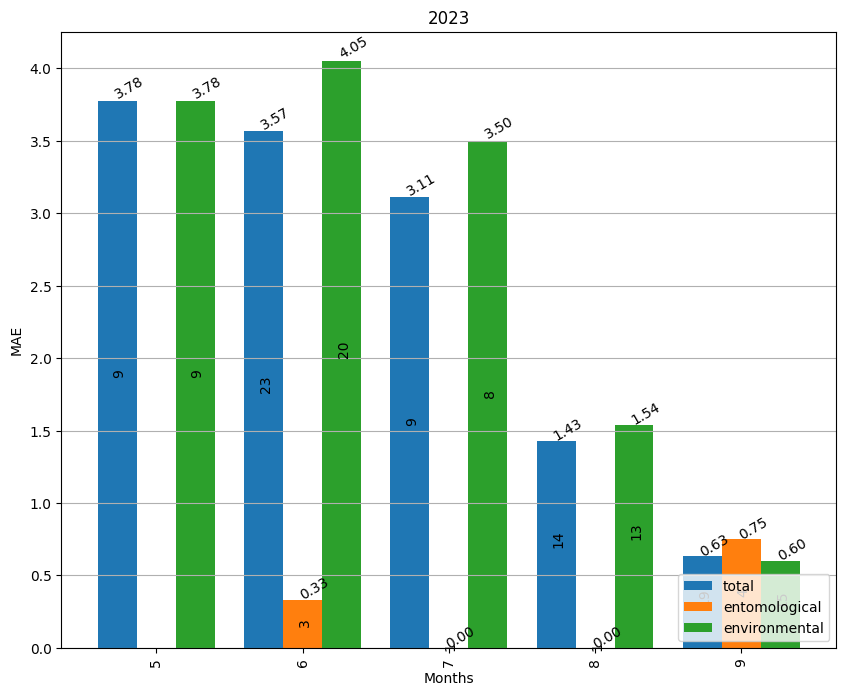

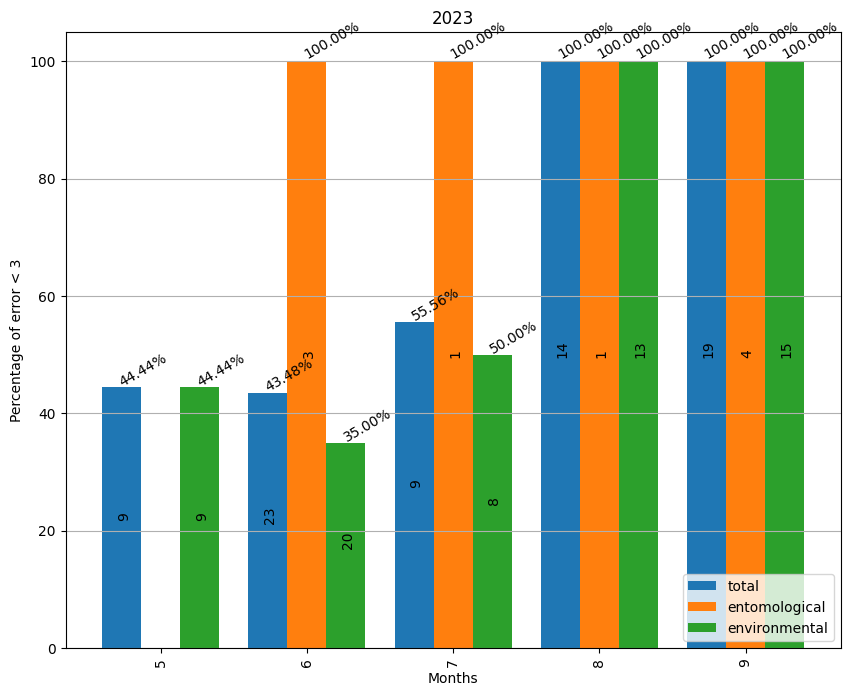

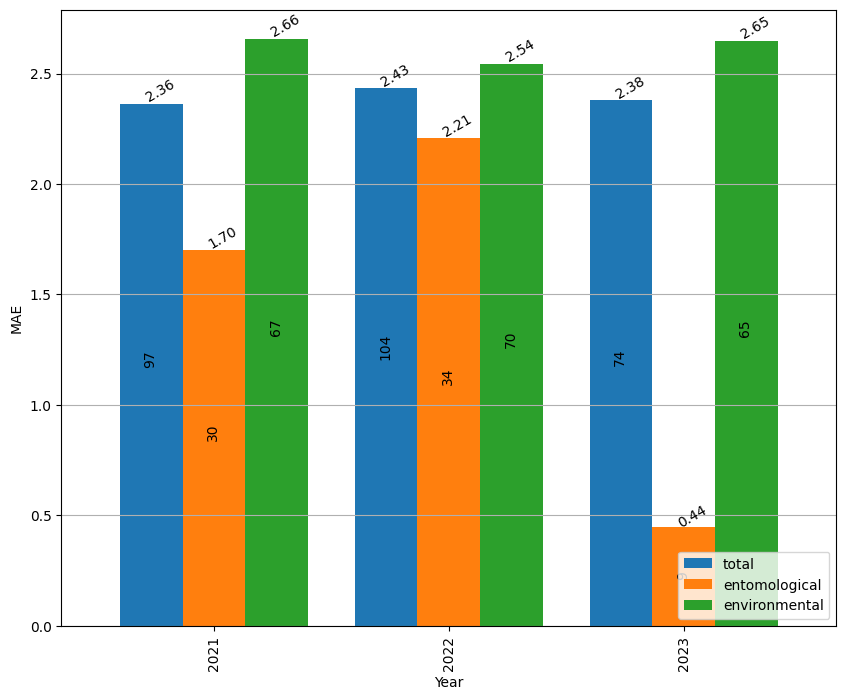

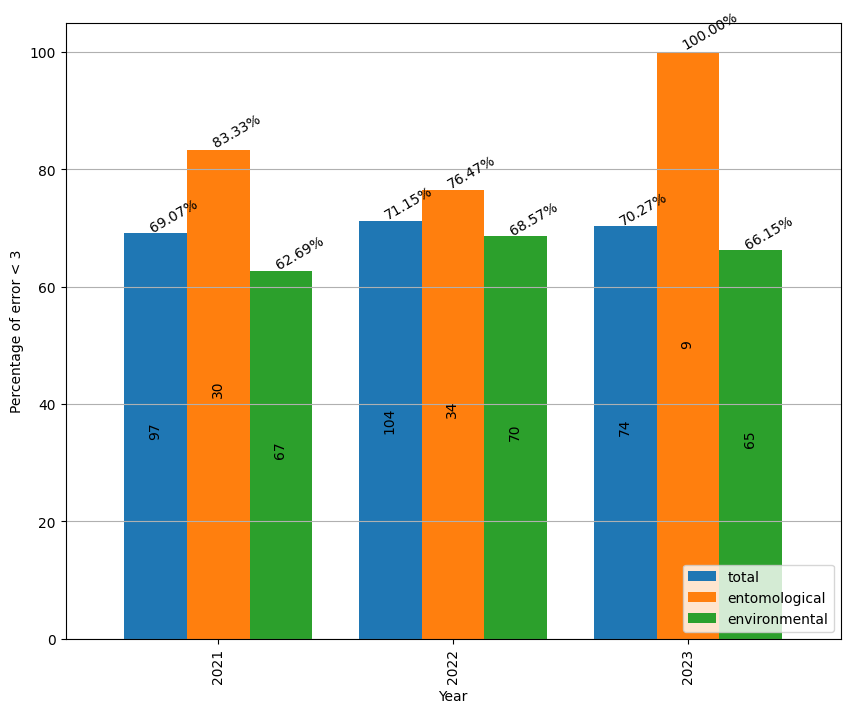

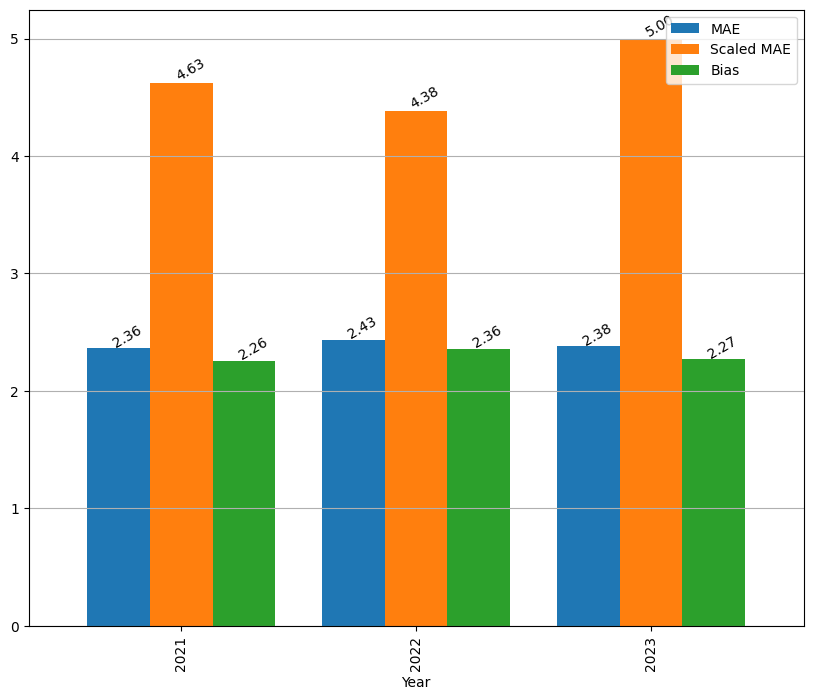

In [21]:
validation_plots(path)
metrics_plot(path)
# plot_correlations(path)

In [ ]:
import sys
sys.modules.pop('ipynb.fs.defs.Model_Validation_Module')
from ipynb.fs.defs.Model_Validation_Module import give_predictions_nn, evaluate_nn, give_predictions_xgboost, evaluate_xgboost, validate_results, validate_results2, merge_predictions
sys.modules.pop('ipynb.fs.defs.XGboost_Model_Module')
from ipynb.fs.defs.XGboost_Model_Module import Xgboost_model